# PA001: Rossmann Sales Prediction


# Planejamento da solução (IOT)

# Input - Entrada

# O problema de negócio

### Gerar previsões de faturamento para cada uma das lojas para 6 semanas, pois este representa requisito de decisão de investimento para loja, justificando assim o investimento condicionado ao faturamento futuro.

# Output - Saída

### Previsões de faturamento diário para cada uma das lojas acompanhadas online

# Tasks - Processo


Rossmann_Sales_Analysis

Dirk Rossmann GmbH (usual: Rossmann) is one of the largest drug store chains in Europe with around 56,200 employees and more than 4000 stores across Europe.

The company was founded by Dirk Rossmann with its headquarters in Burgwedel near Hanover in Germany. The Rossmann family owns 60%, and the Hong Kong-based A.S. Watson Group 40% of the company.

The company logo consists of a red name and the symbol of a centaur integrated in the letter O: a mythical creature made of horse and man from Greek mythology, which symbolically stands for "Rossmann" (English: "Horse man").The company's own brands have a small centaur symbol above the name.

Since 2018, Rossmann has been publishing a sustainability report for the development of corporate climate protection activities.
References

"Europe: top personal care retailers' store numbers 2019". Statista. Retrieved 2020-12-07.

"Personal Care Retailers in Europe". www.retail-index.com. Retrieved 2020-12-07.

"Annual report 2019" (PDF).

"Dirk Rossmann". Forbes. Retrieved 9 June 2015.

"Deshalb hat Rossmann so ein ungewöhnliches Logo gewählt". Business Insider (in German). 2016-08-19. Retrieved 2020-12-07.

"Wusstest du es? Das ist das Geheimnis hinter dem Rossmann-Logo!". BRIGITTE (in German). Retrieved 2020-12-07.

"Markengeschichte". ROSSMANN Unternehmen. Retrieved 2020-12-07.

"Nachhaltig zum Erfolg | Markant Magazin". www.markant-magazin.com. Retrieved 2021-06-14.

"ROSSMANN-Nachhaltigkeitsbericht". ROSSMANN-Nachhaltigkeitsbericht. Retrieved 2021-06-14.

# Data extraction

## Files Description

* train.csv - historical data including Sales

* test.csv - historical data excluding Sales

* store.csv - supplemental information about the stores
* Data Fields Description

* Id - an Id that represents a (Store, Date) duple within the test set

* Store - a unique Id for each store

* Sales - the turnover for any given day (this is what you are predicting)

* Customers - the number of customers on a given day

* Open - an indicator for whether the store was open: 0 = closed, 1 = open

* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

* StoreType - differentiates between 4 different store models: a, b, c, d

* Assortment - describes an assortment level: a = basic, b = extra, c = extended

* CompetitionDistance - distance in meters to the nearest competitor store

* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

* Promo - indicates whether a store is running a promo on that day

* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# 0.0 Imports

In [85]:
import pandas  as  pd
import numpy   as  np
import seaborn as  sns

import inflection
import math

from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display      import Image

# Helper Functions

In [2]:
#======================
# Large plots views 
#======================

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

#================================================
# VData frame views (NAs, Mean, Unique, Type)
#================================================

def check_dataframe( dataframe, sample_size = 3 ):
    '''
    Print number of NAs, percentage of NA to the given column,
    number of unique values, data types, dataframe shape and 
    return a random sample of dataframe'''
    
    # create dictionary with descriptive information
    dict_data = {'Num NAs':     dataframe.isna().sum(),
                 'Percent NAs': dataframe.isna().mean(),
                 'Num unique':  dataframe.nunique(),
                 'Data Type':   dataframe.dtypes }
  
    # print descriptive data
    print( pd.DataFrame( dict_data ), '\n' )
    # print dataframe shape
    print( f'Dataframe shape is {dataframe.shape}', '\n' )  
    
    
    return dataframe.sample( sample_size )

#================================================
# V Cramer Correlation on categorical variable 
#================================================

def cramer_v (x,y):
    cm = pd.crosstab( x,y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/( n-1 ) )
    
    kcorr = k -(k-1)**2/(n-1)
    rcorr = r -((r-1)**2/(n-1))
    
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1,rcorr-1 ) ) )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Loading Data

In [5]:
pwd

'/home/ehgeraldo/repos/Rossmann_Store_Sales/notebooks'

In [6]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.1 Data Description

In [7]:
df1 = df_raw.copy()

## 1.1.1 Data dimensions

In [8]:
print( 'Number of Rows:    {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows:    1017209
Number of Columns: 18


## 1.1.2 Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

In [11]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1.3 Data types

In [12]:
df1 = df1.copy()
check_dataframe( df1 ) 

                              Num NAs  Percent NAs  Num unique Data Type
store                               0     0.000000        1115     int64
day_of_week                         0     0.000000           7     int64
date                                0     0.000000         942    object
sales                               0     0.000000       21734     int64
customers                           0     0.000000        4086     int64
open                                0     0.000000           2     int64
promo                               0     0.000000           2     int64
state_holiday                       0     0.000000           4    object
school_holiday                      0     0.000000           2     int64
store_type                          0     0.000000           4    object
assortment                          0     0.000000           3    object
competition_distance             2642     0.002597         654   float64
competition_open_since_month   323348     0.317878 

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
471440,581,1,2014-05-05,8529,882,1,1,0,0,a,a,7250.0,12.0,2013.0,0,NaN,NaN,NaN
354459,327,3,2014-08-27,6593,866,1,0,0,1,c,c,1390.0,12.0,2004.0,0,NaN,NaN,NaN
283820,830,2,2014-11-11,6904,582,1,1,0,0,a,c,6320.0,NaN,NaN,1,5.0,2011.0,"Jan,Apr,Jul,Oct"


In [13]:
df1['date'] = pd.to_datetime( df1['date'] )

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.2 Fillout NAs

In [15]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [16]:
# I assumed a very large distance so that there was no competitor
# competition_distance

df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# I assumed that not that I was not competitive, but I took the month date of the last date when there was competition
# competition_open_since_month

df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )
    
# I assumed that not that I was not competitive, but I took the year date of the last date when there was competition
# competition_open_since_year  

df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )

# I assumed that not that I was not promo2, but I took the week date of the last date when there was competition
# promo2_since_week   

df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )                    

# I assumed that not that I was not promo2, but I took the year date of the last date when there was competition
# promo2_since_year

df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )                    

             
# promo_interval:

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )  

In [17]:
df1 = df1.copy()
check_dataframe( df1 ) 

                              Num NAs  Percent NAs  Num unique       Data Type
store                               0          0.0        1115           int64
day_of_week                         0          0.0           7           int64
date                                0          0.0         942  datetime64[ns]
sales                               0          0.0       21734           int64
customers                           0          0.0        4086           int64
open                                0          0.0           2           int64
promo                               0          0.0           2           int64
state_holiday                       0          0.0           4          object
school_holiday                      0          0.0           2           int64
store_type                          0          0.0           4          object
assortment                          0          0.0           3          object
competition_distance                0          0.0  

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
650685,311,1,2013-11-25,6243,846,1,0,0,0,a,c,680.0,7.0,2005.0,0,48.0,2013.0,0,Nov,0
374945,229,2,2014-08-05,9831,745,1,1,0,1,d,c,17410.0,4.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Aug,0
142719,1115,4,2015-03-26,5234,367,1,0,0,0,d,c,5350.0,3.0,2015.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",Mar,1


# 1.3 Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
# Change float to int thouse attributes

# competition_open_since_month           float64
# competition_open_since_year            float64
# promo2_since_week                      float64
# promo2_since_year                      float64

In [20]:
df1[ 'competition_open_since_month' ] = df1[ 'competition_open_since_month' ].astype(int)

df1[ 'competition_open_since_year' ]  = df1[ 'competition_open_since_year' ].astype(int)

df1[ 'promo2_since_week' ]            = df1[ 'promo2_since_week'].astype(int)

df1[ 'promo2_since_year' ]            = df1[ 'promo2_since_year' ].astype(int)

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.4 Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

## Numerical Attributes

In [23]:
# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [ d2,d3,d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Count'>

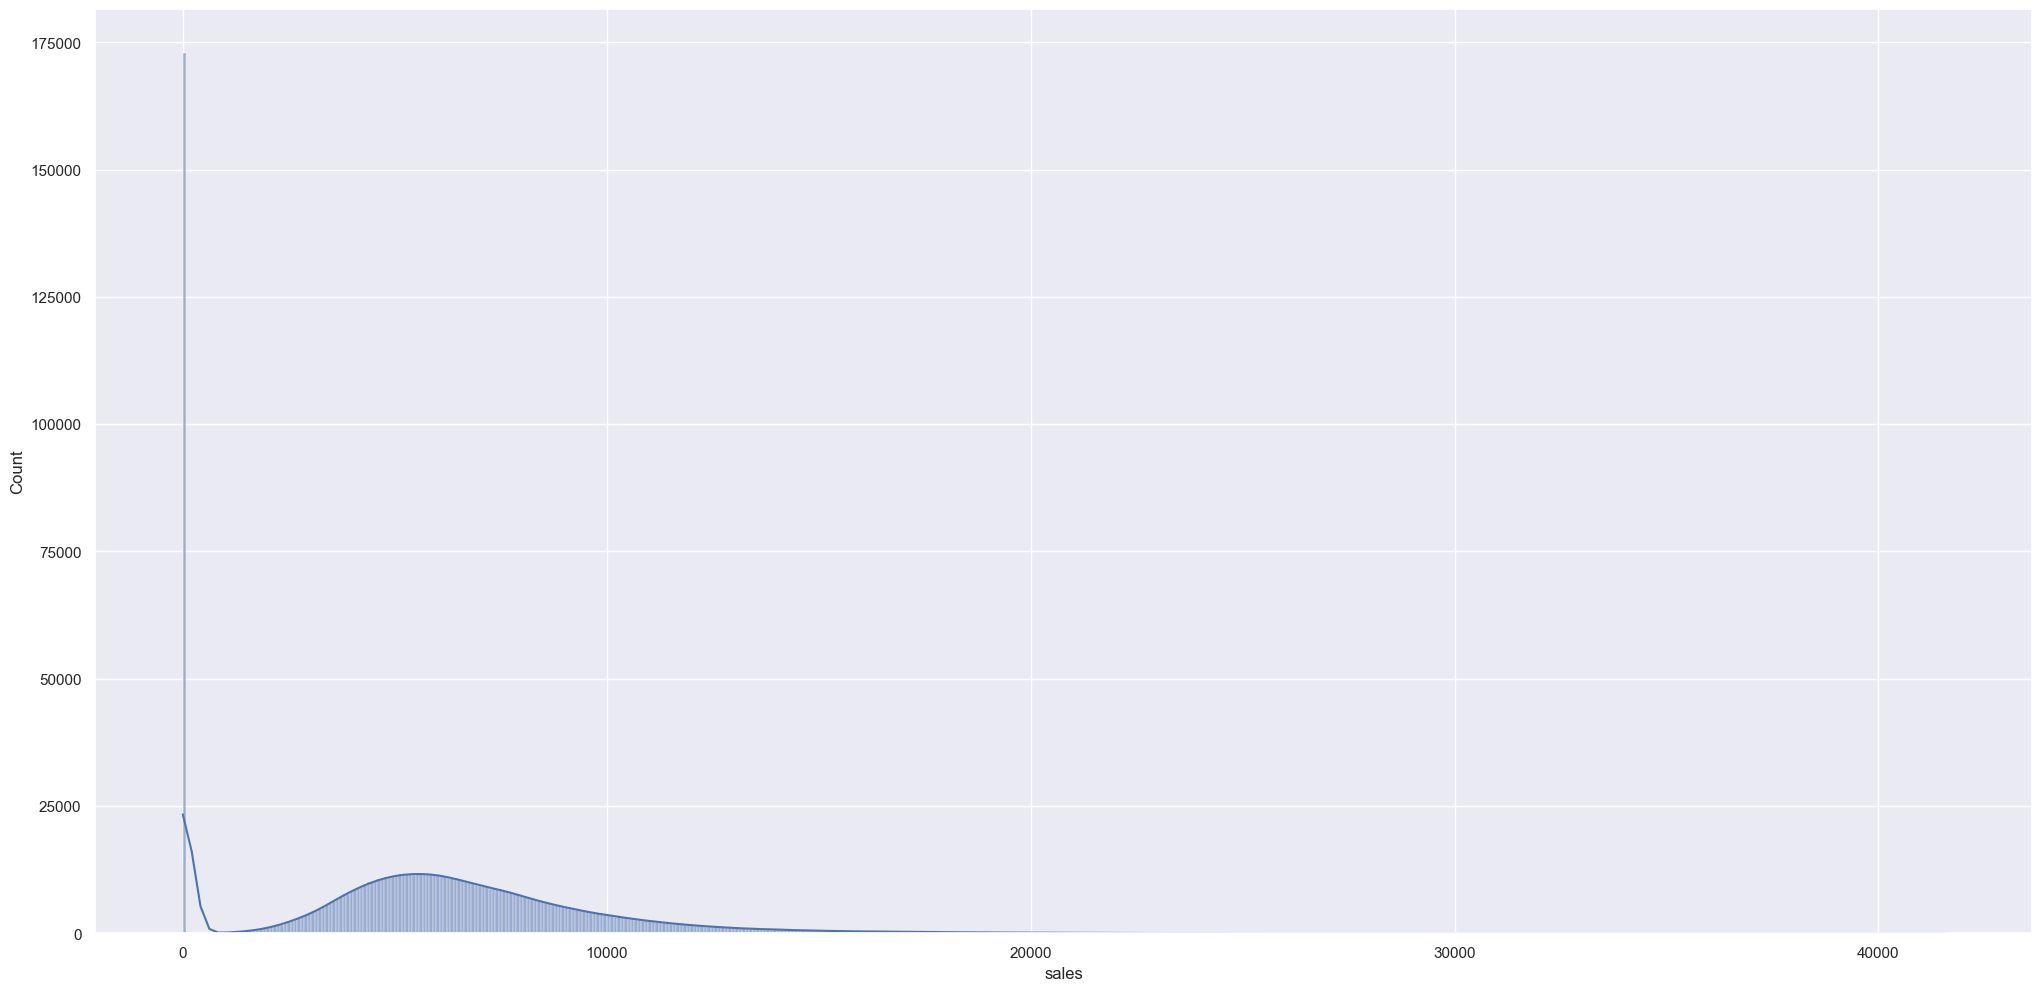

In [24]:
# min = 0, max = 7388.0, range = 41551, mean = 5773, std = 3849, skew = 0,64, kurtosis = 1,77

sns.histplot( df1['sales'], kde=True )

<AxesSubplot:xlabel='customers', ylabel='Count'>

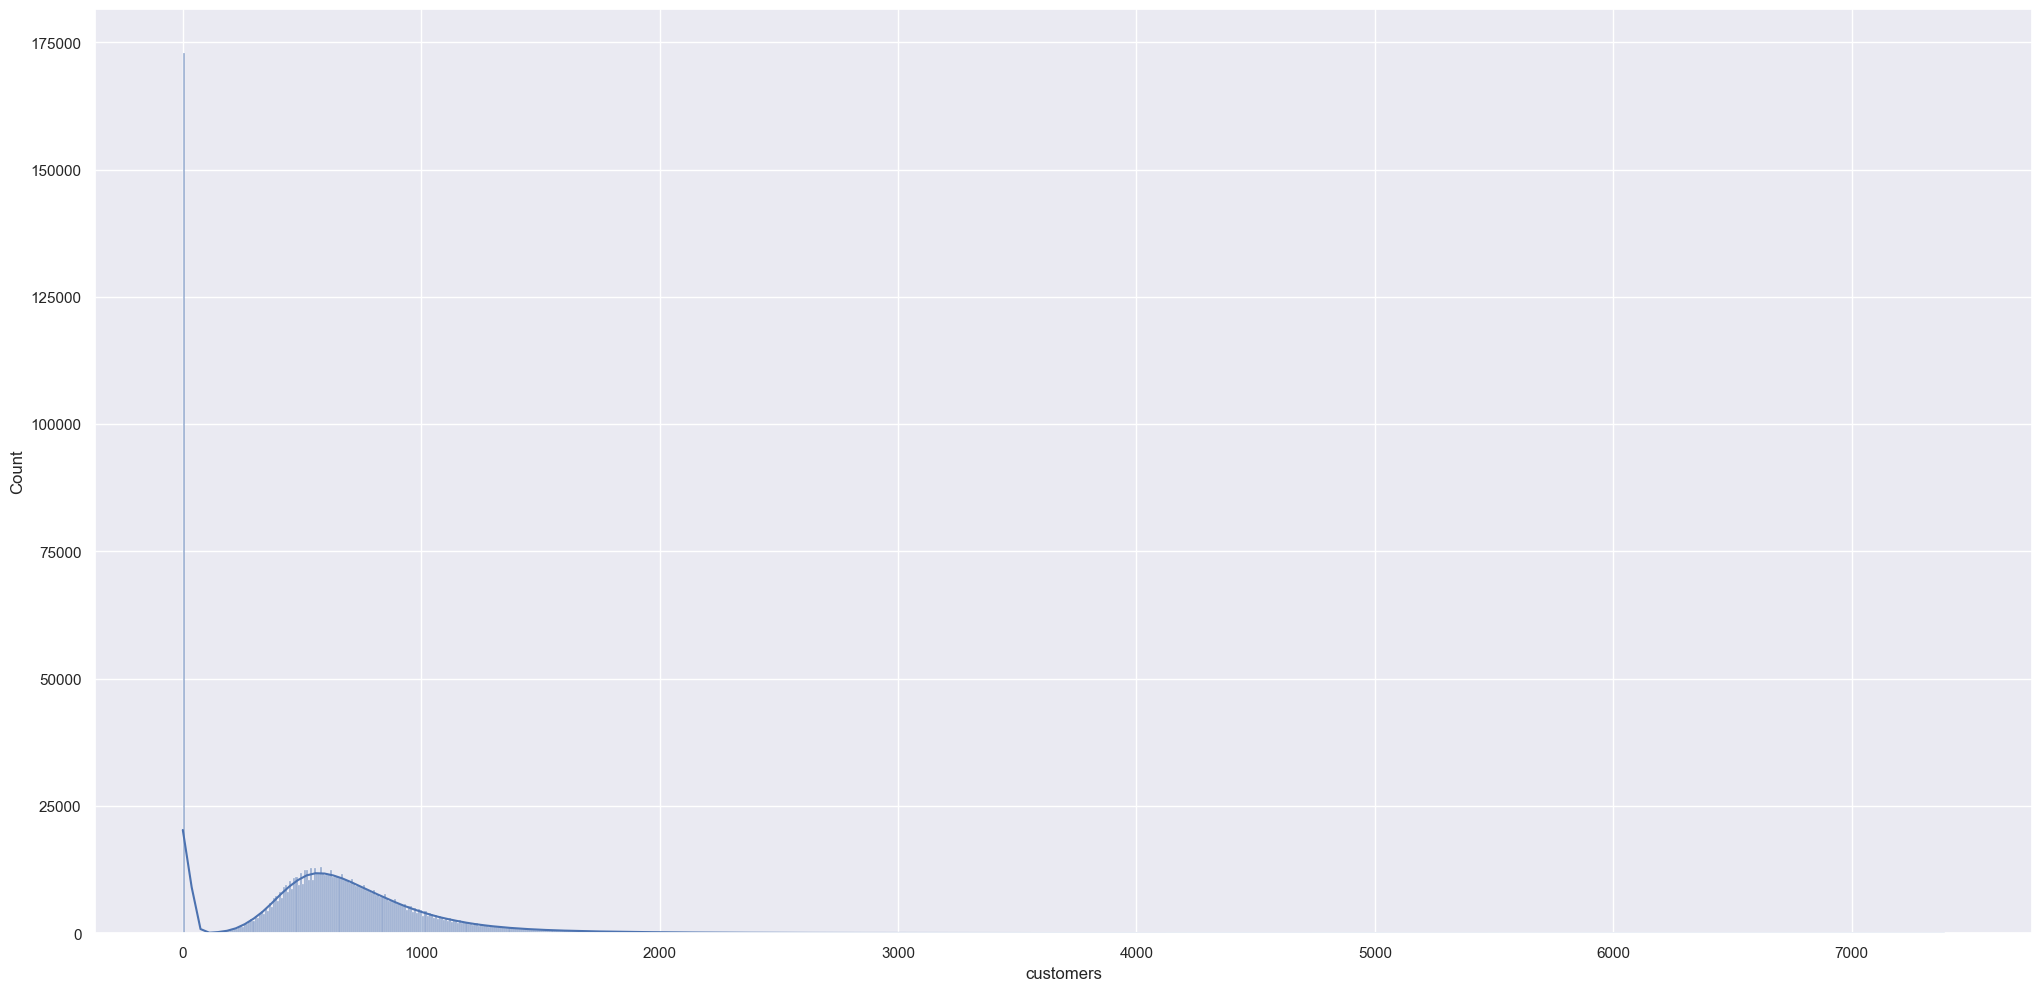

In [121]:
# min = 0, max = 7388.0, range = 7388.0, mean = 633, std = 464, skew = 1,59, kurtosis = 7,09
sns.histplot( df1['customers'], kde=True )

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

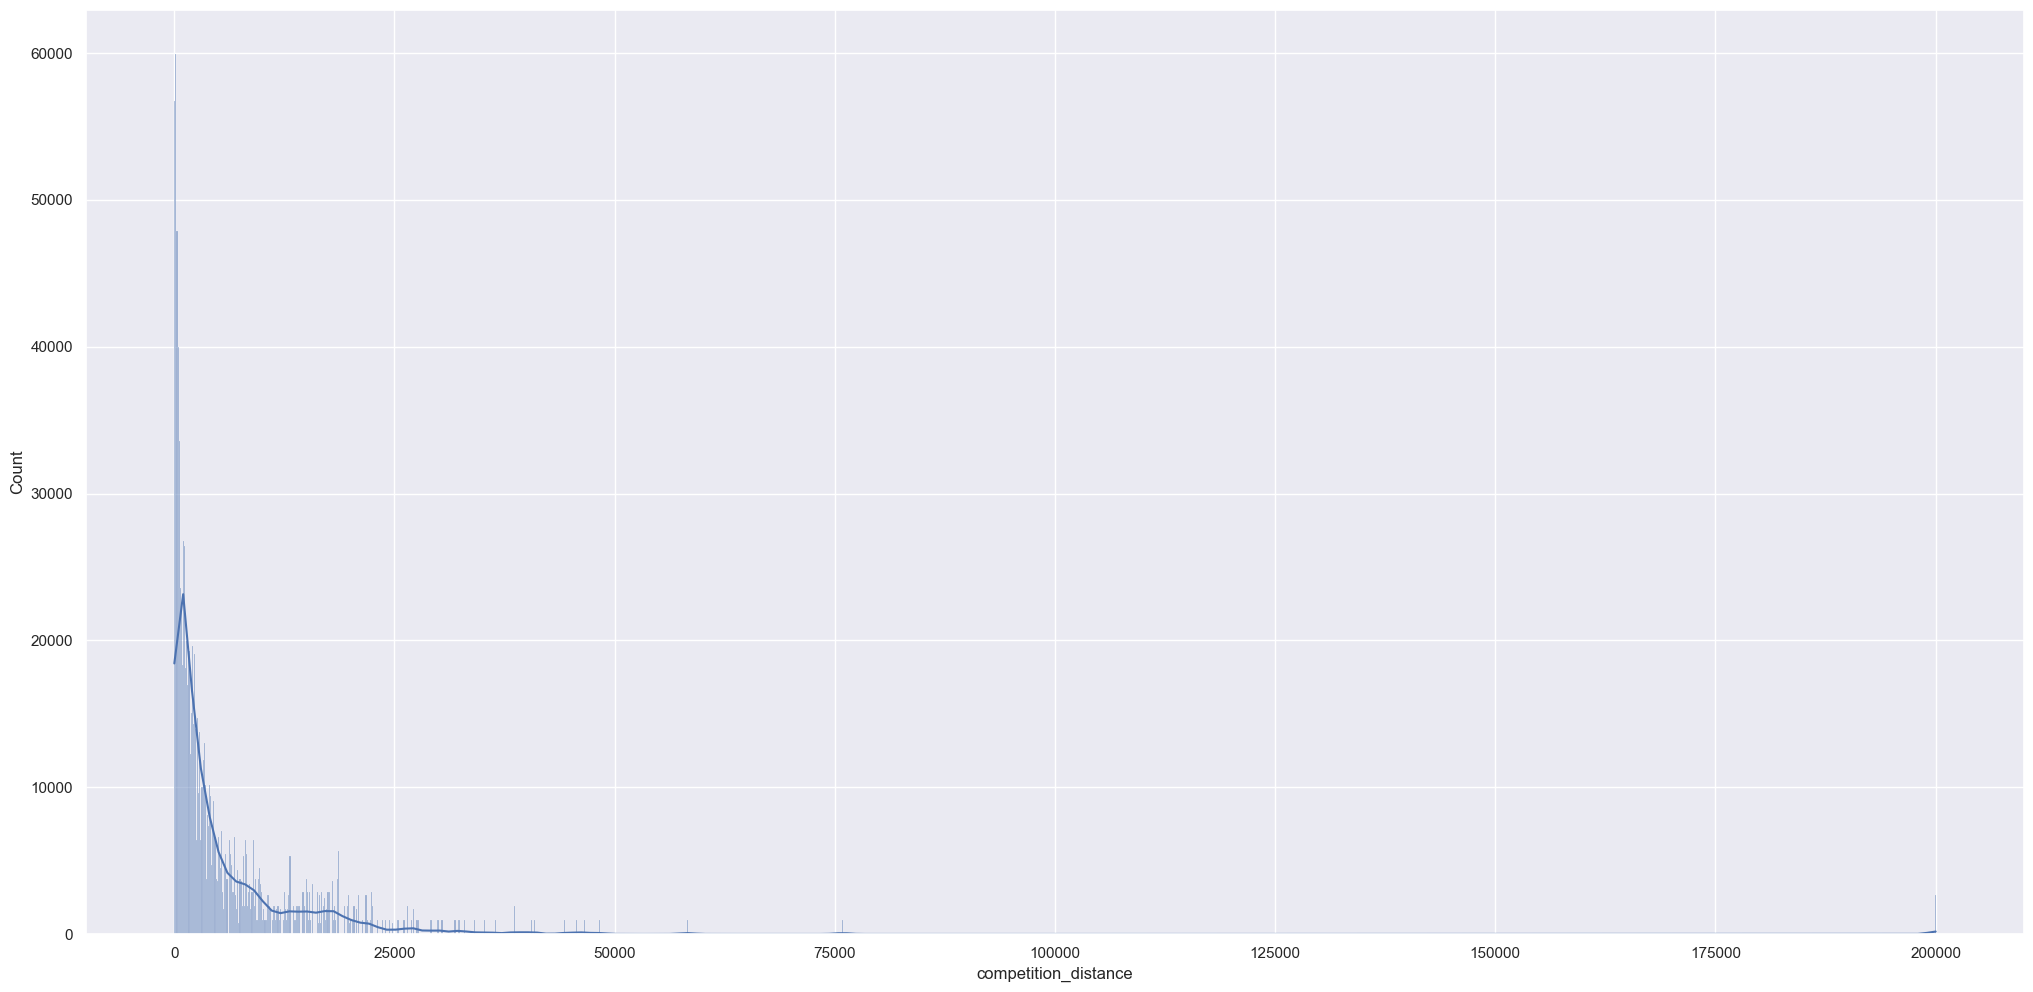

In [25]:
# min = 0, max = 200000.0, range = 200000.0, mean = 5935, std = 12547, skew = 10,24, kurtosis = 147,79
sns.histplot( df1['competition_distance'], kde=True )

## 1.4.1 Categorical Attributes

In [26]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

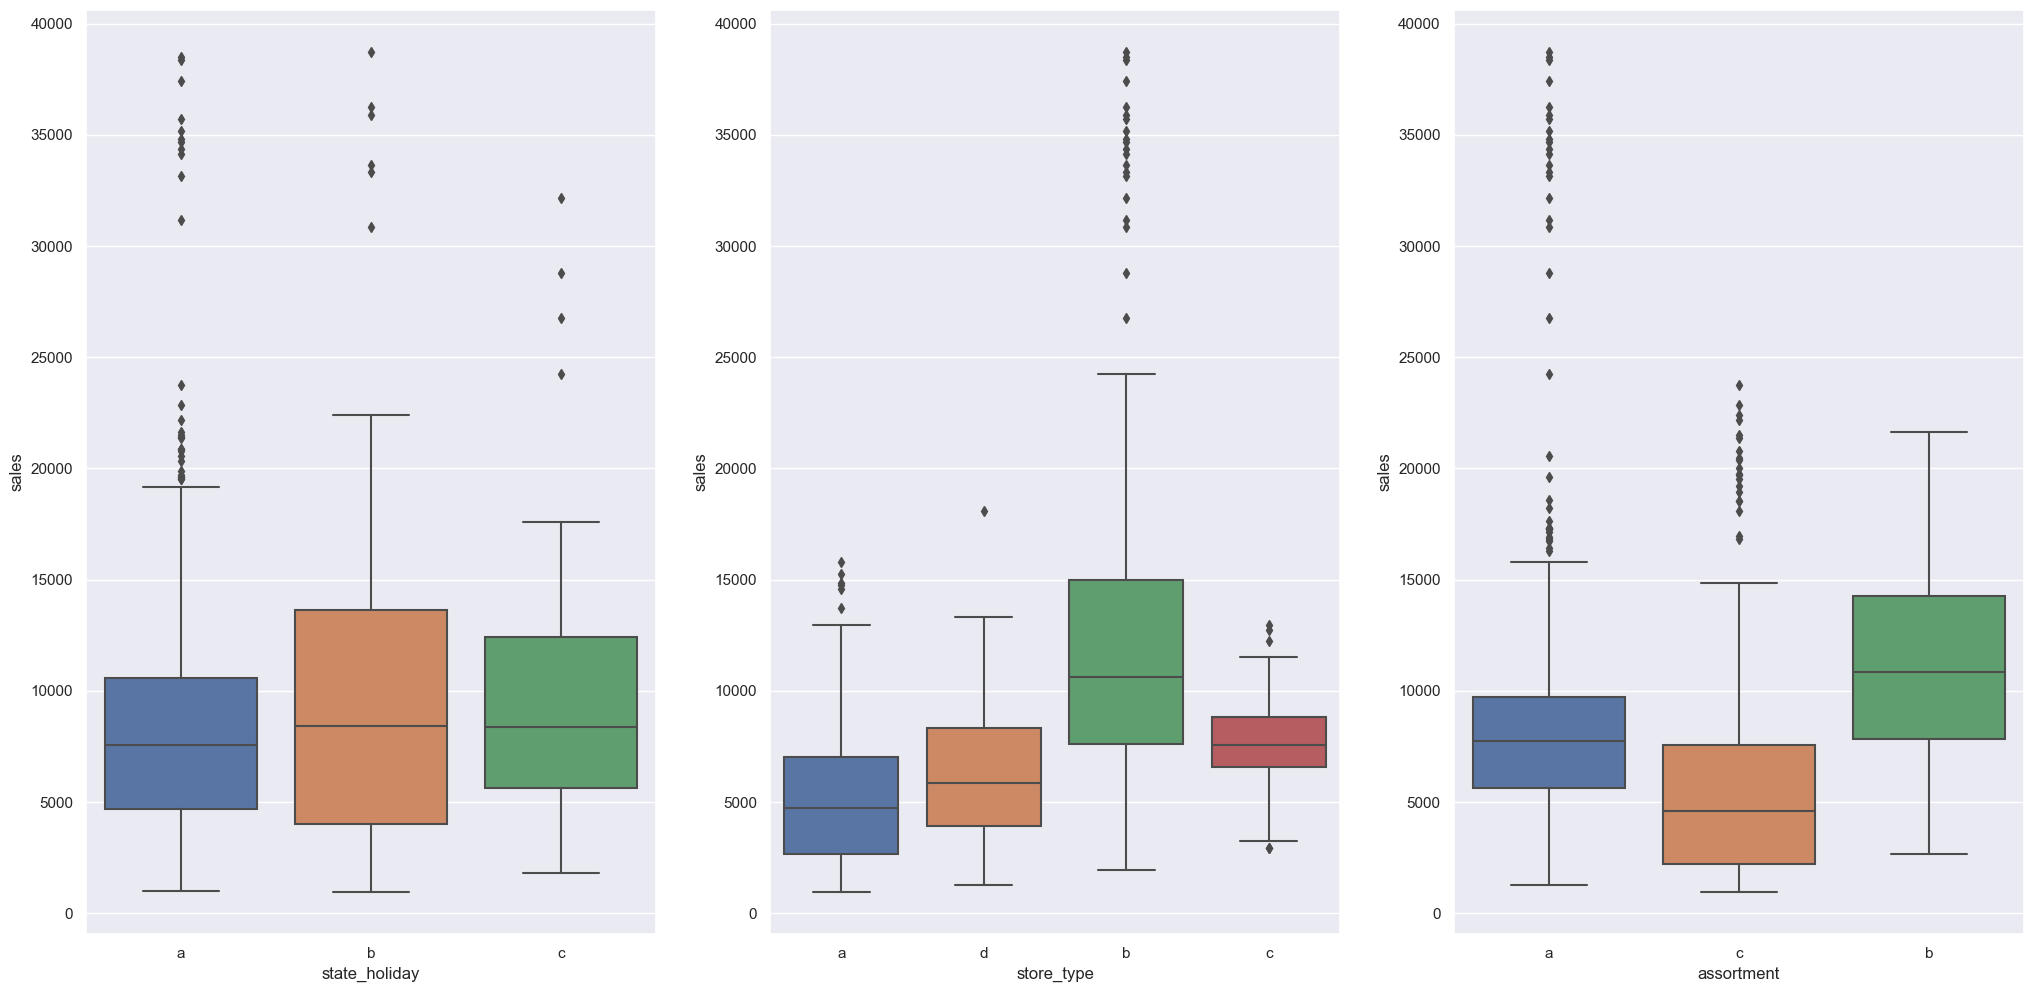

In [27]:
aux = df1[( df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1 )
sns.boxplot(x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2 )
sns.boxplot(x='store_type',    y='sales', data=aux )

plt.subplot(1, 3, 3 )
sns.boxplot(x='assortment',    y='sales', data=aux )

# 2.0 Hypoteses map

In [28]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

### 2.1.1 Hipóteses para fator Loja correlacionados com fator venda

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas de maior porte deveriam vender mais.

**4.** Lojas de menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hipóteses para fator Produto correlacionados com fator venda

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem podutos com menores preços deveriam vender mais. 

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

### 2.1.3 Hipóteses para fator Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao londo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares.



In [29]:
cd ..

/home/ehgeraldo/repos/Rossmann_Store_Sales


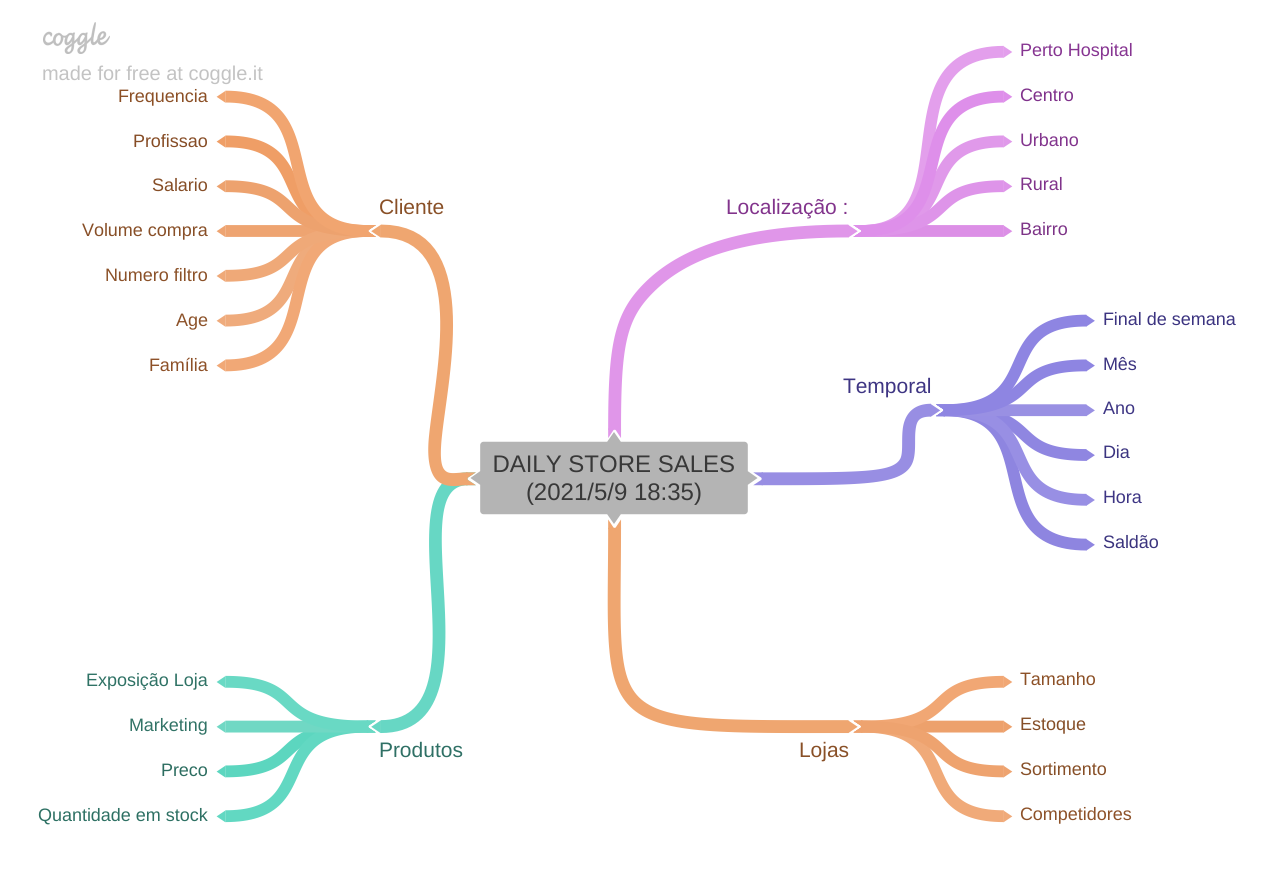

In [30]:
Image( 'image/daily_store_map_image.png' )

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

**5.** Lojas que tem podutos com menores preços deveriam vender mais. 

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais

**7.** Lojas deveriam vender mais ao londo dos anos

**8.** Lojas deveriam vender mais no segundo semestre do ano

**9.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**10.** Lojas deveriam vender menos aos finais de semana

**11.** Lojas deveriam vender menos durante os feriados escolares.



### 2.1.2 Hipóteses para fator Produto correlacionados com fator venda

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem podutos com menores preços deveriam vender mais. 

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

### 2.1.3 Hipóteses para fator Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao londo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares.

# 3.0 Feature engineering

In [31]:
df3 = df2.copy()

## 3.1 Variable filter application

In [32]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Columns filter application

In [33]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [34]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# make day_of_week start from 0 -> (sunday = 0)
df3['day_of_week'] = df3['day_of_week'].apply( lambda x: 0 if x == 7 else x )

# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo since:
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )

df3['promo_since'] = df3['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment:
# a = basic, b = extra, c = extendend

df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extendend' )

# state holiday:
# a = public holiday, b = easter holiday, c = christmas 

df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_6749/3289316521.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year'] = df3['date'].dt.weekofyear


In [35]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extendend,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0 EDA - Exploration Data Analysis

In [36]:
df4 = df3.copy()

# 4.1 Univariate Analysis

 ### 4.1.1 Response Variable 

/tmp/ipykernel_6749/3300234349.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'] )


<AxesSubplot:xlabel='sales', ylabel='Density'>

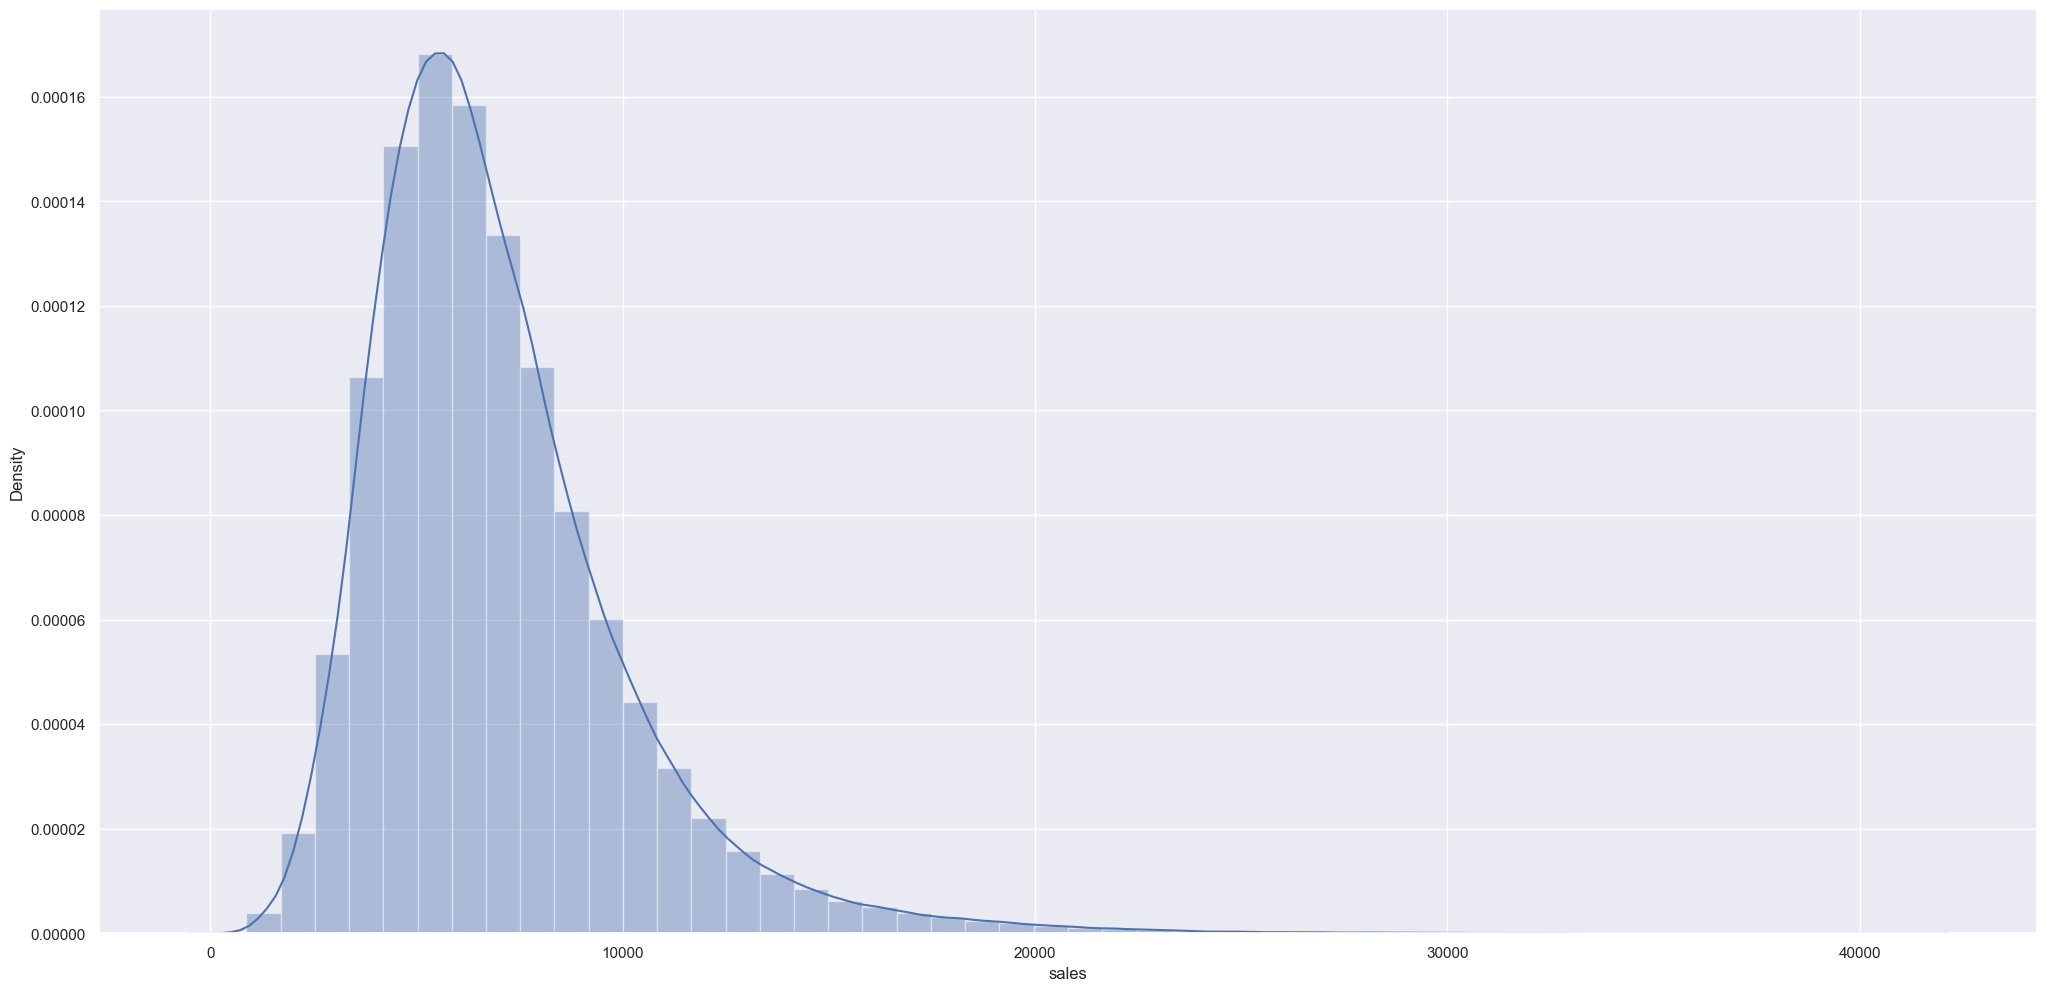

In [37]:
sns.distplot( df4['sales'] )

/tmp/ipykernel_6749/3854455431.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( np.log1p( df4['sales'] ) )


<AxesSubplot:xlabel='sales', ylabel='Density'>

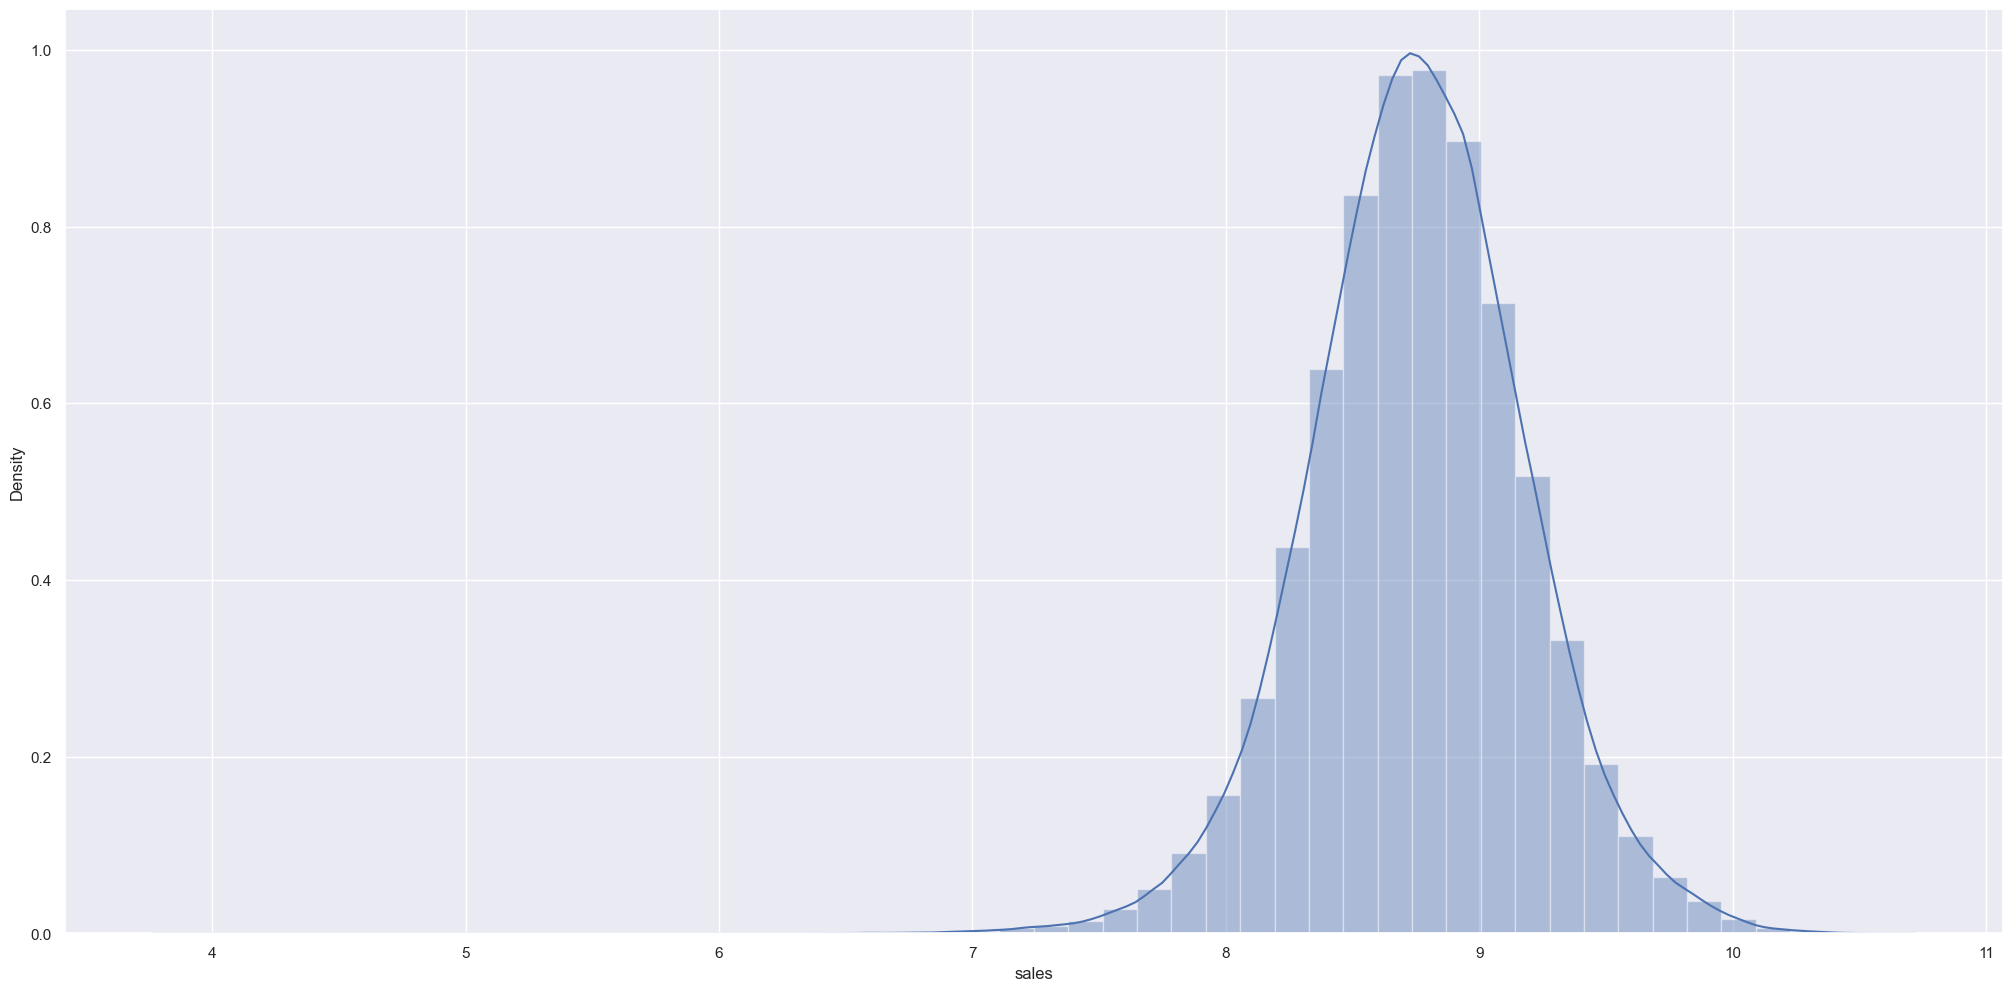

In [38]:
# log1p to response variable

sns.distplot( np.log1p( df4['sales'] ) )

 ## 4.1.2 Numerical Variable

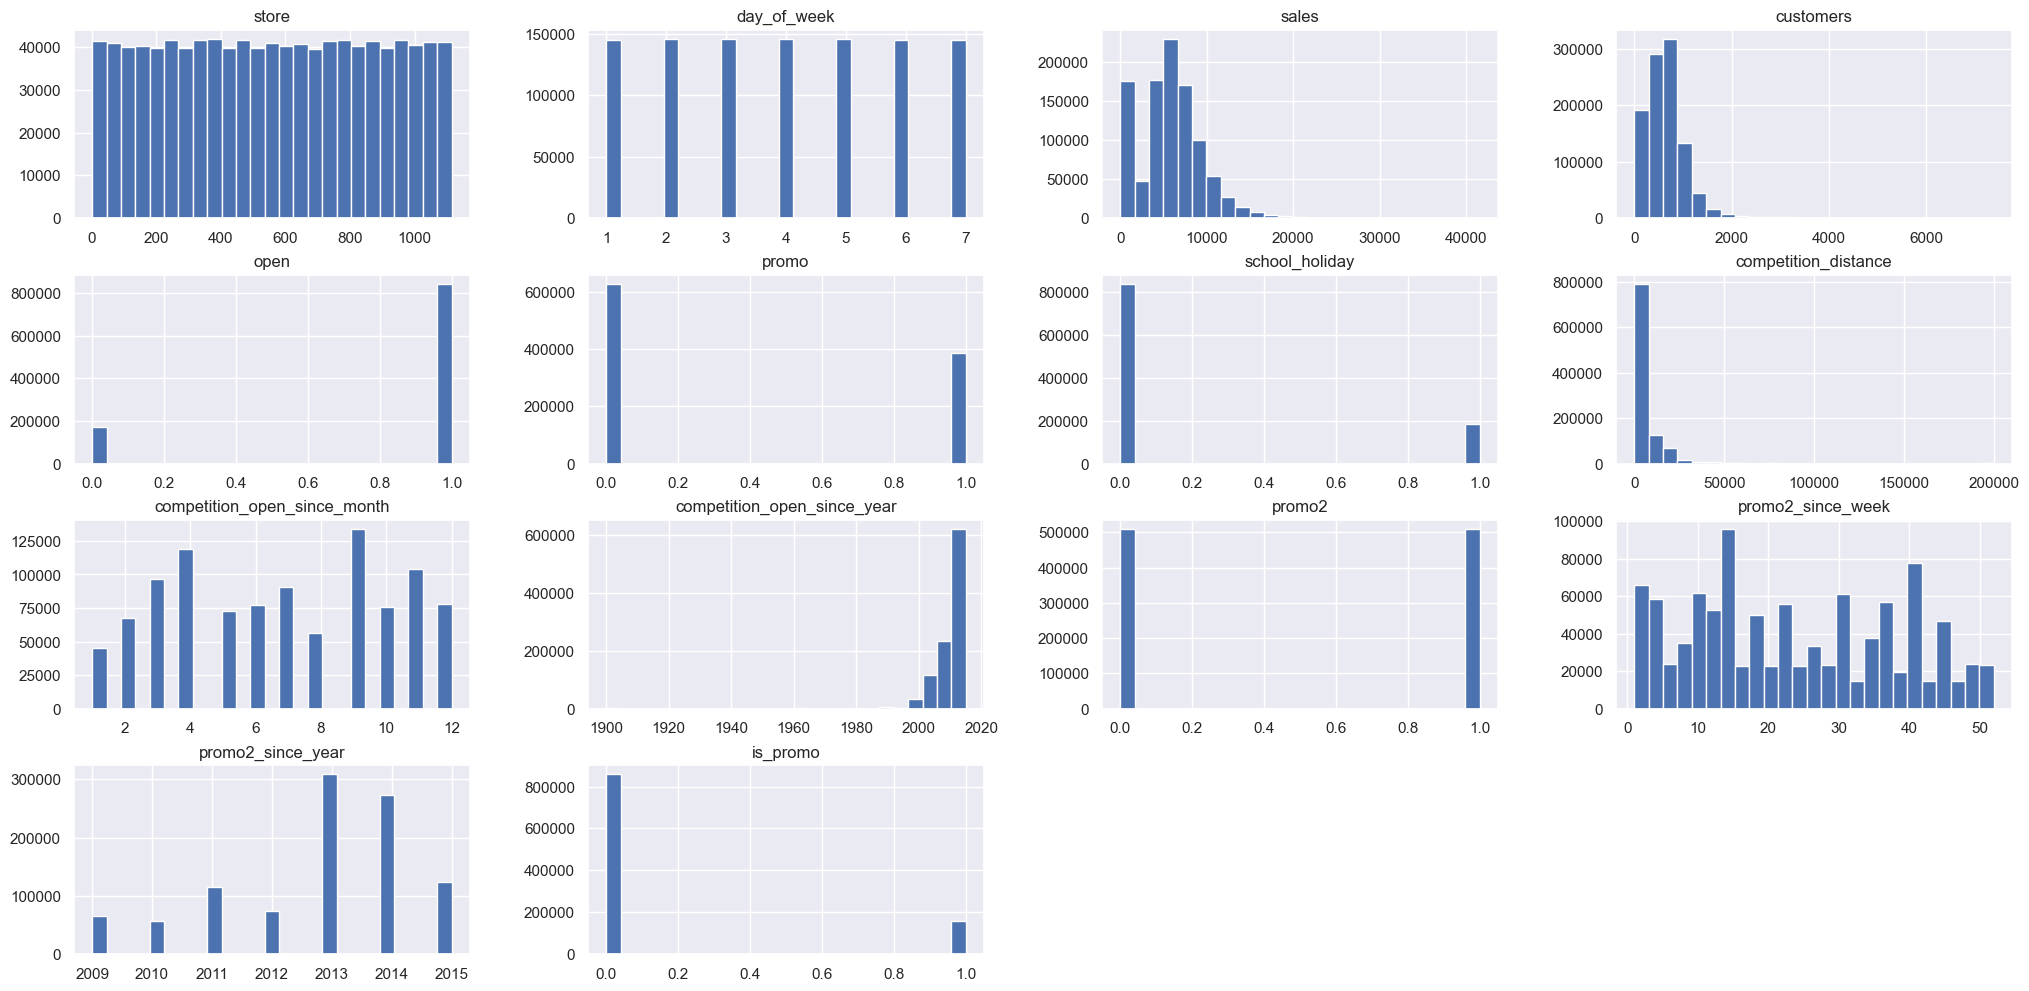

In [39]:
num_attributes.hist( bins=25 );

 sales -> skew neg (0 - 20000)
 
 customers -> skew neg (0 -2000)
 
 competition_open_since_year ->  skew neg (2000 2020)
 
 promo2_since_year -> [2013(max), 2014, 2015(min)]

 ## 4.1.3 Categorical Variable

In [40]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

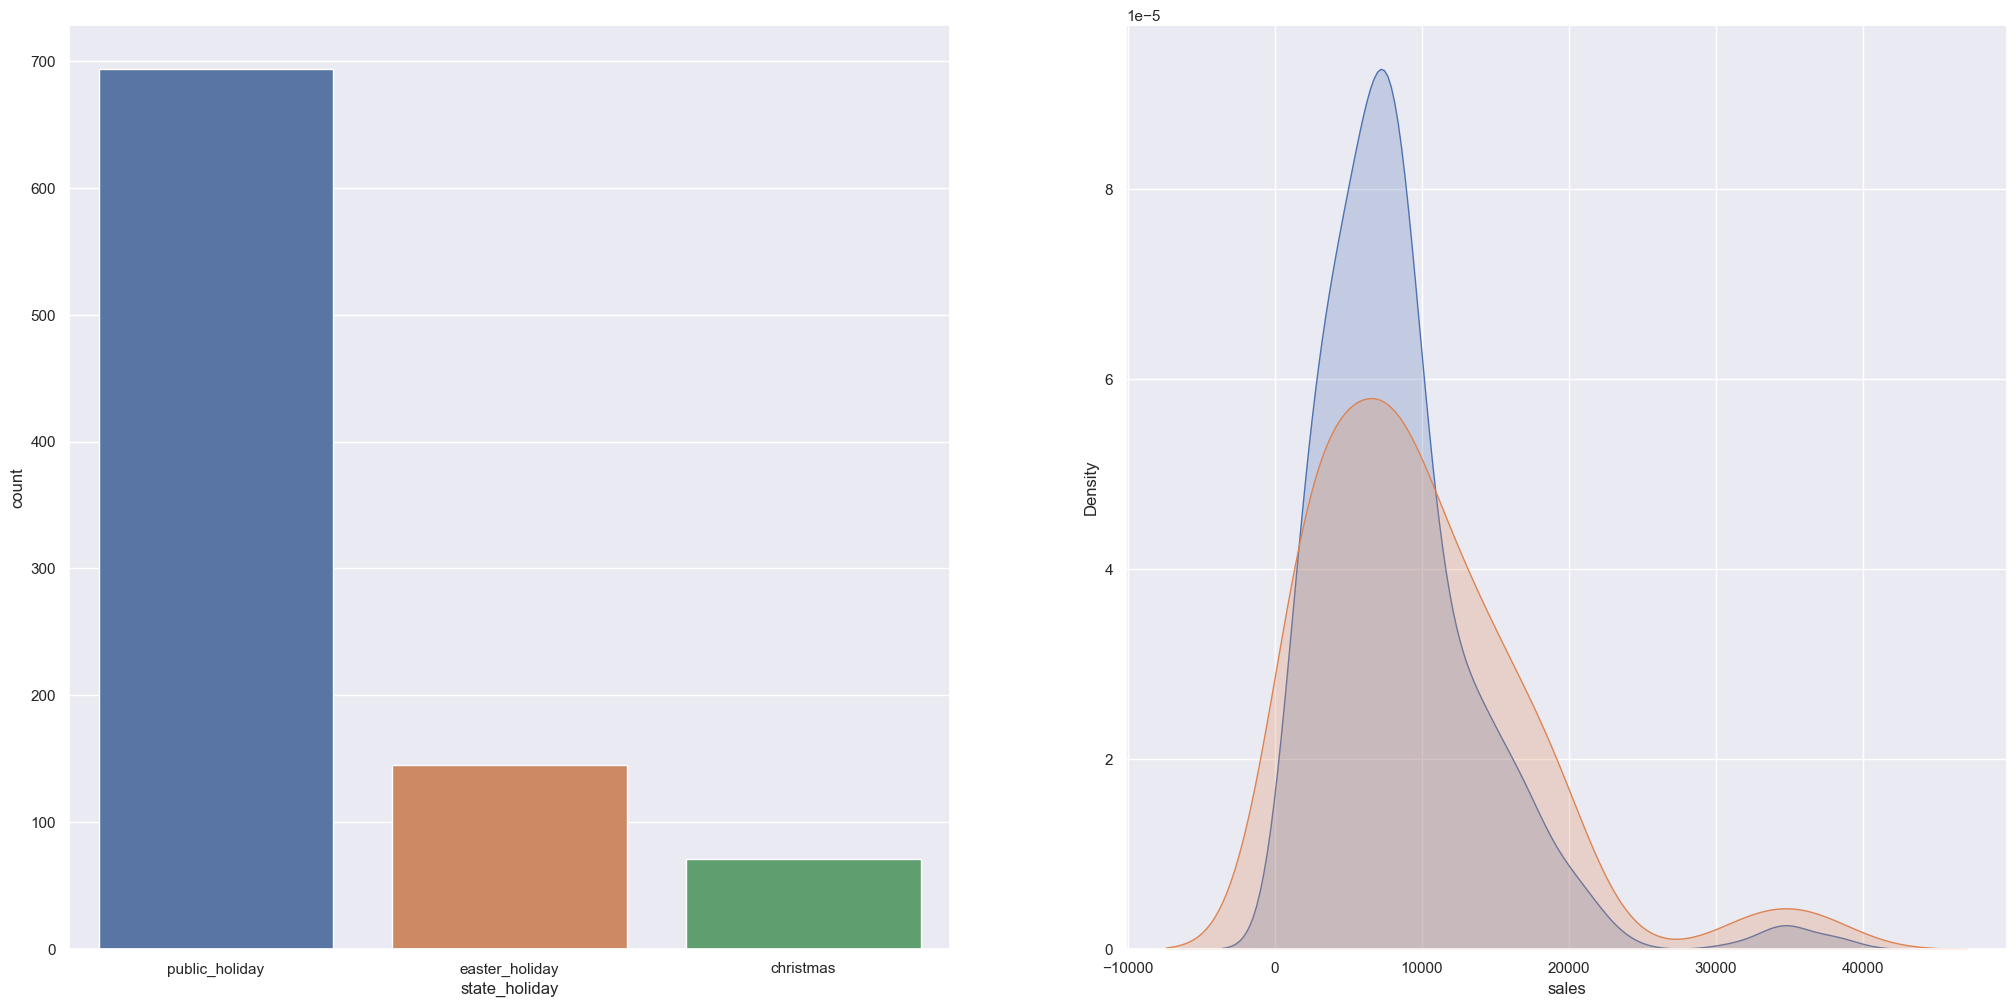

In [42]:
# state_holiday

# regular_day filter to clean graphic
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]

plt.subplot( 1, 2, 1 )
sns.countplot( data = a, x ='state_holiday' );

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',    fill=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'chrstimas_holiday']['sales'], label='chrstimas_holiday', fill=True )

<AxesSubplot:xlabel='sales', ylabel='Density'>

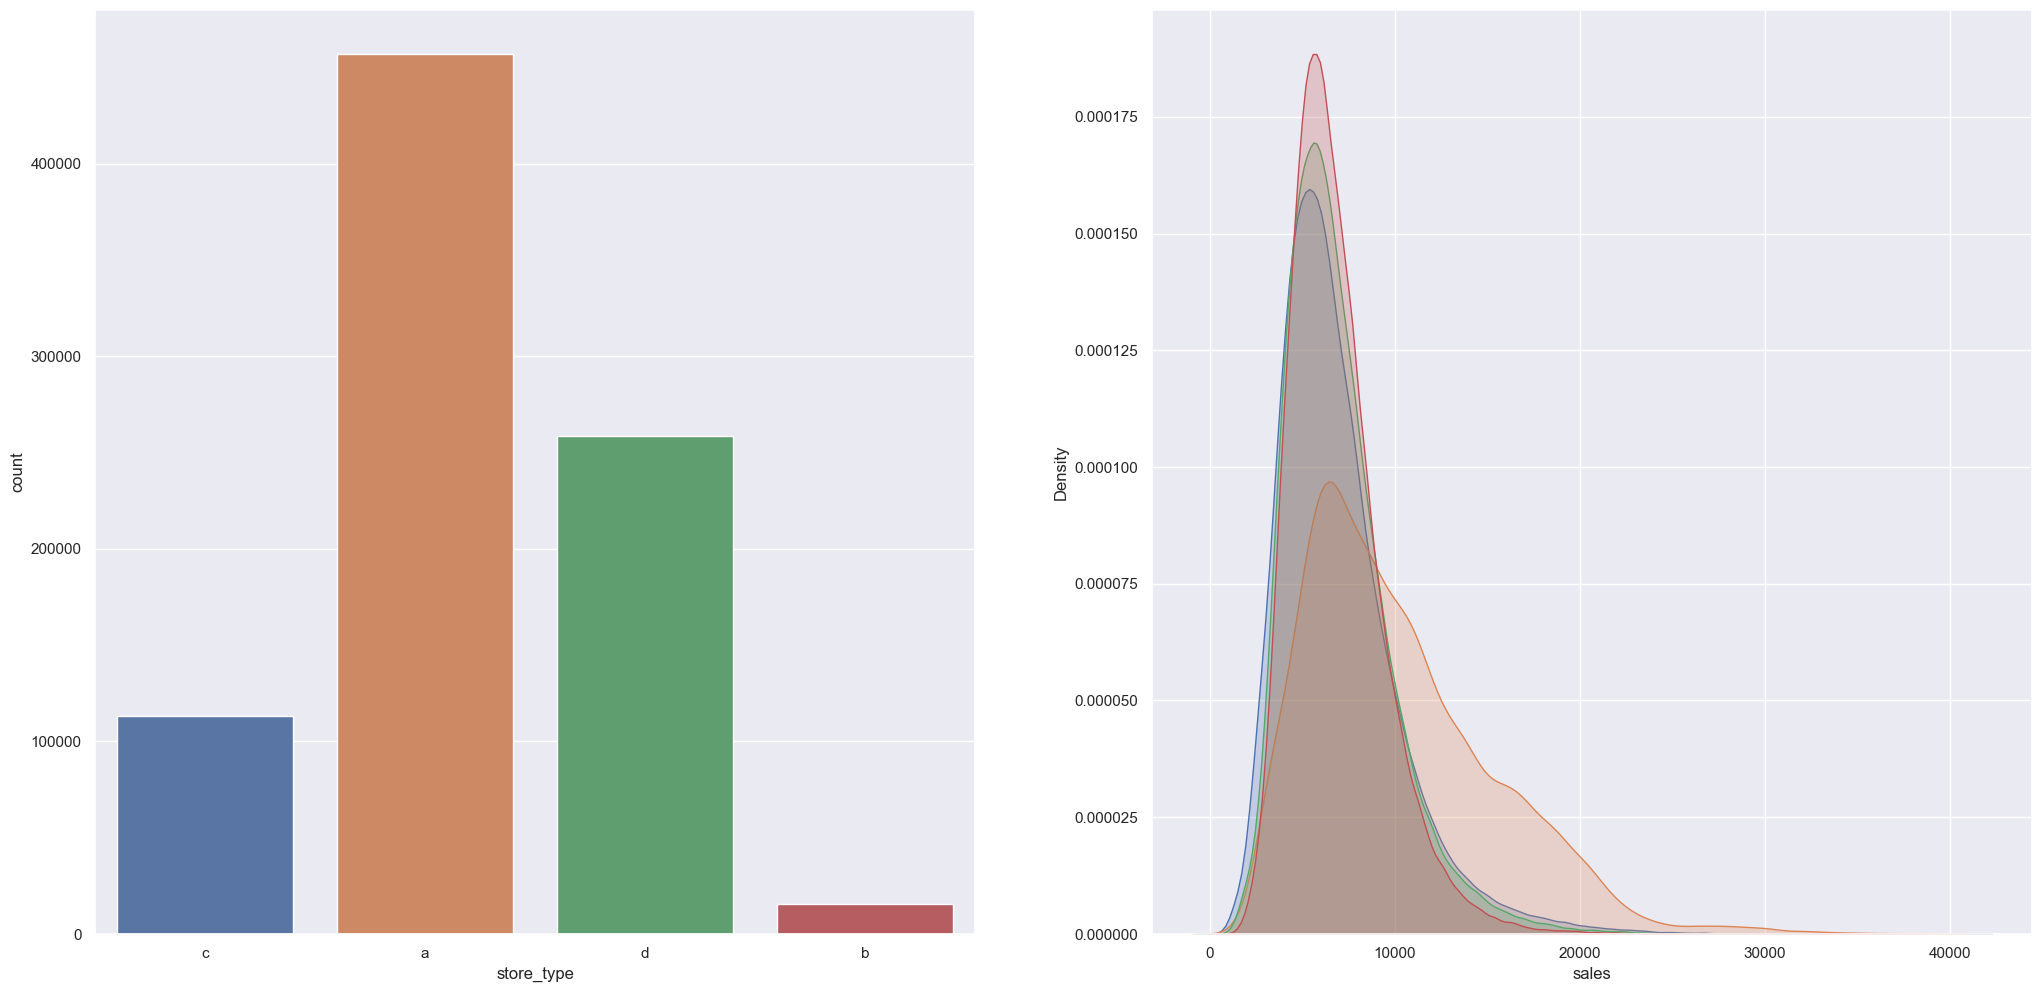

In [43]:
# store_type
plt.subplot( 1, 2, 1 )
sns.countplot( data = df4, x ='store_type' );

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d',fill=True )

<AxesSubplot:>

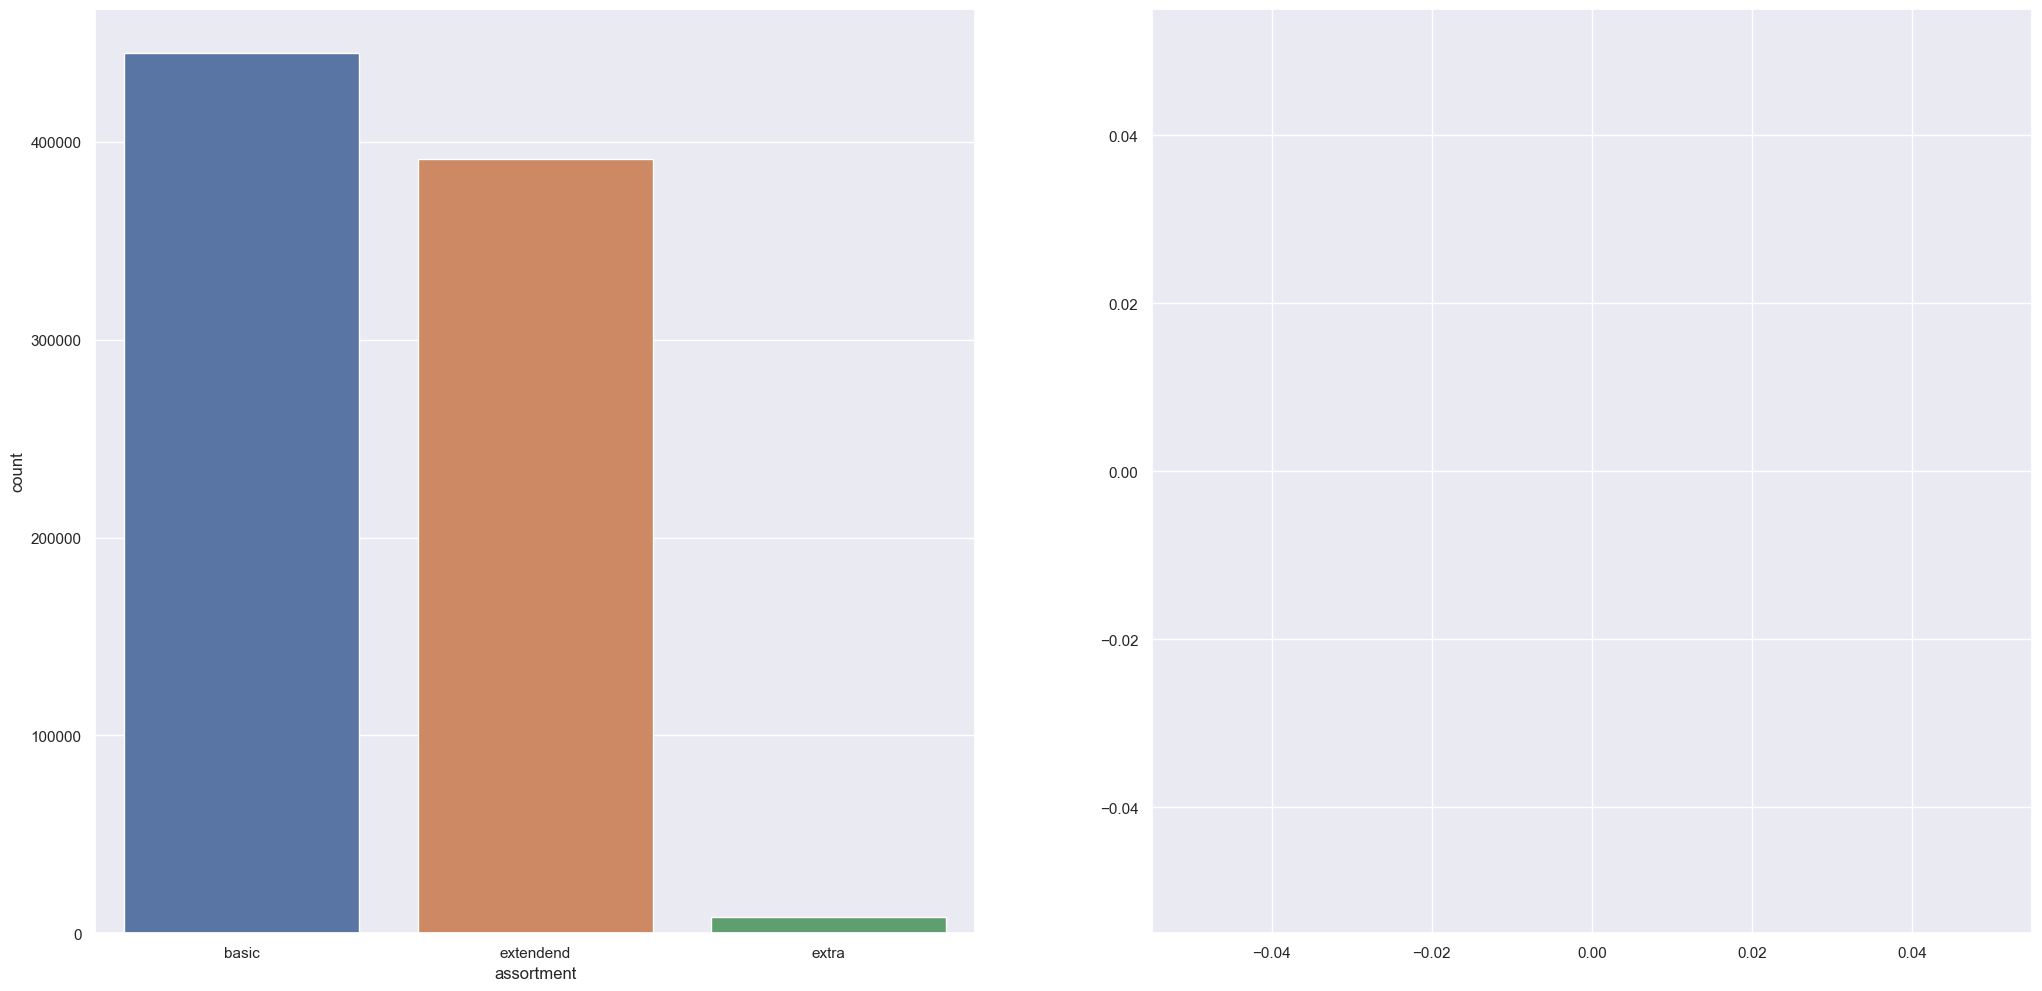

In [44]:
# assortment
plt.subplot( 1, 2, 1 )
sns.countplot( data = df4, x ='assortment' );

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['assortment'] =='a']['sales'],label='basic',fill=True )
sns.kdeplot( df4[ df4['assortment'] =='b']['sales'],label='extra',fill=True )
sns.kdeplot( df4[ df4['assortment'] =='c']['sales'],label='extendend',fill=True )

# 4.1 Bivariate Analysis

### H1. Lojas com maior sortimentos deveriam vender mais:
**FALSA** Lojas com MAIOR SORTMENTO vendem MENOS.

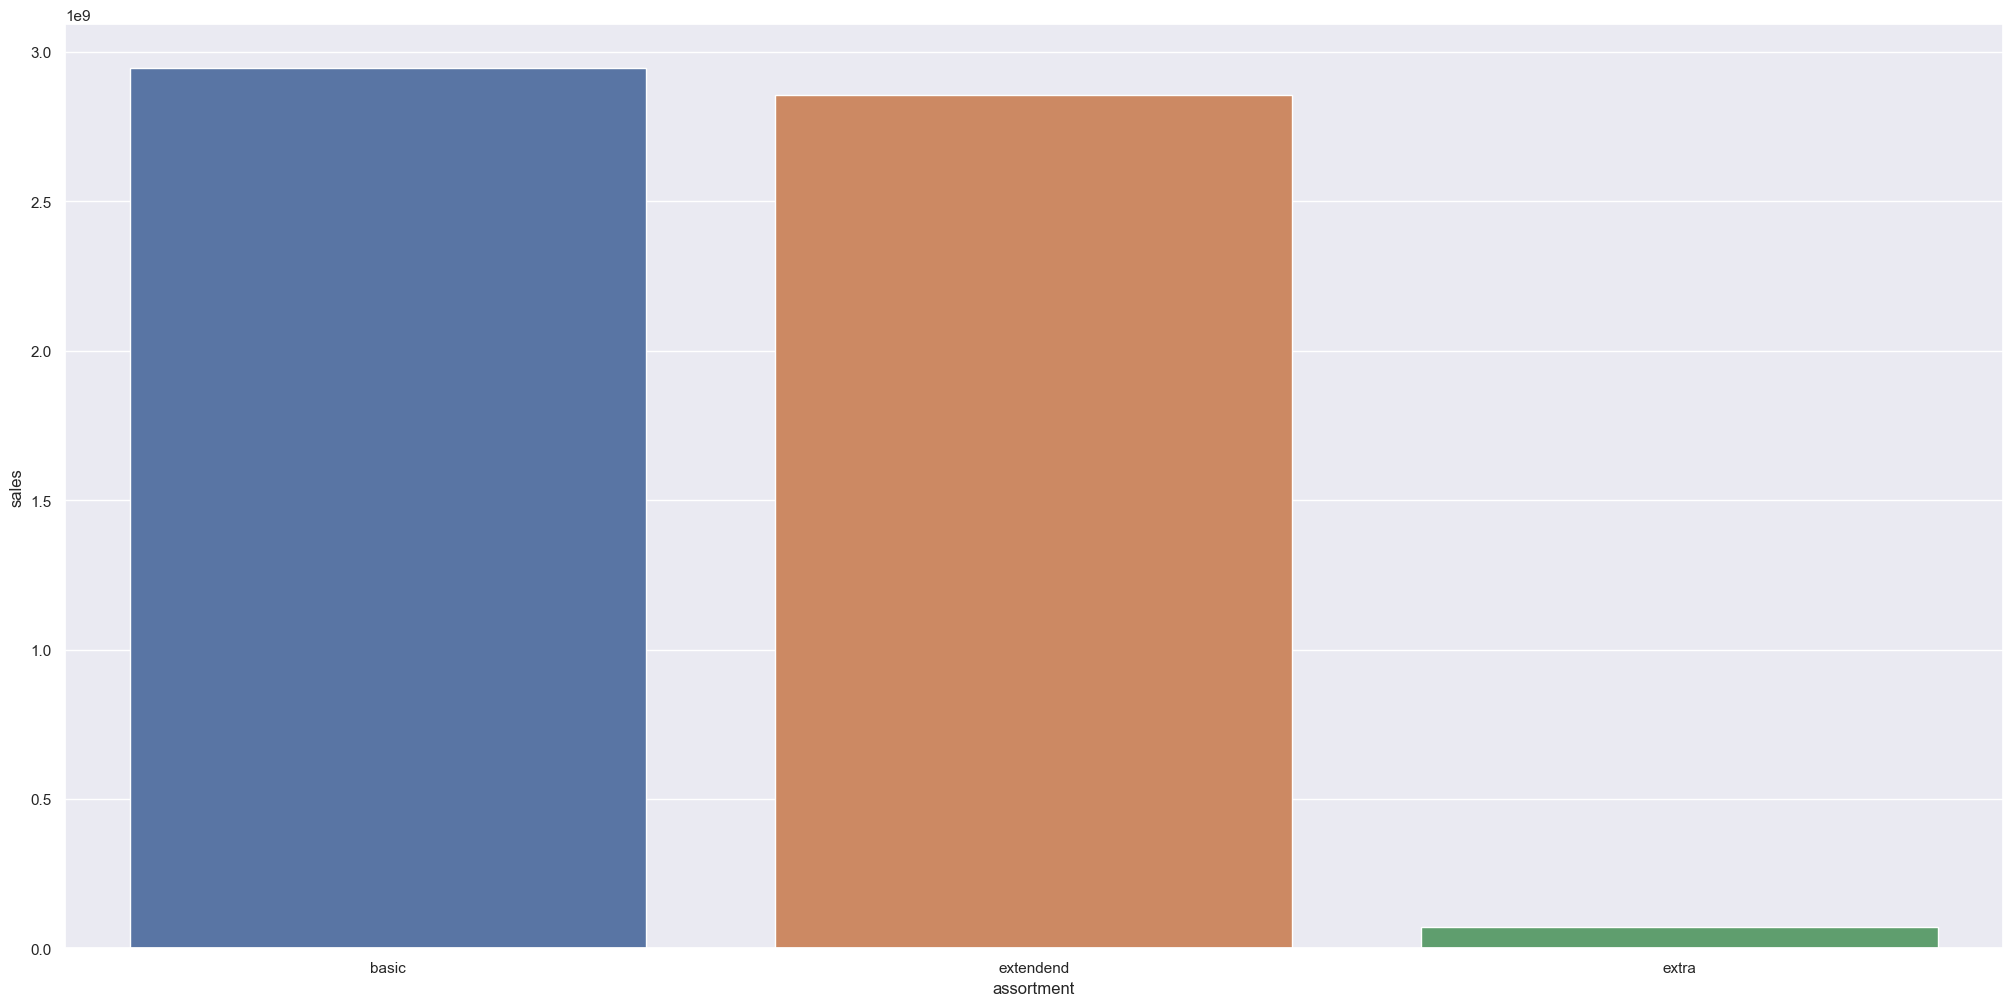

In [45]:
# with assortment and sales try analysis kind of sales those assortment type

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y='sales', data = aux1 );

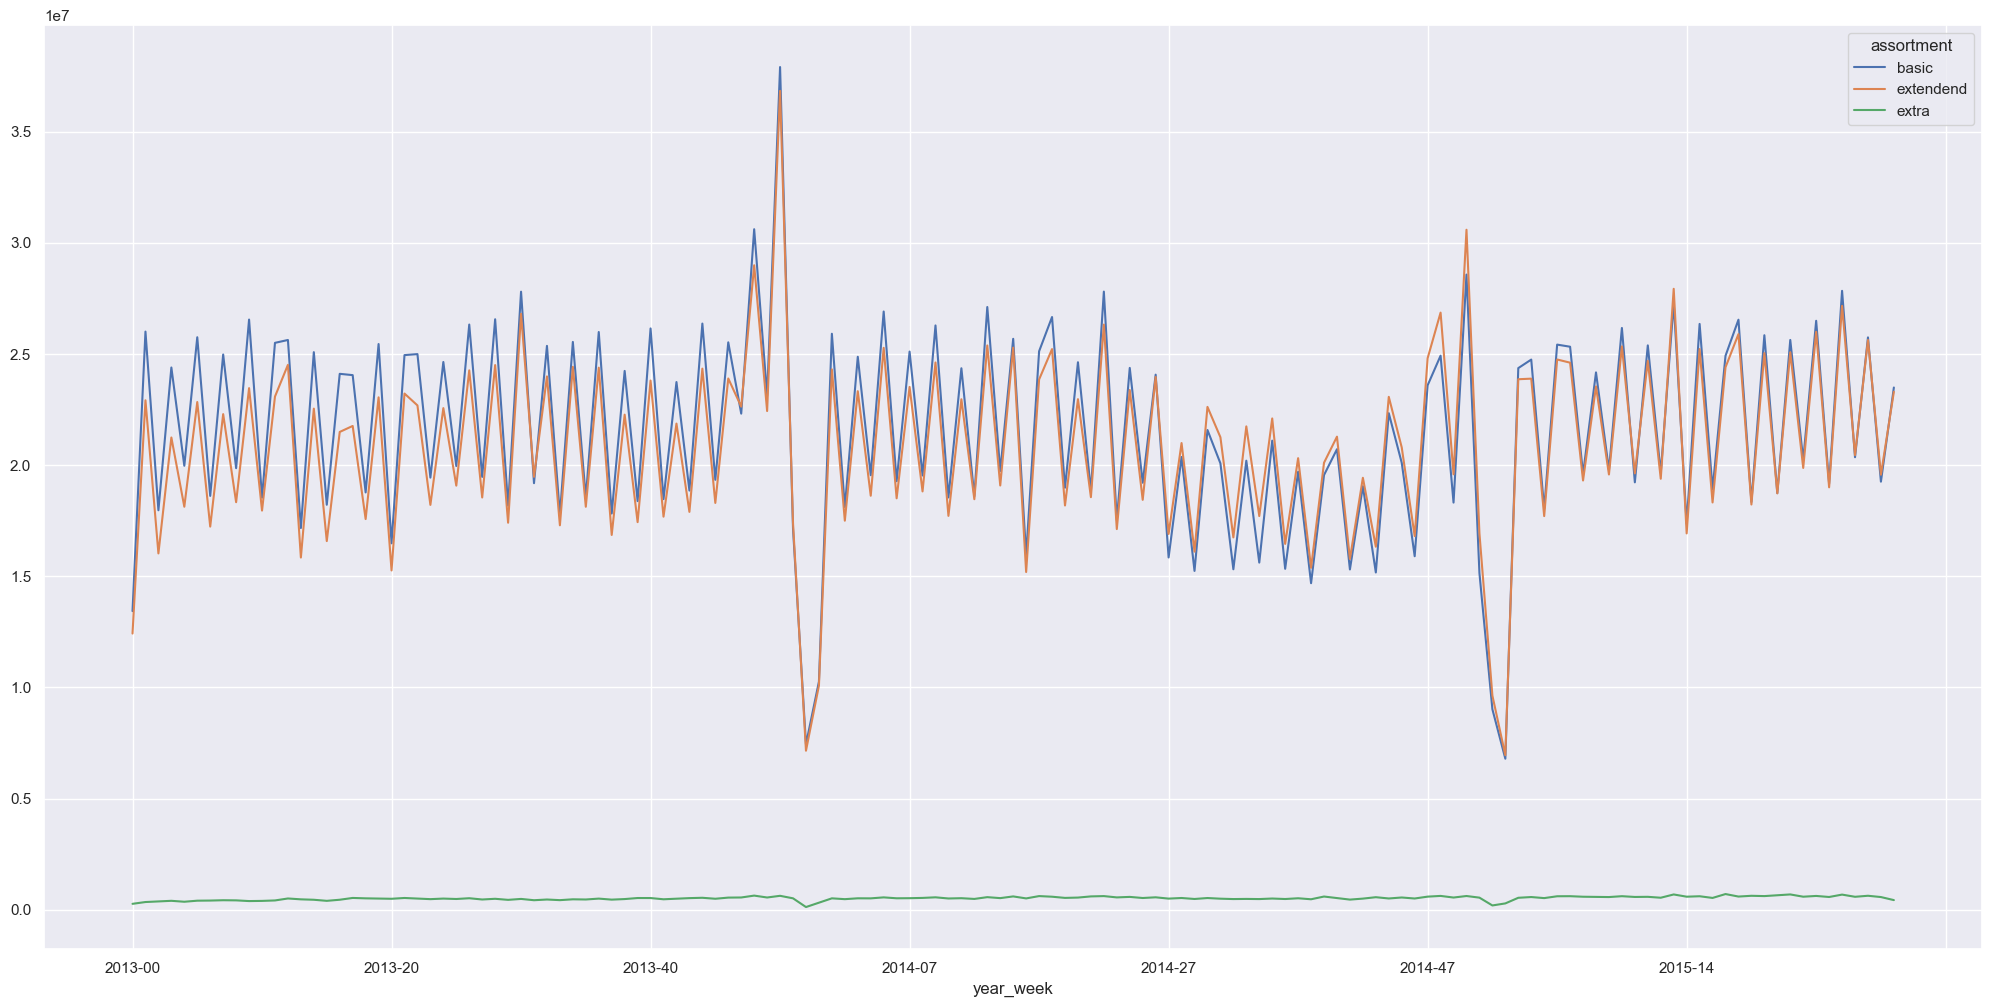

In [46]:
# Assortment variable analysis at time tendency

aux2 = df4[['assortment', 'sales', 'year_week']].groupby( [ 'year_week', 'assortment' ] ).sum().reset_index()
aux2.pivot( index = 'year_week', columns ='assortment', values ='sales' ).plot();

#==============
# insights 01
#==============
# basic and extended looks like similar and extra assortment are totally back to other class

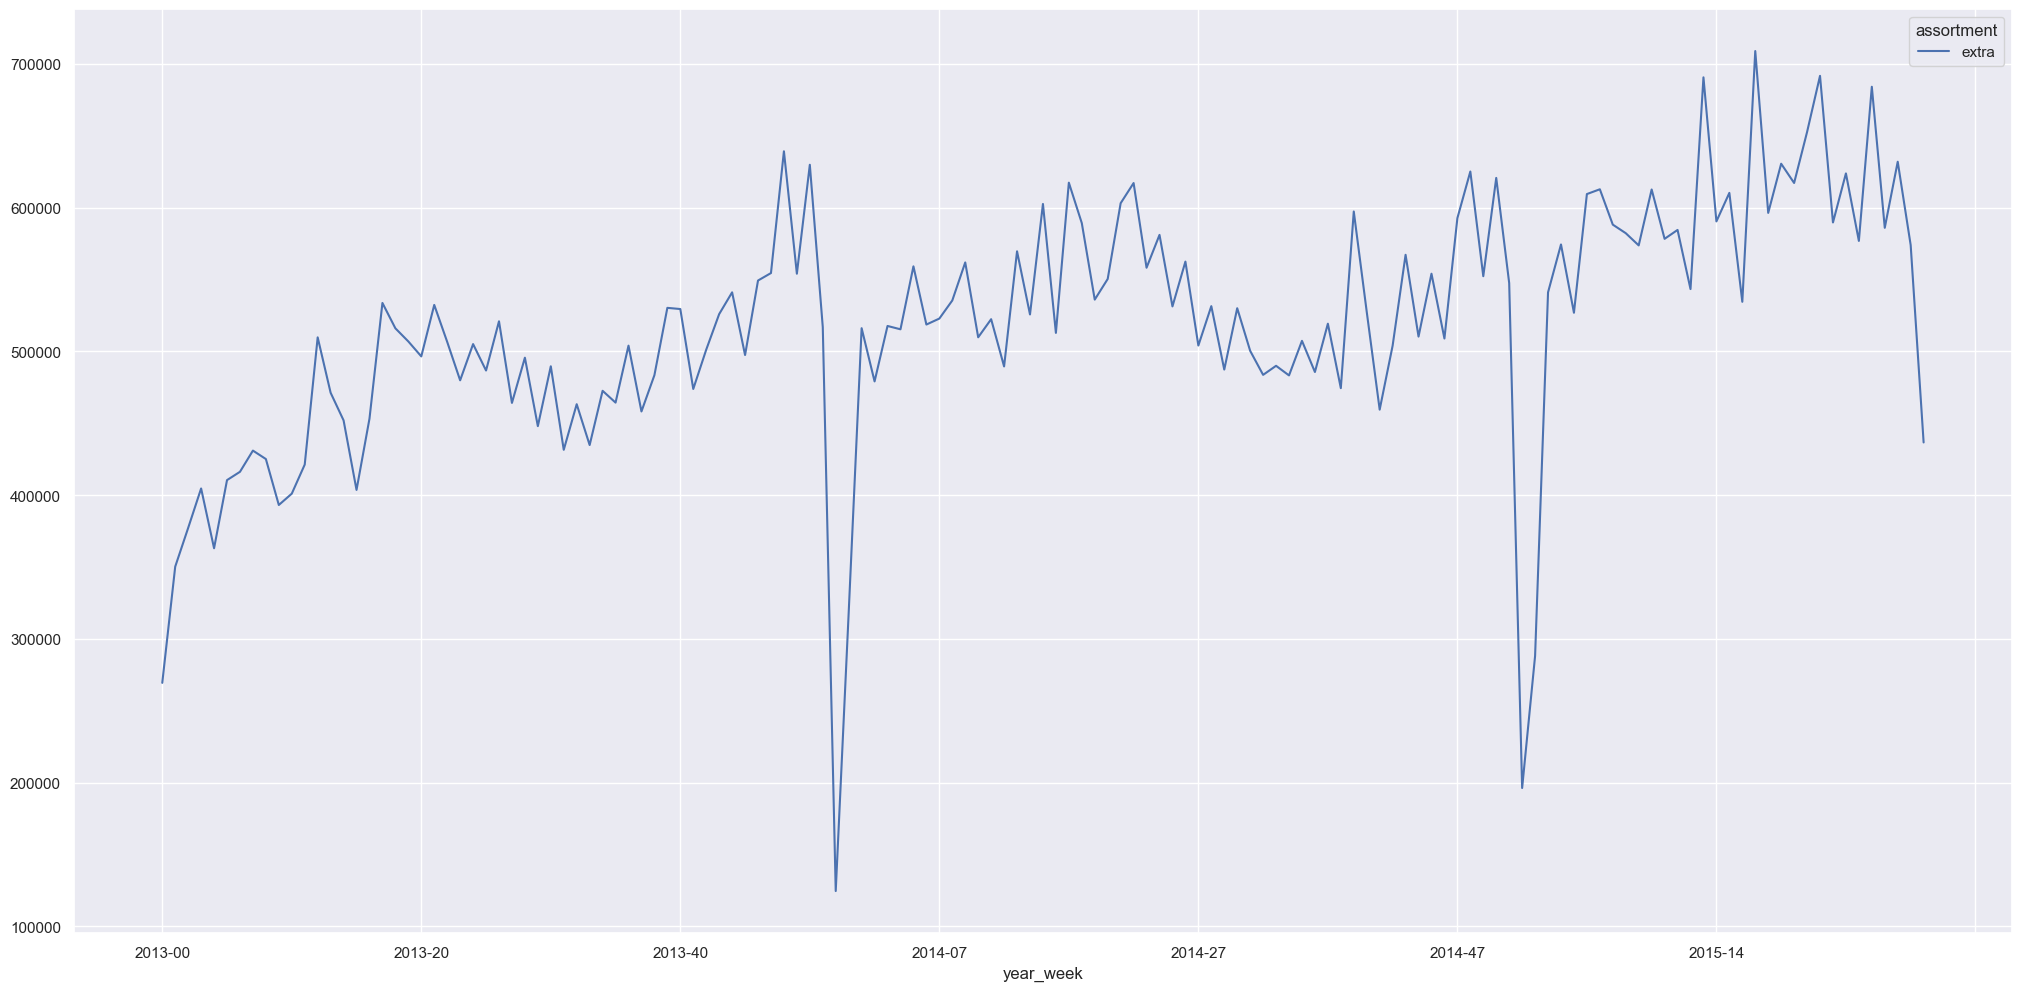

In [47]:
aux3 = aux2[ aux2['assortment'] == 'extra' ]
aux3.pivot( index = 'year_week', columns ='assortment', values = 'sales' ).plot();

# extra assortment looks like with some tendency   

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

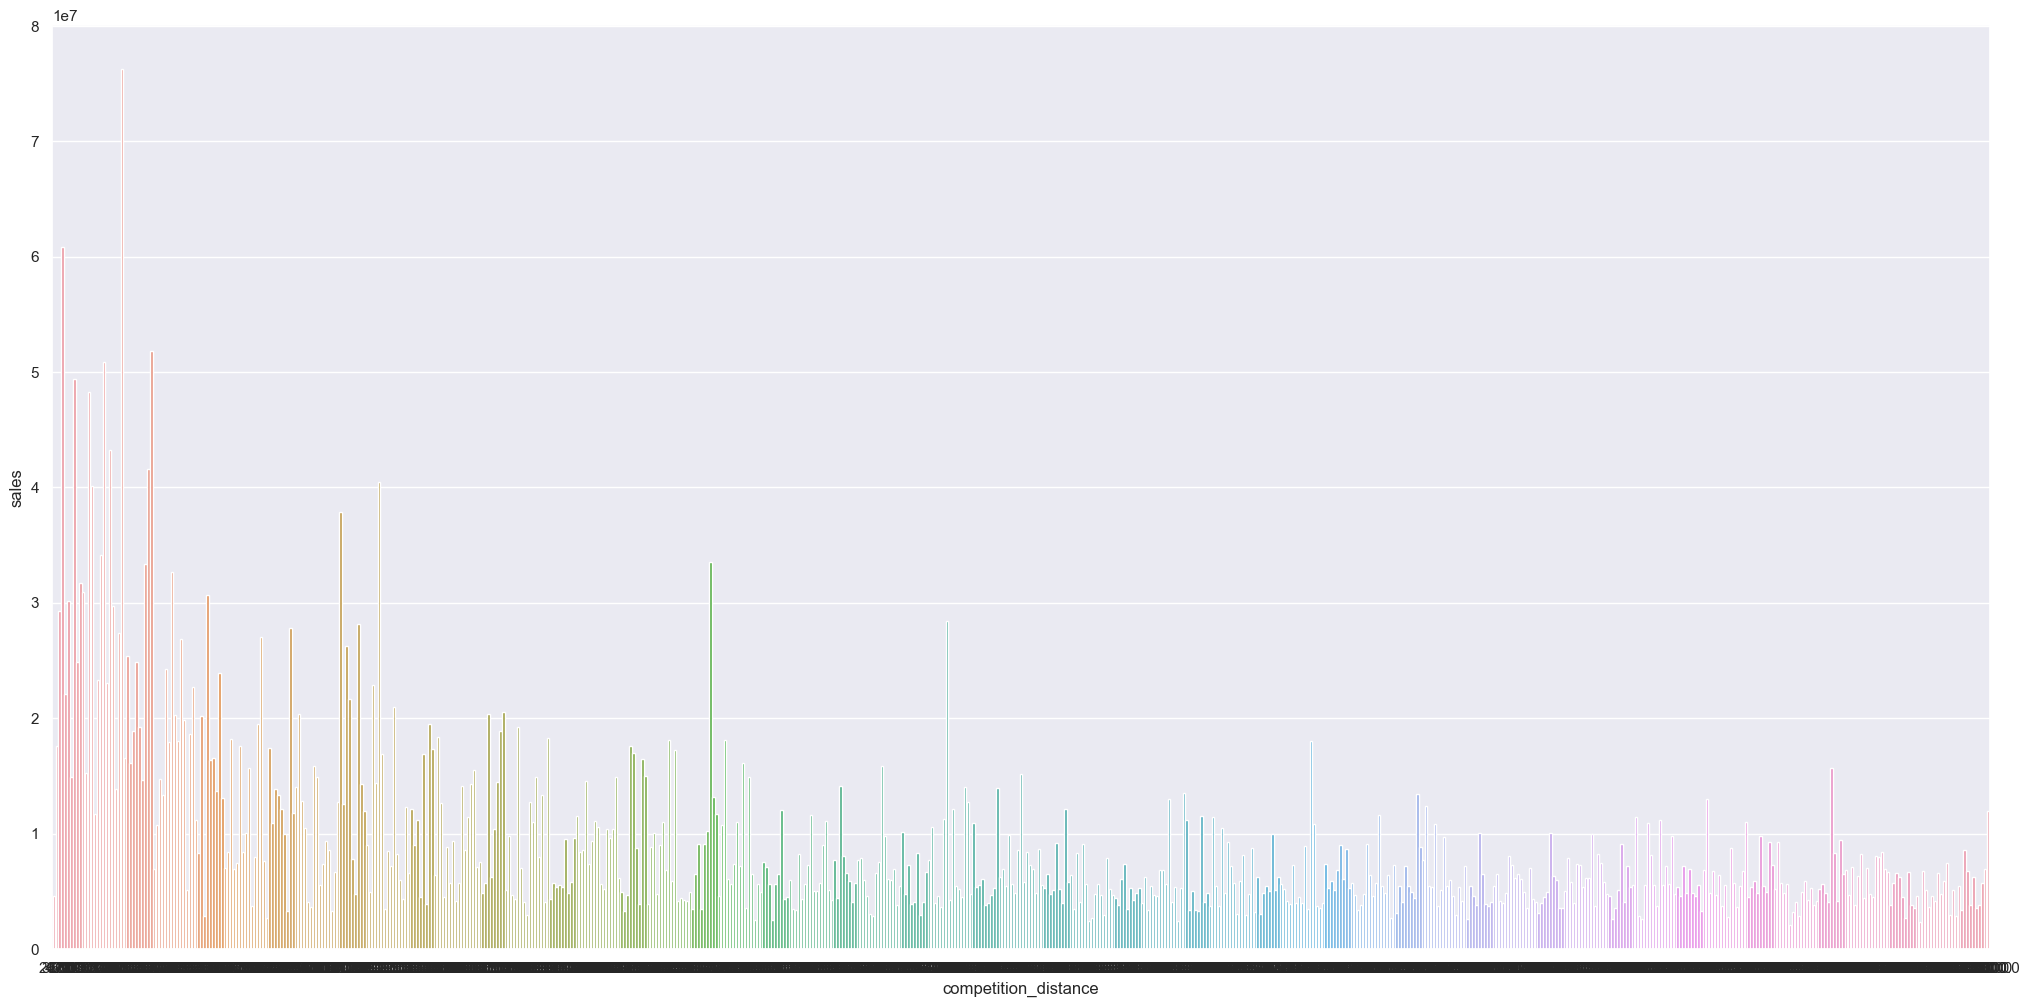

In [48]:
# with competition_distance and sales try to analysis sales to competition_distance

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot( x = 'competition_distance', y = 'sales', data = aux1 );

# any chance to face this analysis

In [49]:
aux1.sample(4)

,competition_distance,sales
510,12070.0,3538417
394,6420.0,3702496
59,610.0,8440859
533,14130.0,5408261


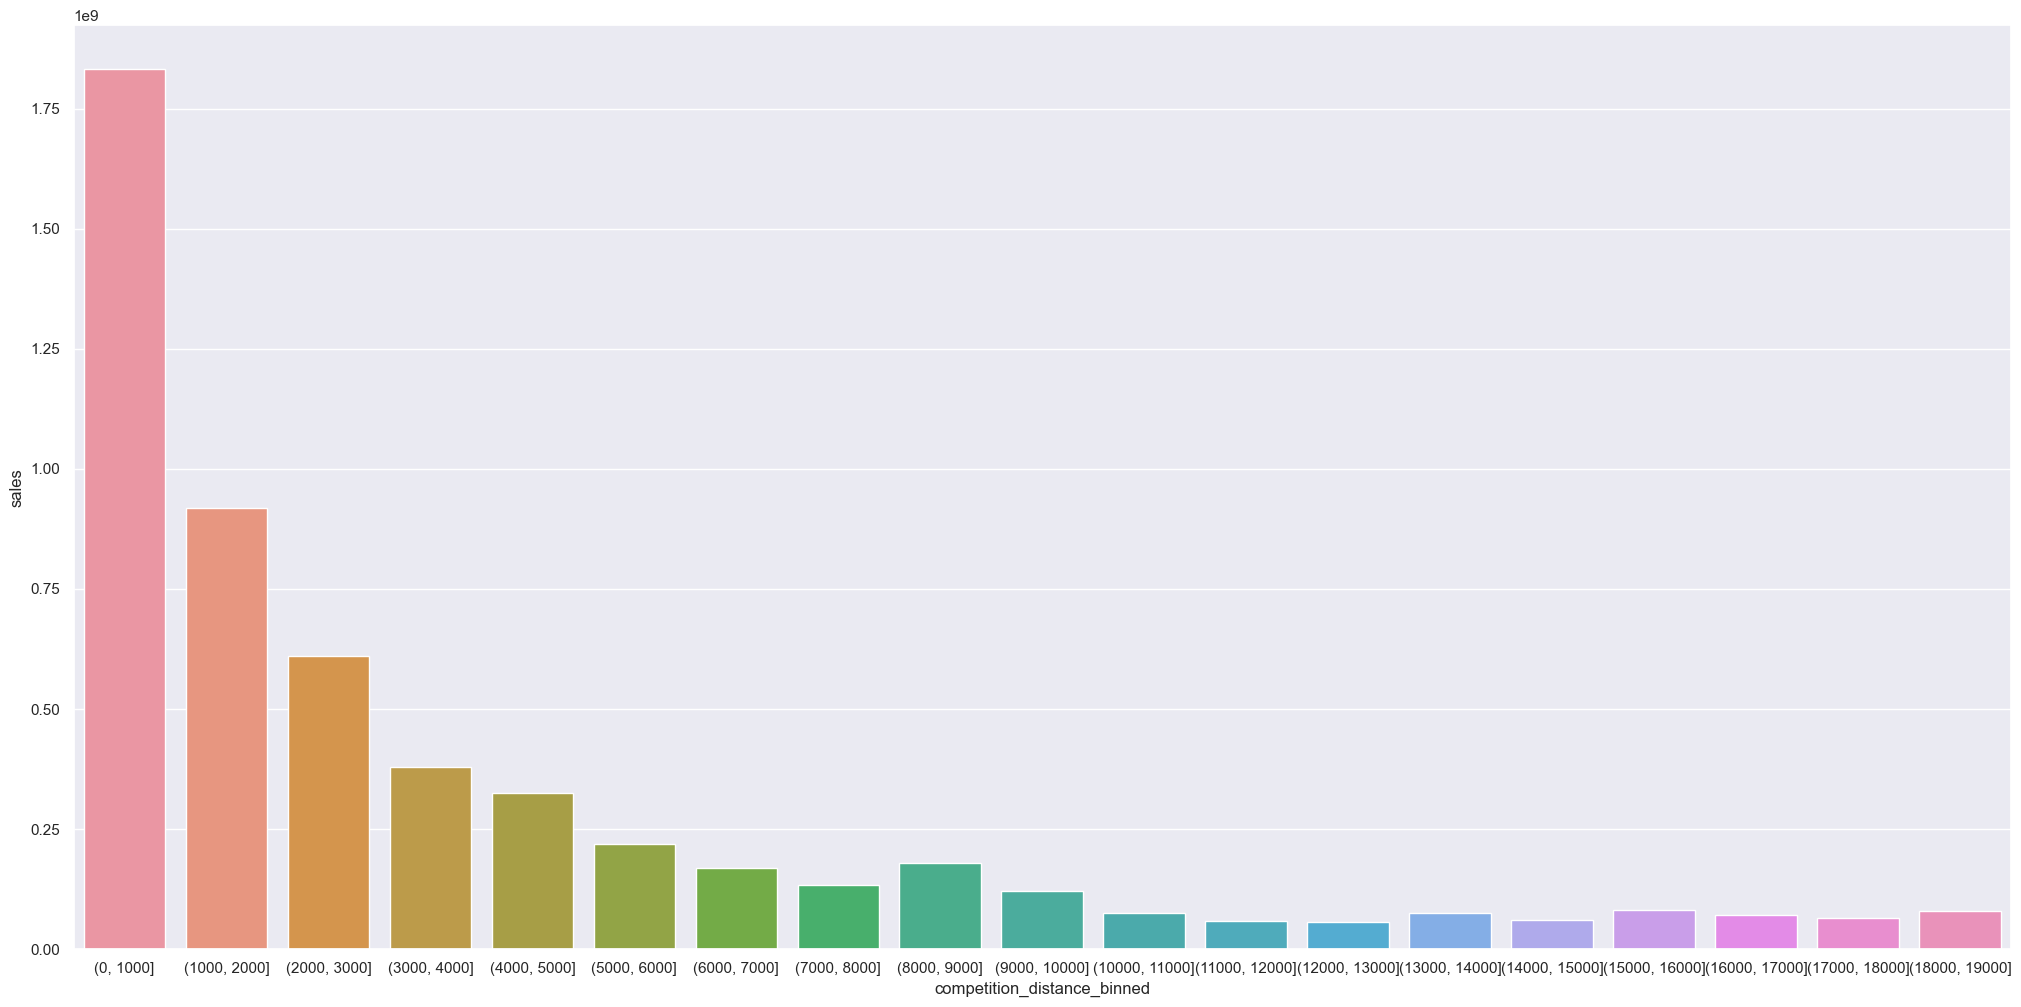

In [50]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# group of users
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

#==============
# insights 02
#==============
# group of stores with close located sales more than farway; could because of competition...checkup next moment.

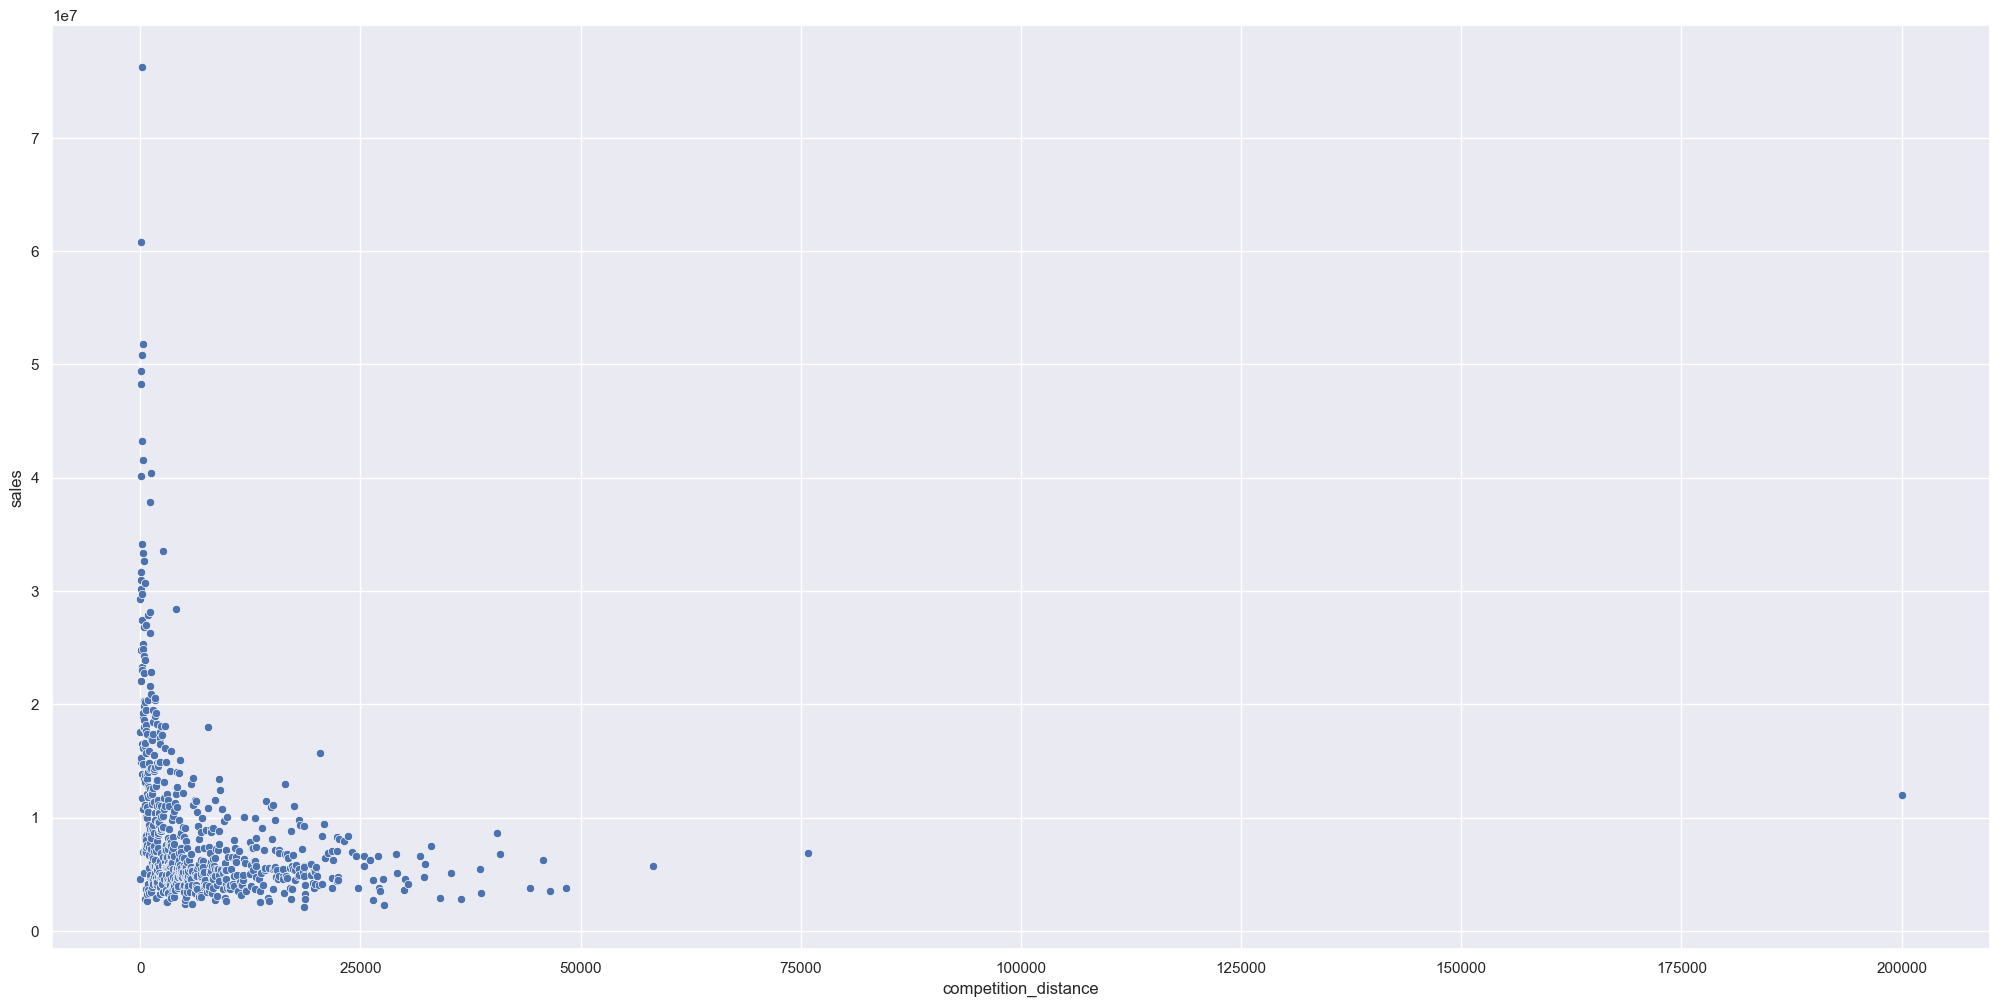

In [51]:
# some data with a lot of granularity we can follow the scatter plot... 

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

/tmp/ipykernel_6749/2650778675.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( aux1.corr( method='pearson' ), annot=True );


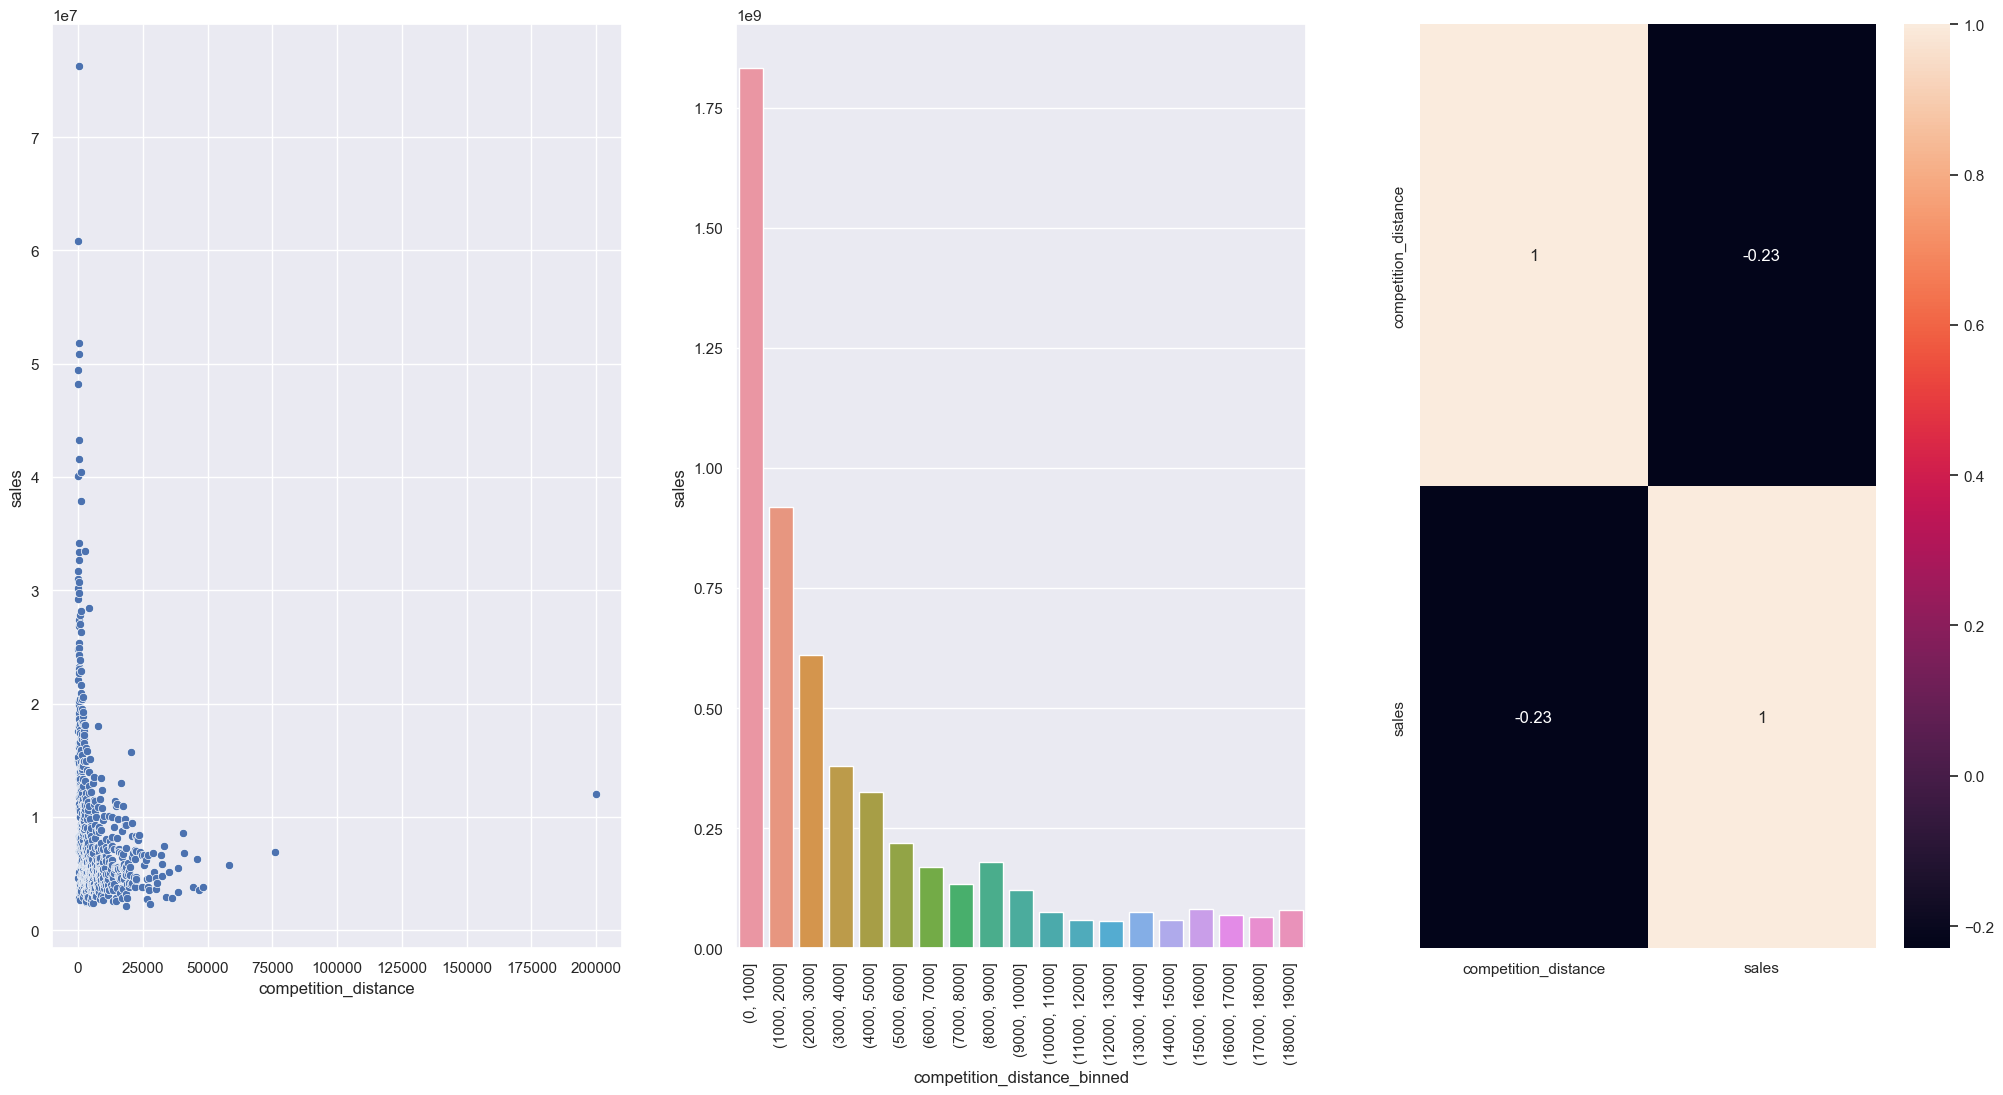

In [52]:
# finally checkup the correlation between competition_distance and sales (-1 -> 1 ); indicated the -0,23 the further away the competitors are the lower the sales...

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Lojas com competidores á mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

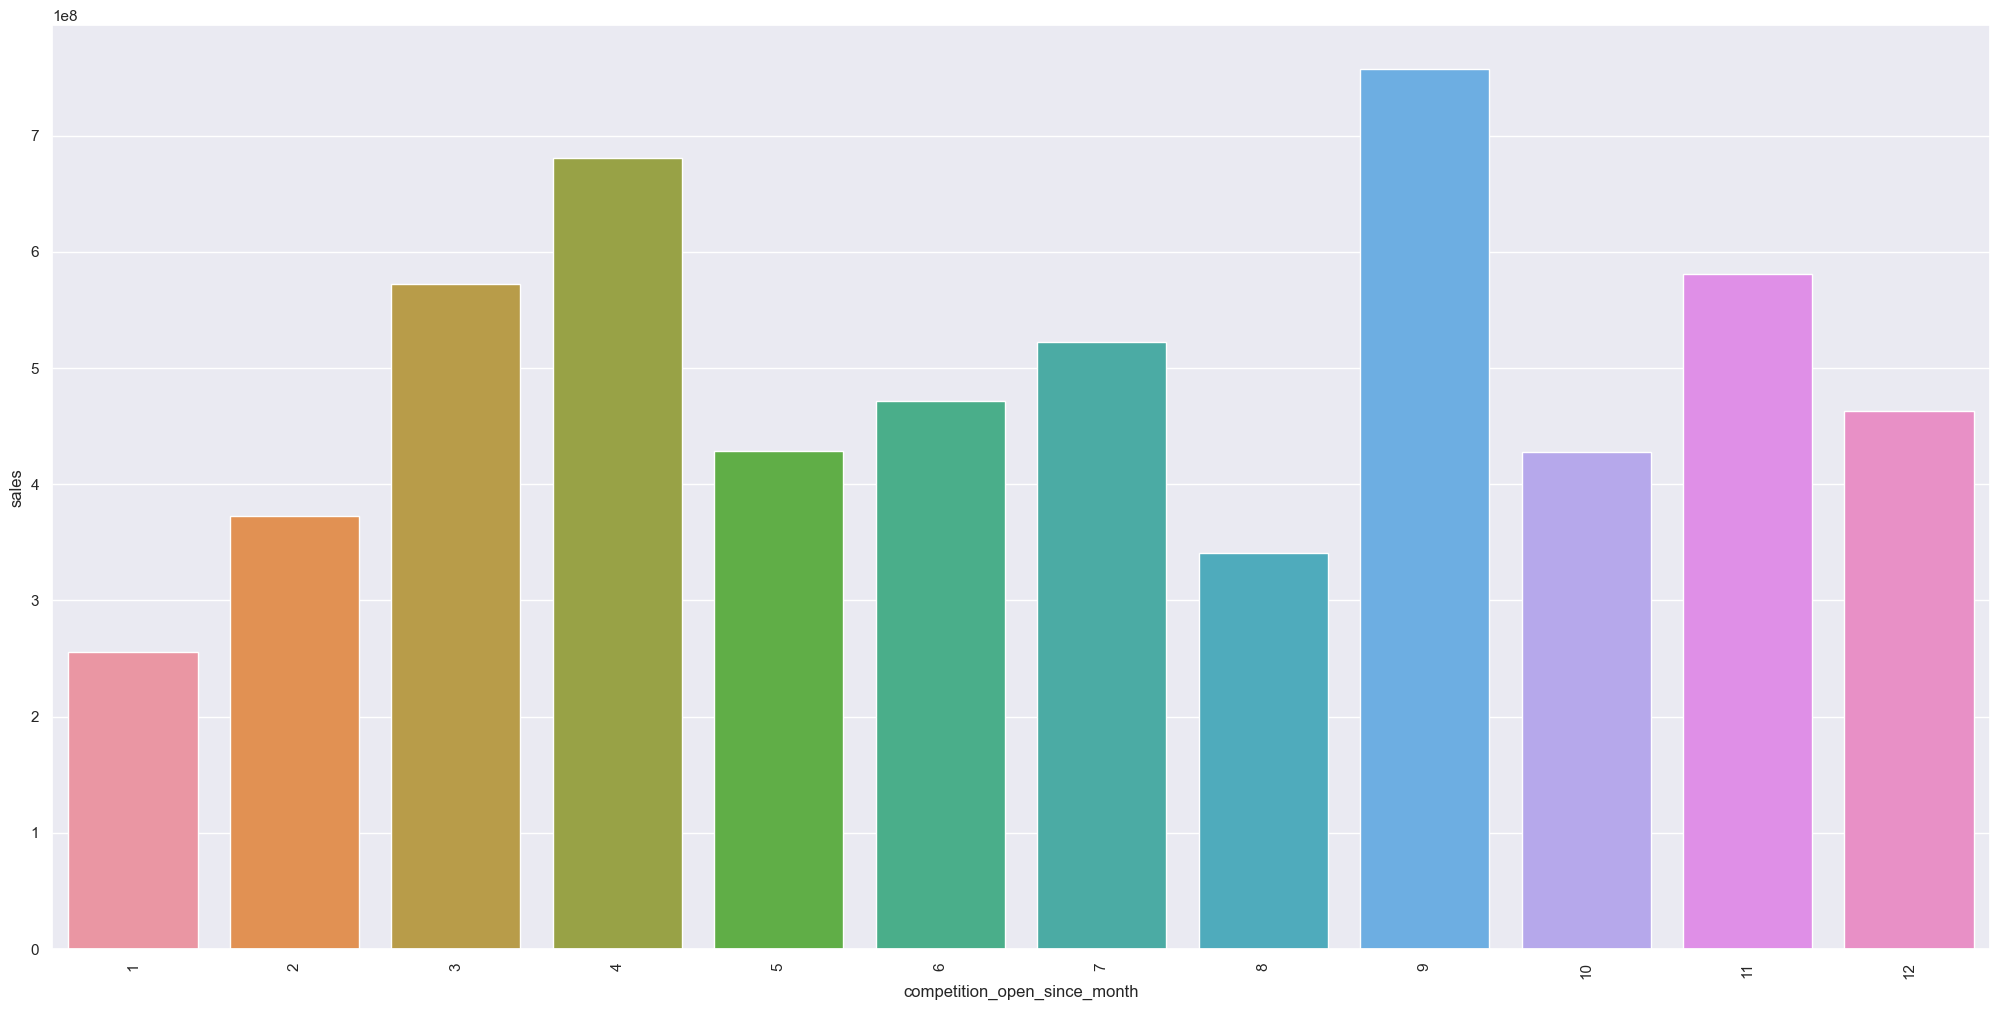

In [53]:
# with 'competition_open_since_month' and 'sales' I tried to analyze the function of time playing competition with each other

aux1 = df4[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()

sns.barplot( x='competition_open_since_month', y='sales', data=aux1 );
plt.xticks( rotation=90);

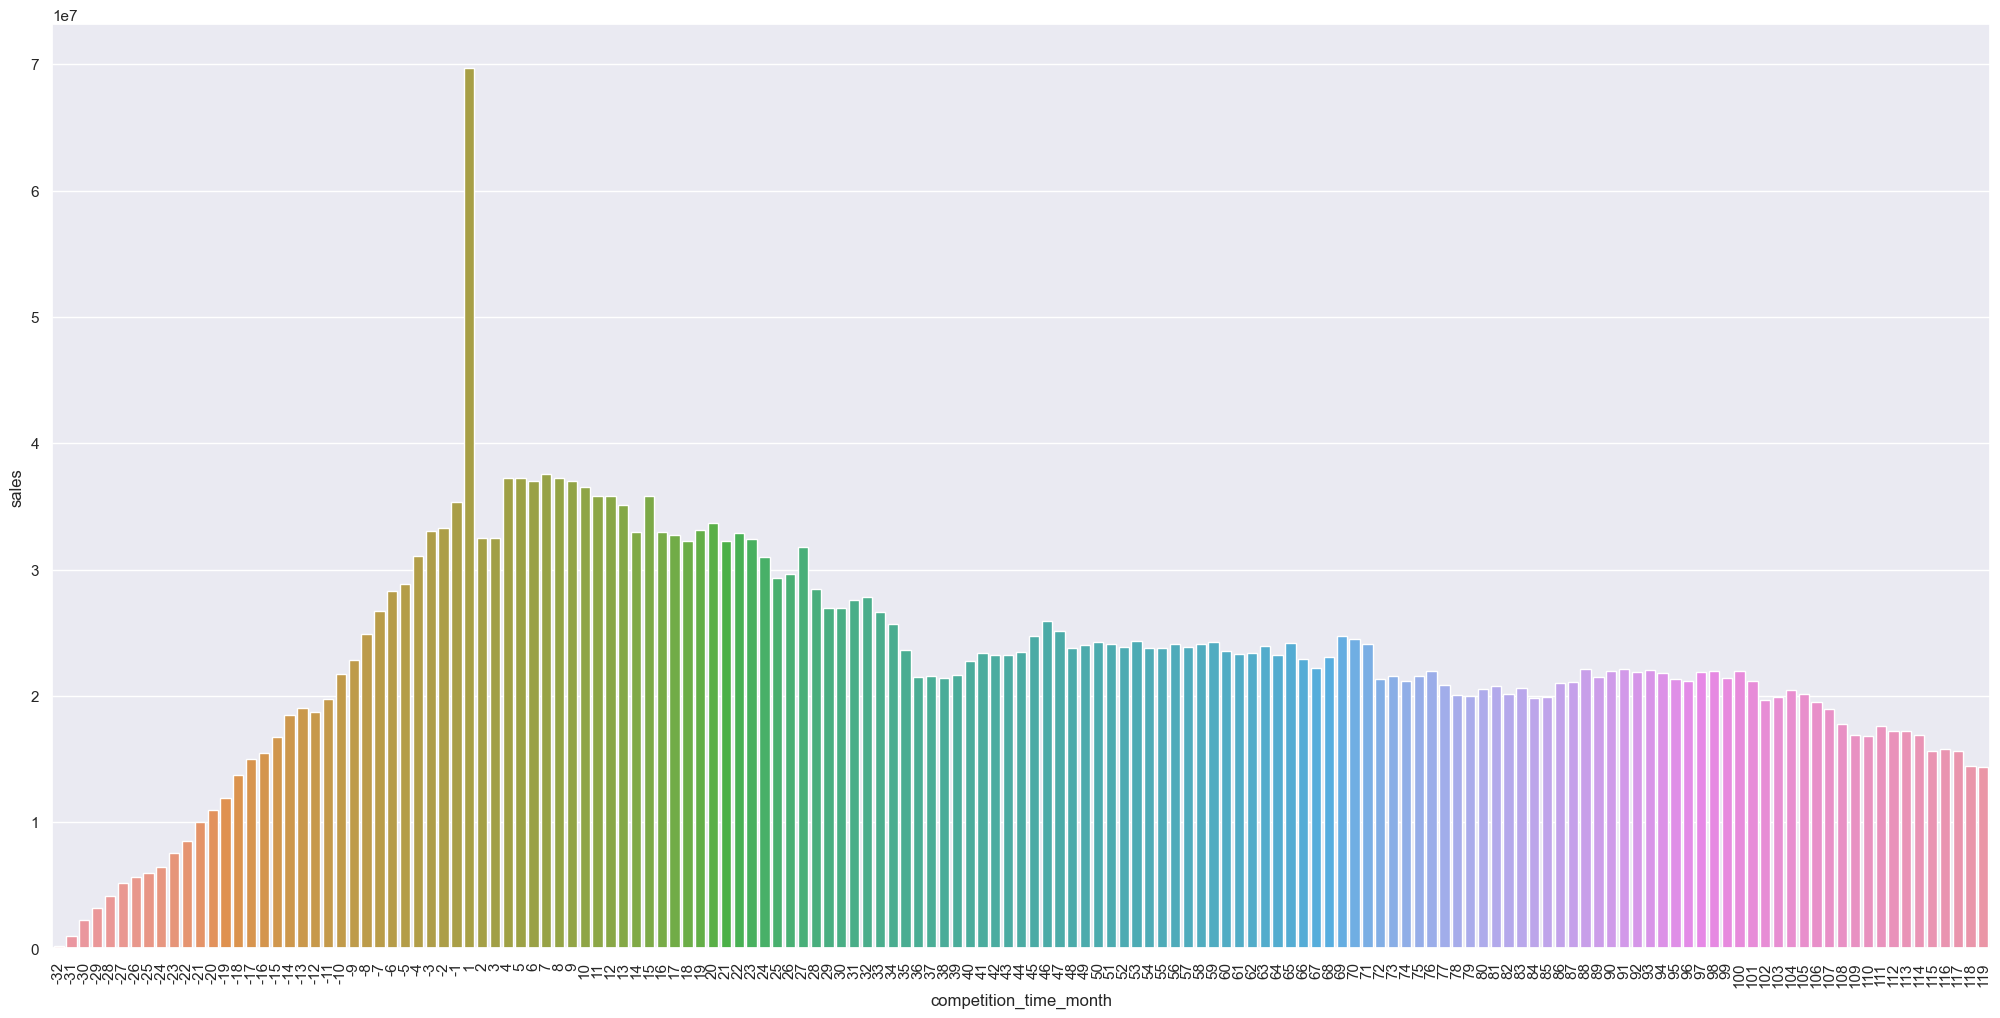

In [54]:
# with 'competition_time_month' and 'sales' figure out the sales tendency

aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

# filter application on competition_time_month and competition_time_month
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );

# rotation on x axis
plt.xticks( rotation=90);

#==============
# insights 03
#==============
# The more recent the competition between the stores the greater the sales

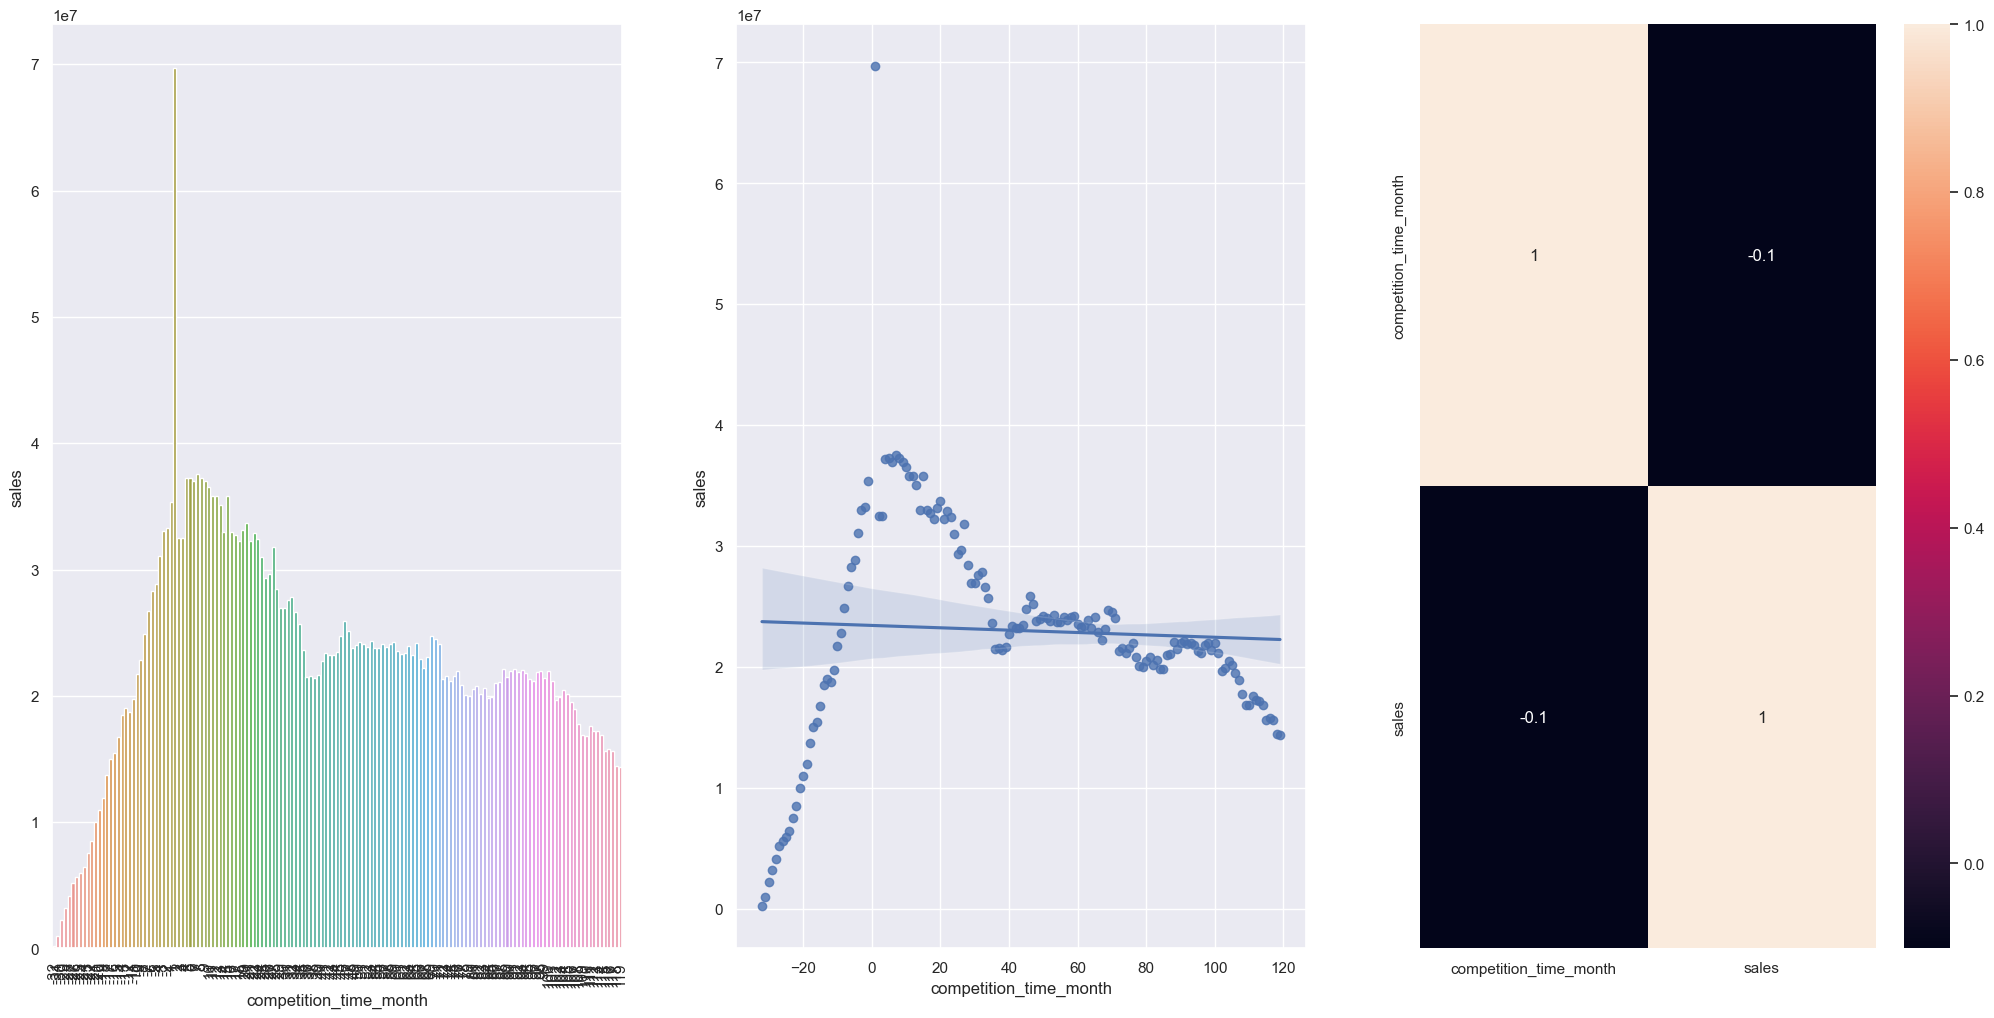

In [55]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

# Finally checkup the correlation between competition_time_month and sales as pearson (-1 -> 1 ); indicated the -0,1  which shows up the more recent the competition between the competitiors the greater are the sales...


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período.

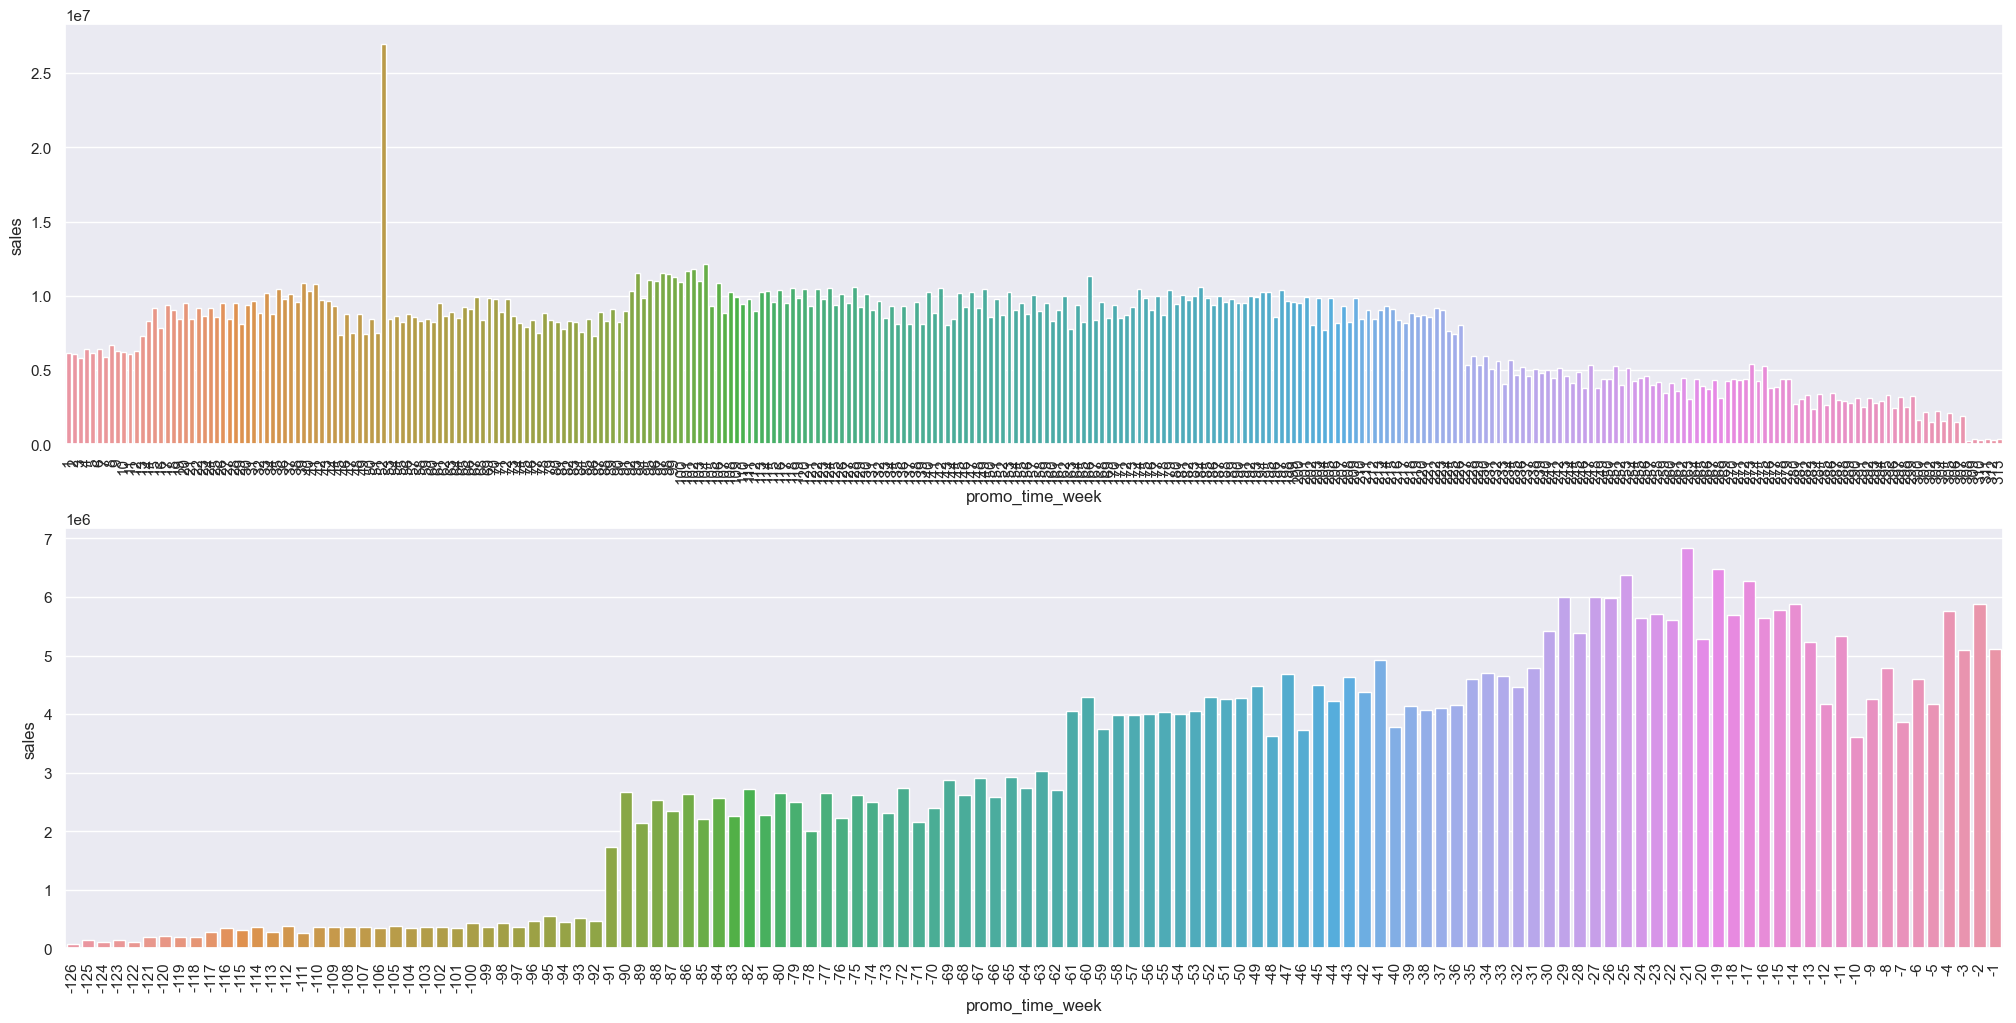

In [56]:
# with a 'promo_time_week' and 'sales' check up the longer promotion time impact lower sales...
# figure out the promo time standard and extended time of promotion moment 
# promo_time_week > 0 its promo extended otherwise standard promotion...

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

sns.barplot( x='promo_time_week', y='sales', data=aux1 );

plt.subplot(2, 1, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendend
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(2, 1, 2)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

#==============
# insights 04
#==============
# promo_time_week shows up works properly until some moment which maintain sales upper to some period, but after promo_time_week goes down and not improve any more....
# the marketing play some influence and can boost sales tendency on the customers we note on jumps of valleys of promo_time_week on plot

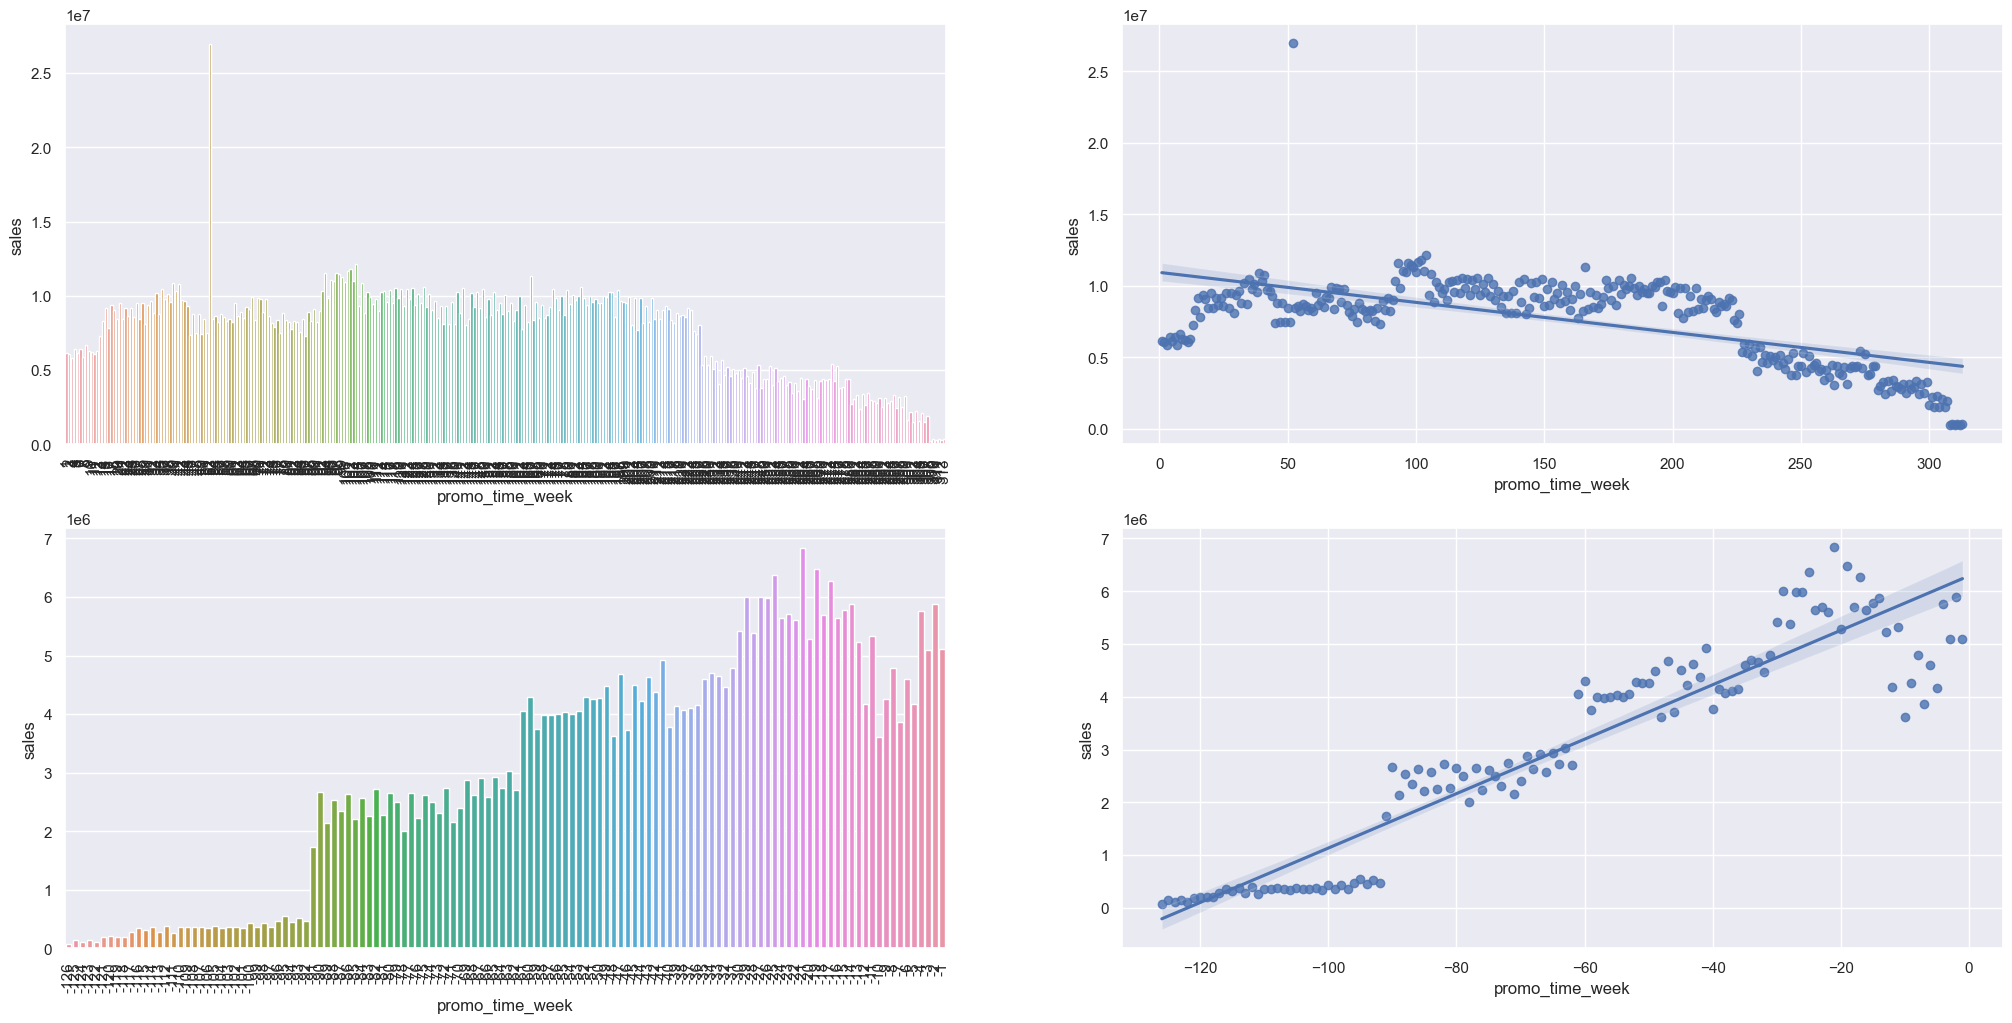

In [57]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

sns.barplot( x='promo_time_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 2 )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

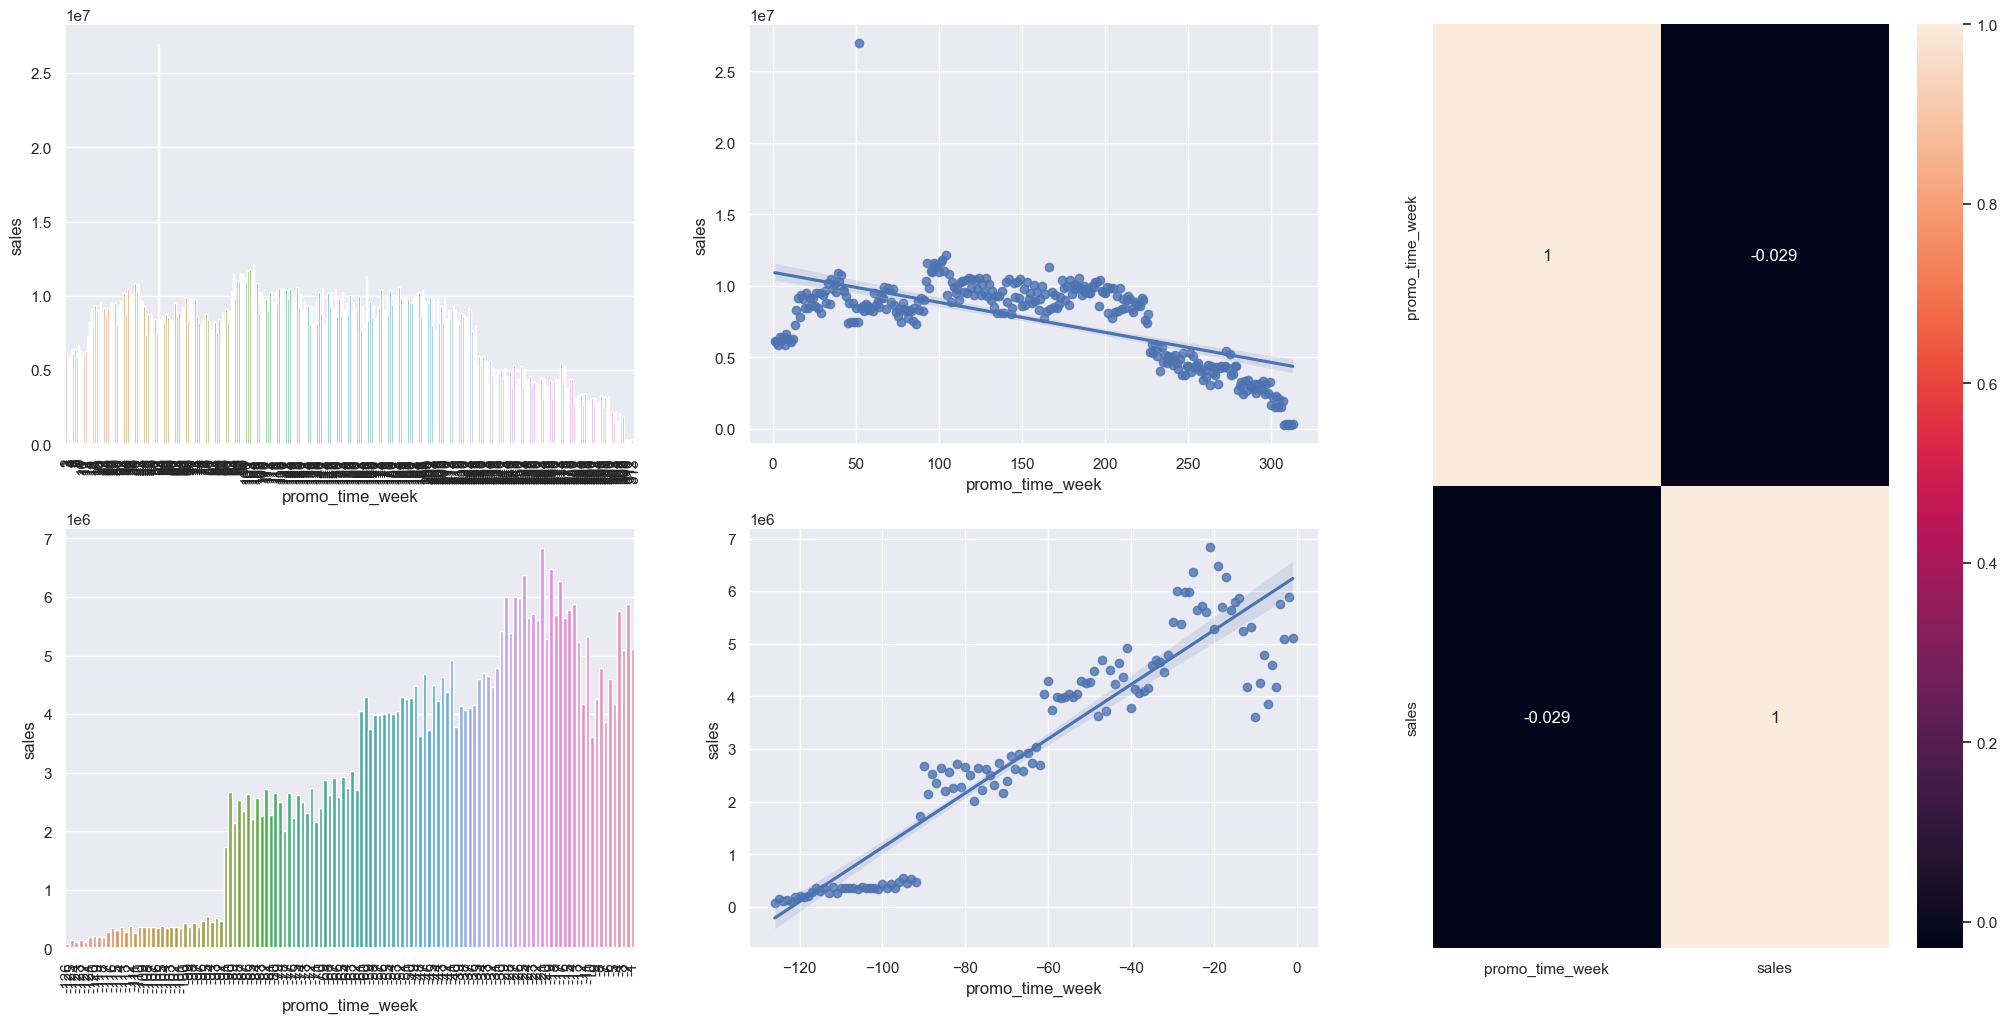

In [58]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2,3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## <font color='blue'> H5. Lojas com mais dias de promoção deveriam vender mais.

## H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [59]:
# promo is standard and promo2 is extended period of lower prices
# apparently participating in the long promotion period does not represent more sales

df4[['promo', 'promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


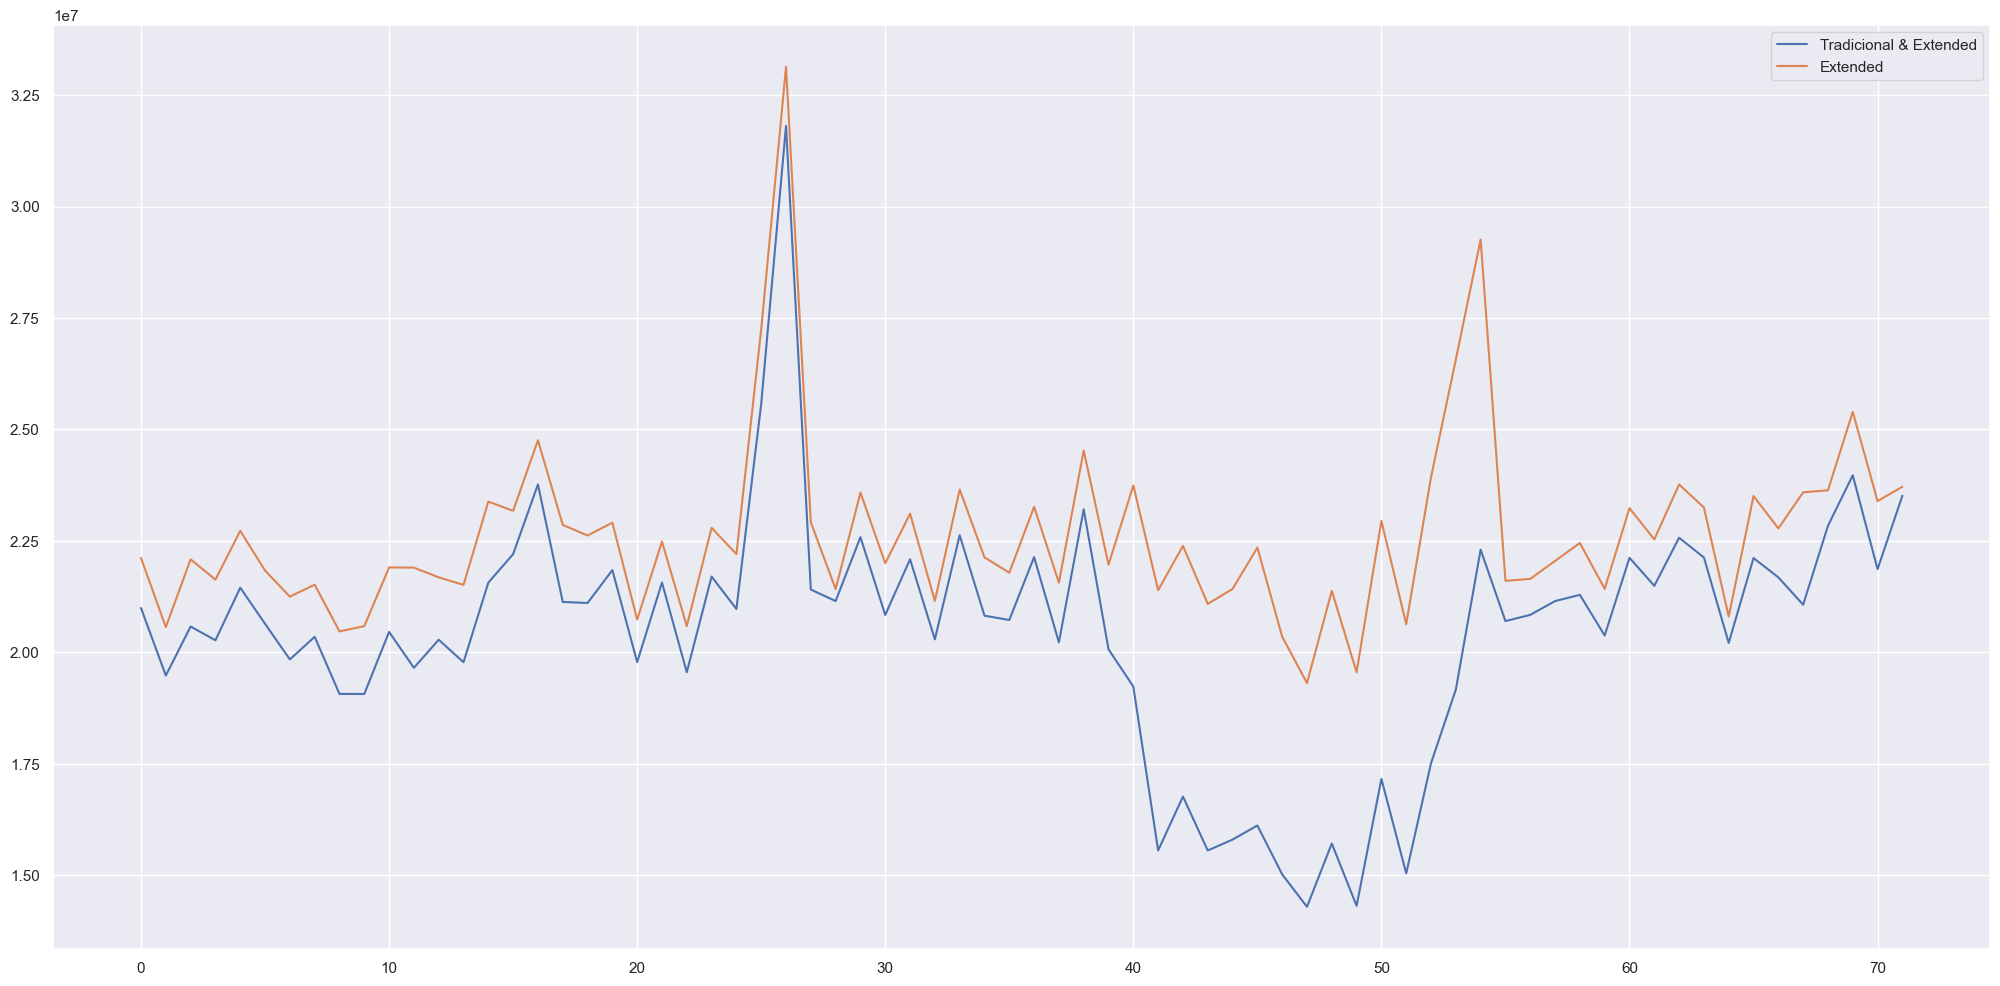

In [60]:
aux1 = df4[( df4['promo'] == 1  ) & ( df4['promo2']== 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux = aux1.plot()


aux2 = df4[( df4['promo'] == 1  ) & ( df4['promo2']== 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=aux )

aux.legend( labels=['Tradicional & Extended','Extended']);

## **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas no feriado de Natal não vendem mais...

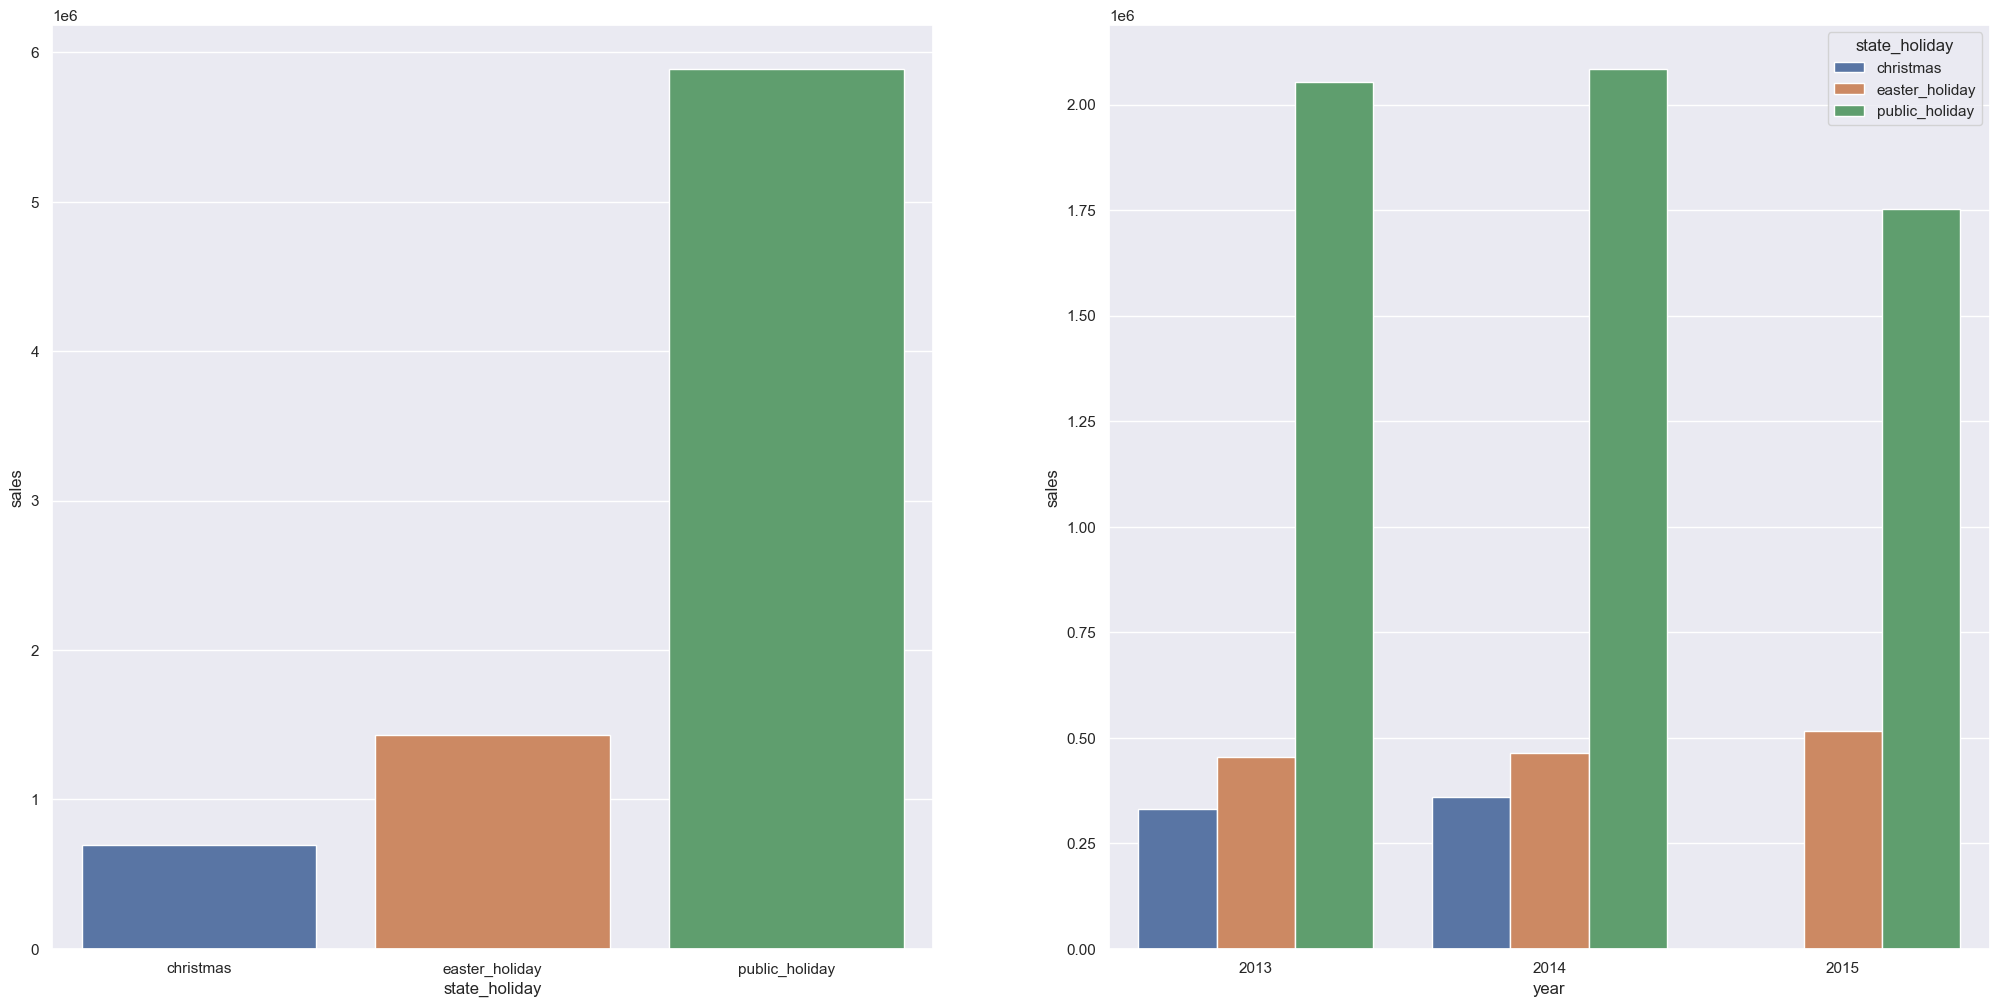

In [61]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales',hue='state_holiday', data=aux2);

## **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas estão vendendo menos ao longo dos últimos anos...

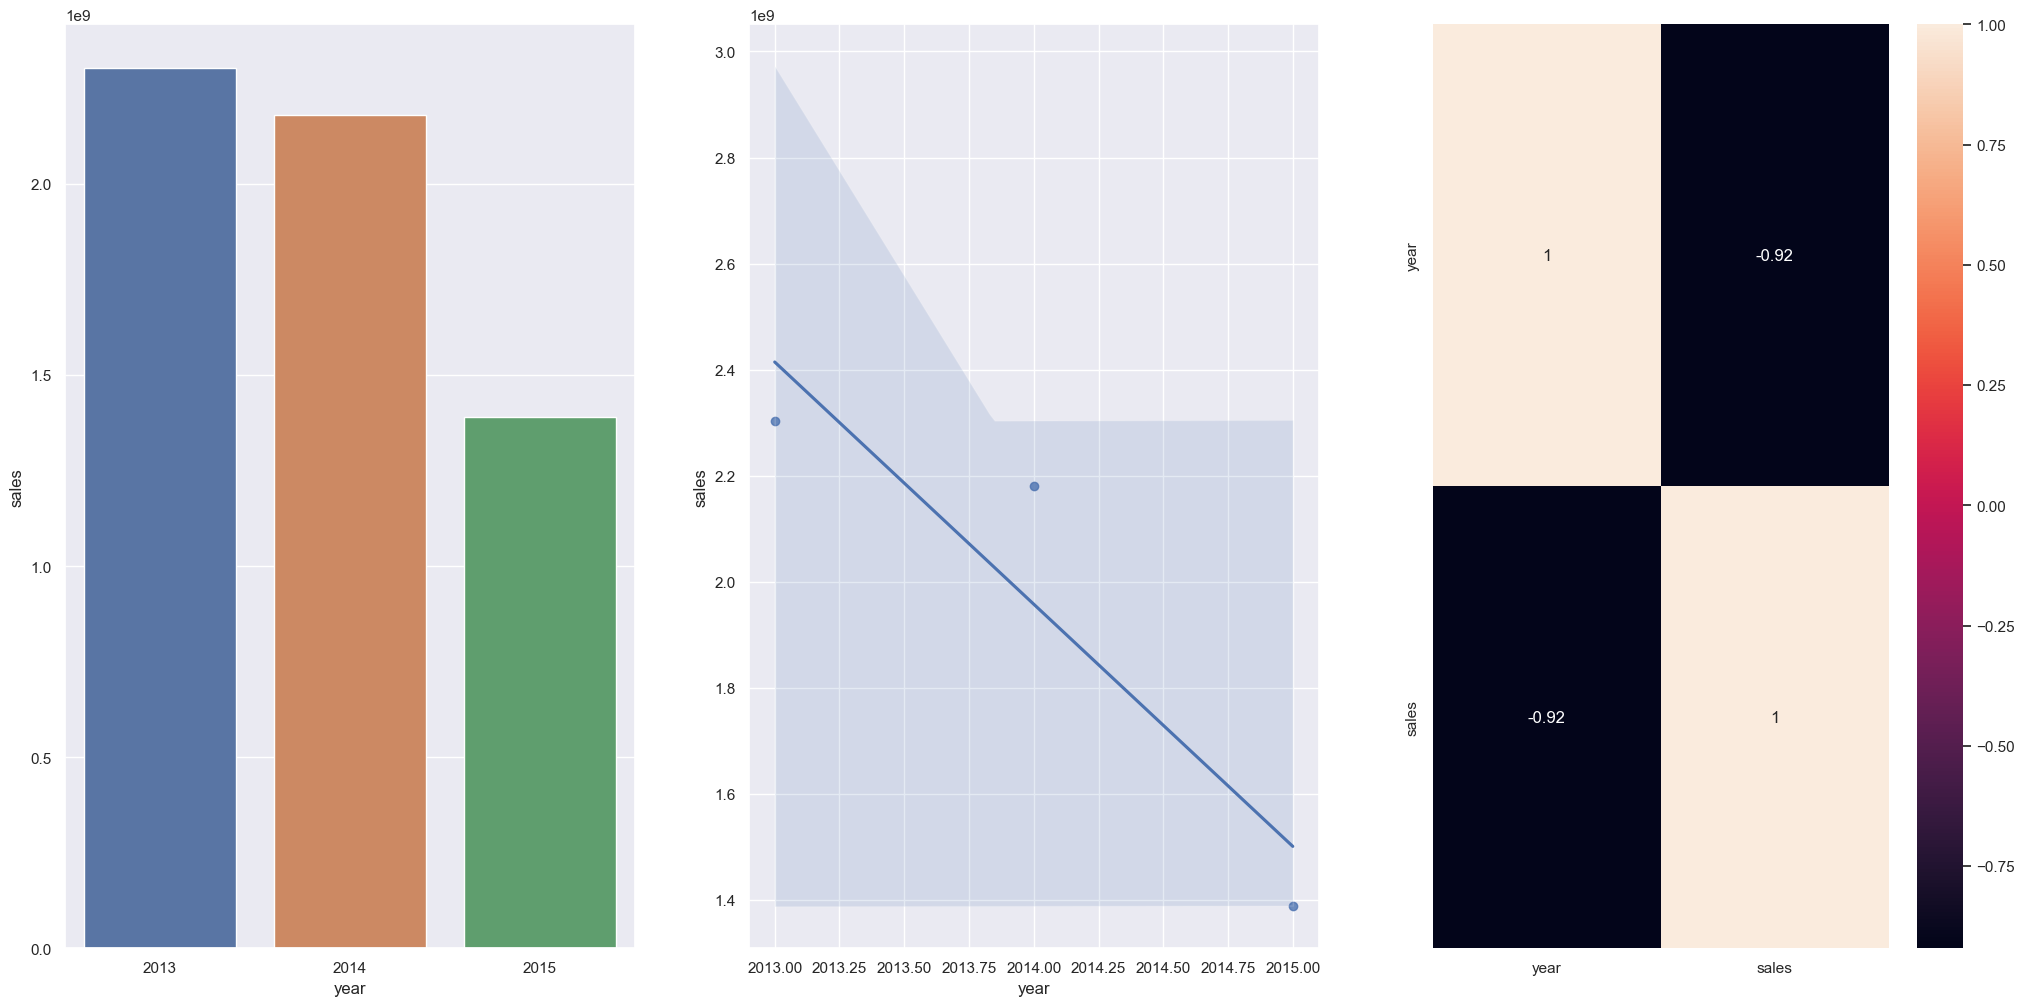

In [62]:
# 0.92 indicated the high correlation, and 2015 year impact negative analysis

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 2 )
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

## **H9.** Lojas deveriam vender mais no segundo semetre do ano
**FALSA** Lojas vendem menos no segundo semestre.

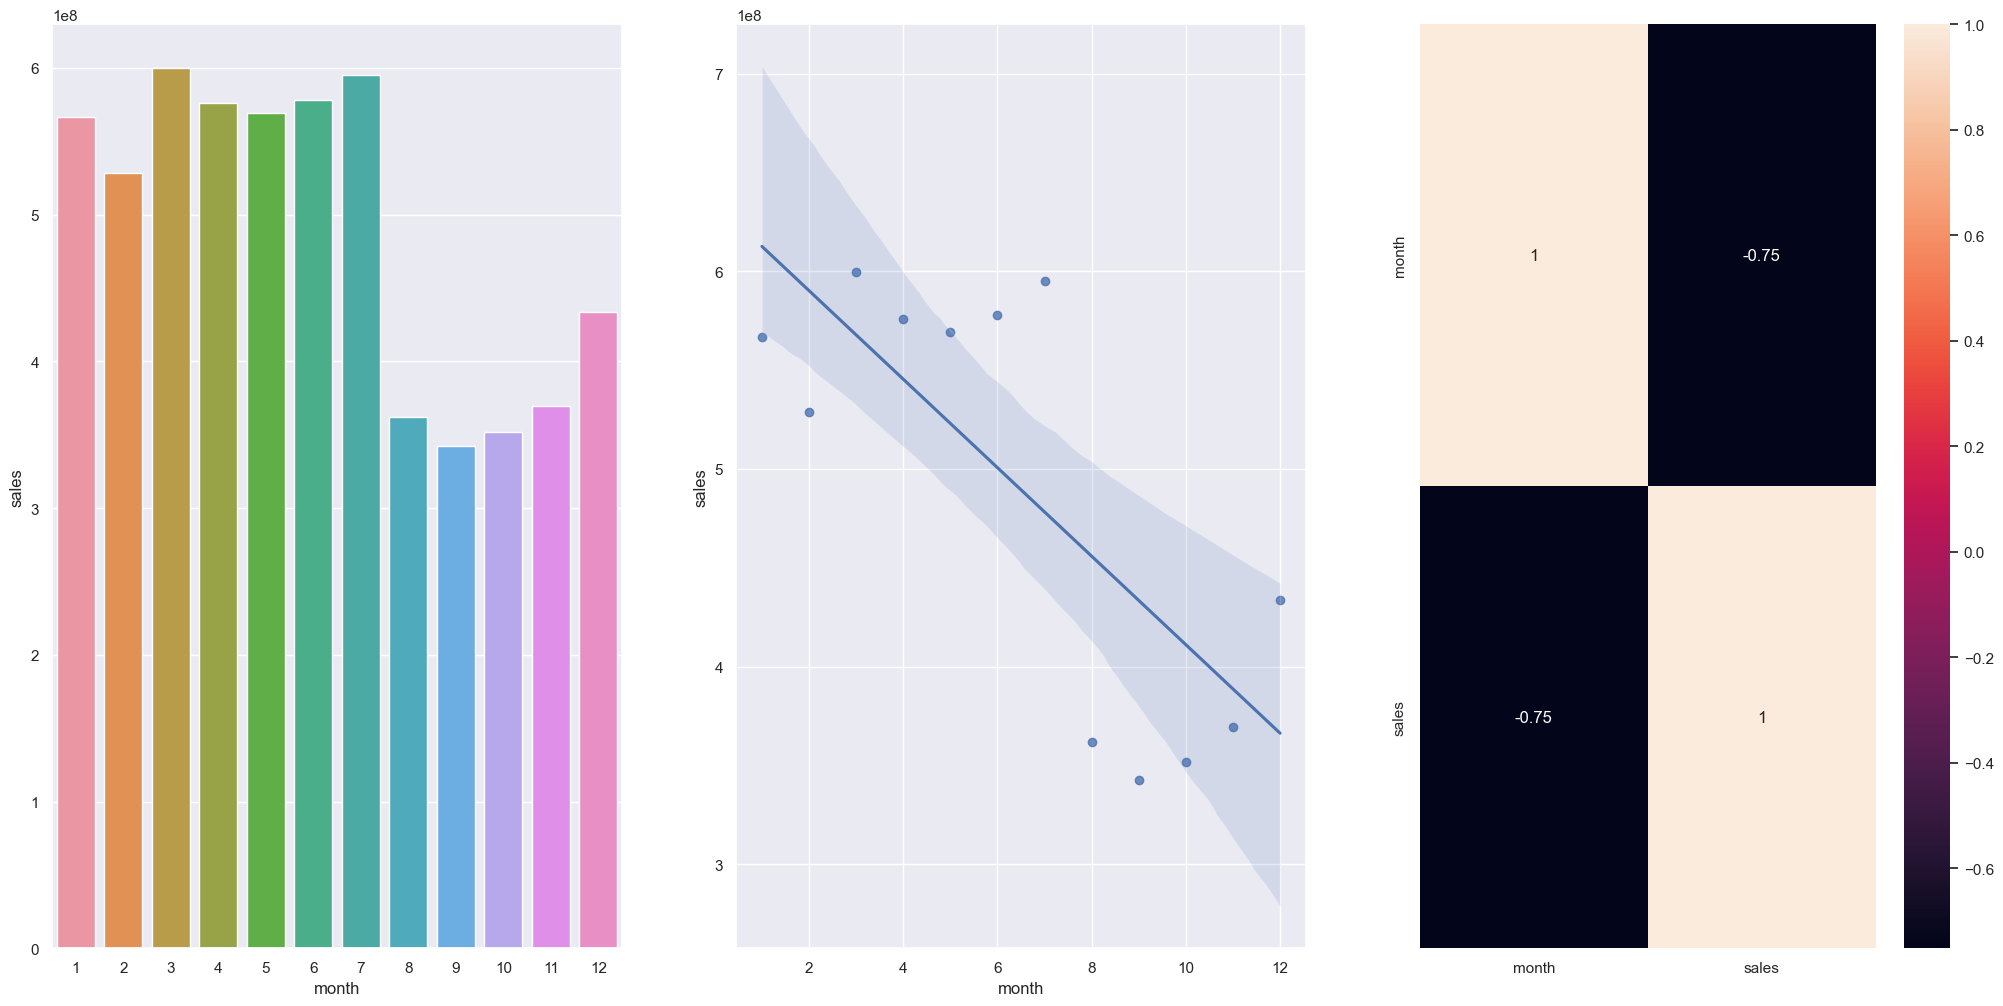

In [63]:
# in the second half year sales fall 
# 0.75 indicated the high correlation, 

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H10.** Lojas deveriam vender mais antes dos dia 10 de cada mês
**Verdadeira** Lojas vendem mais após os 10 primeiros dias de cada mês 

In [73]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <=10 else 'after_10_days' )
aux1.head()

,day,sales,before_after
0,1,155983560,before_10_days
1,2,233513169,before_10_days
2,3,194582812,before_10_days
3,4,228301010,before_10_days
4,5,212869176,before_10_days


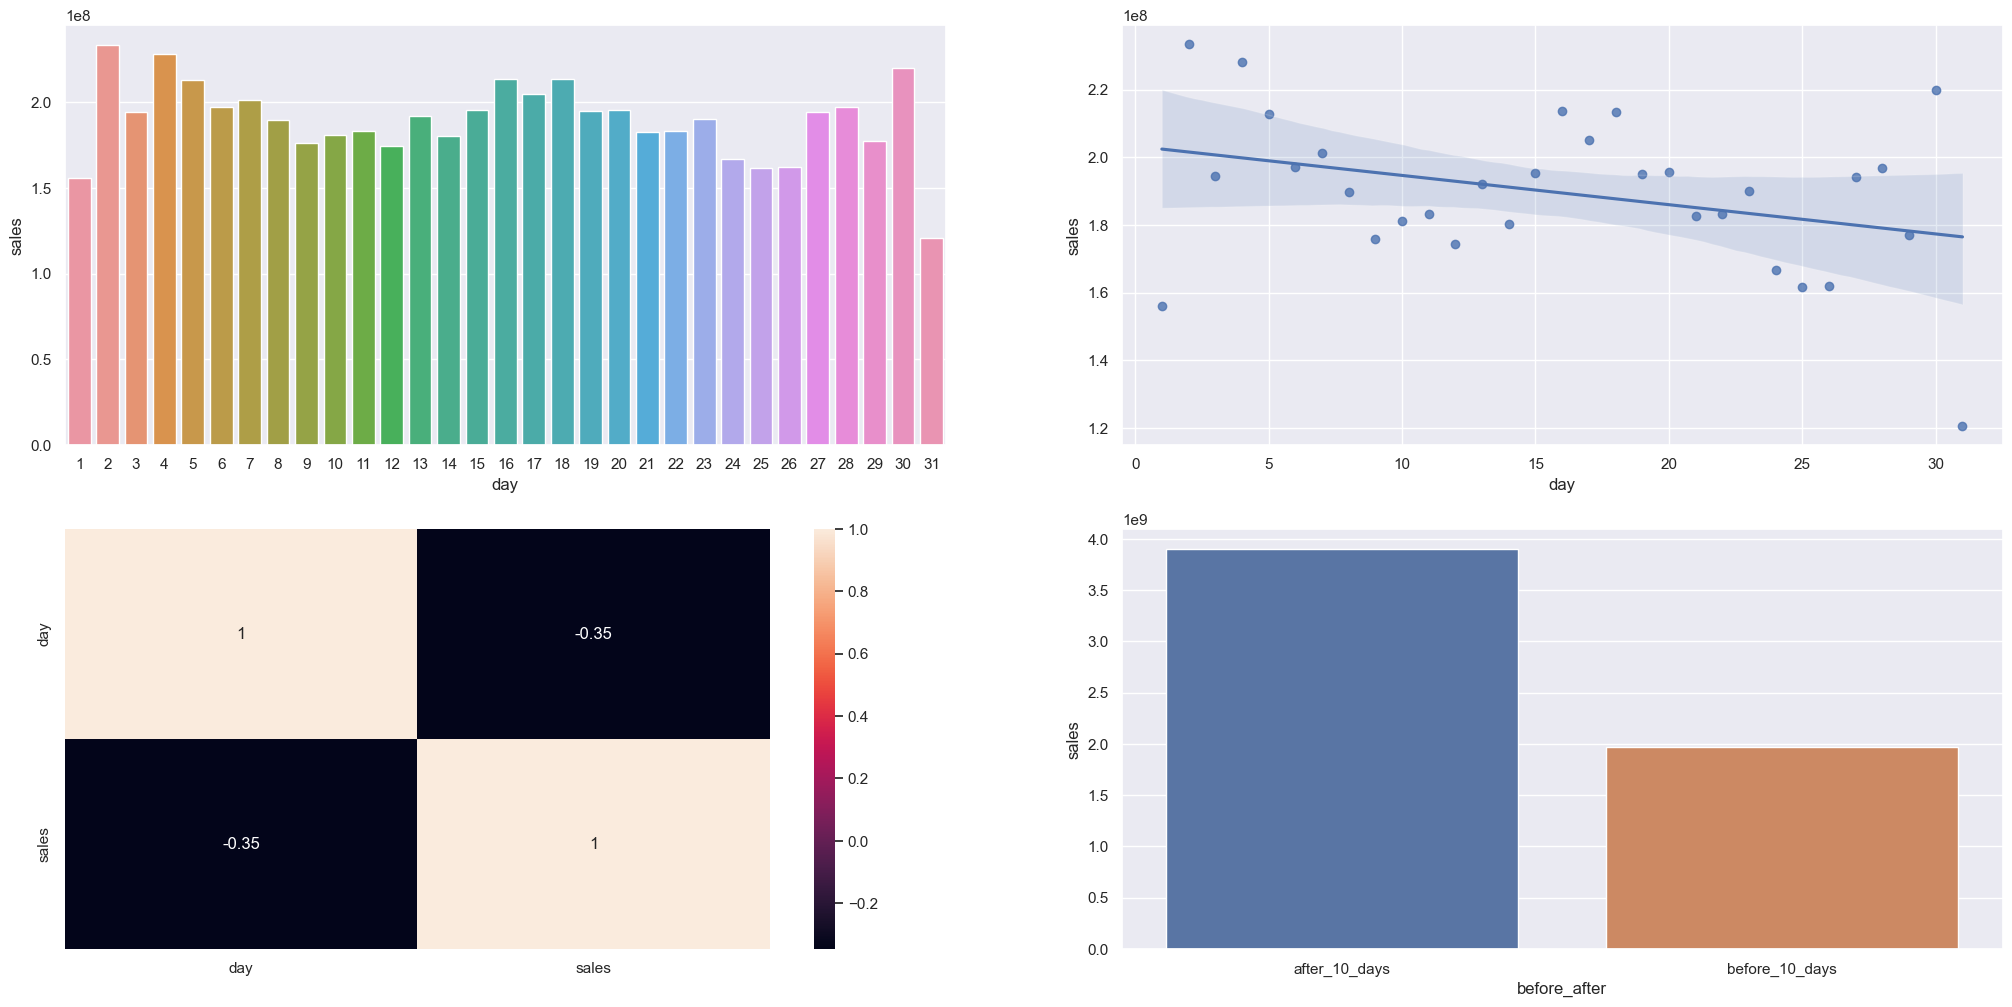

In [66]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')

aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

## **H11.** Lojas deveriam vender menos durante aos finais de semana.
**Verdadeira* Lojas vendem menos aos finais de semana. 

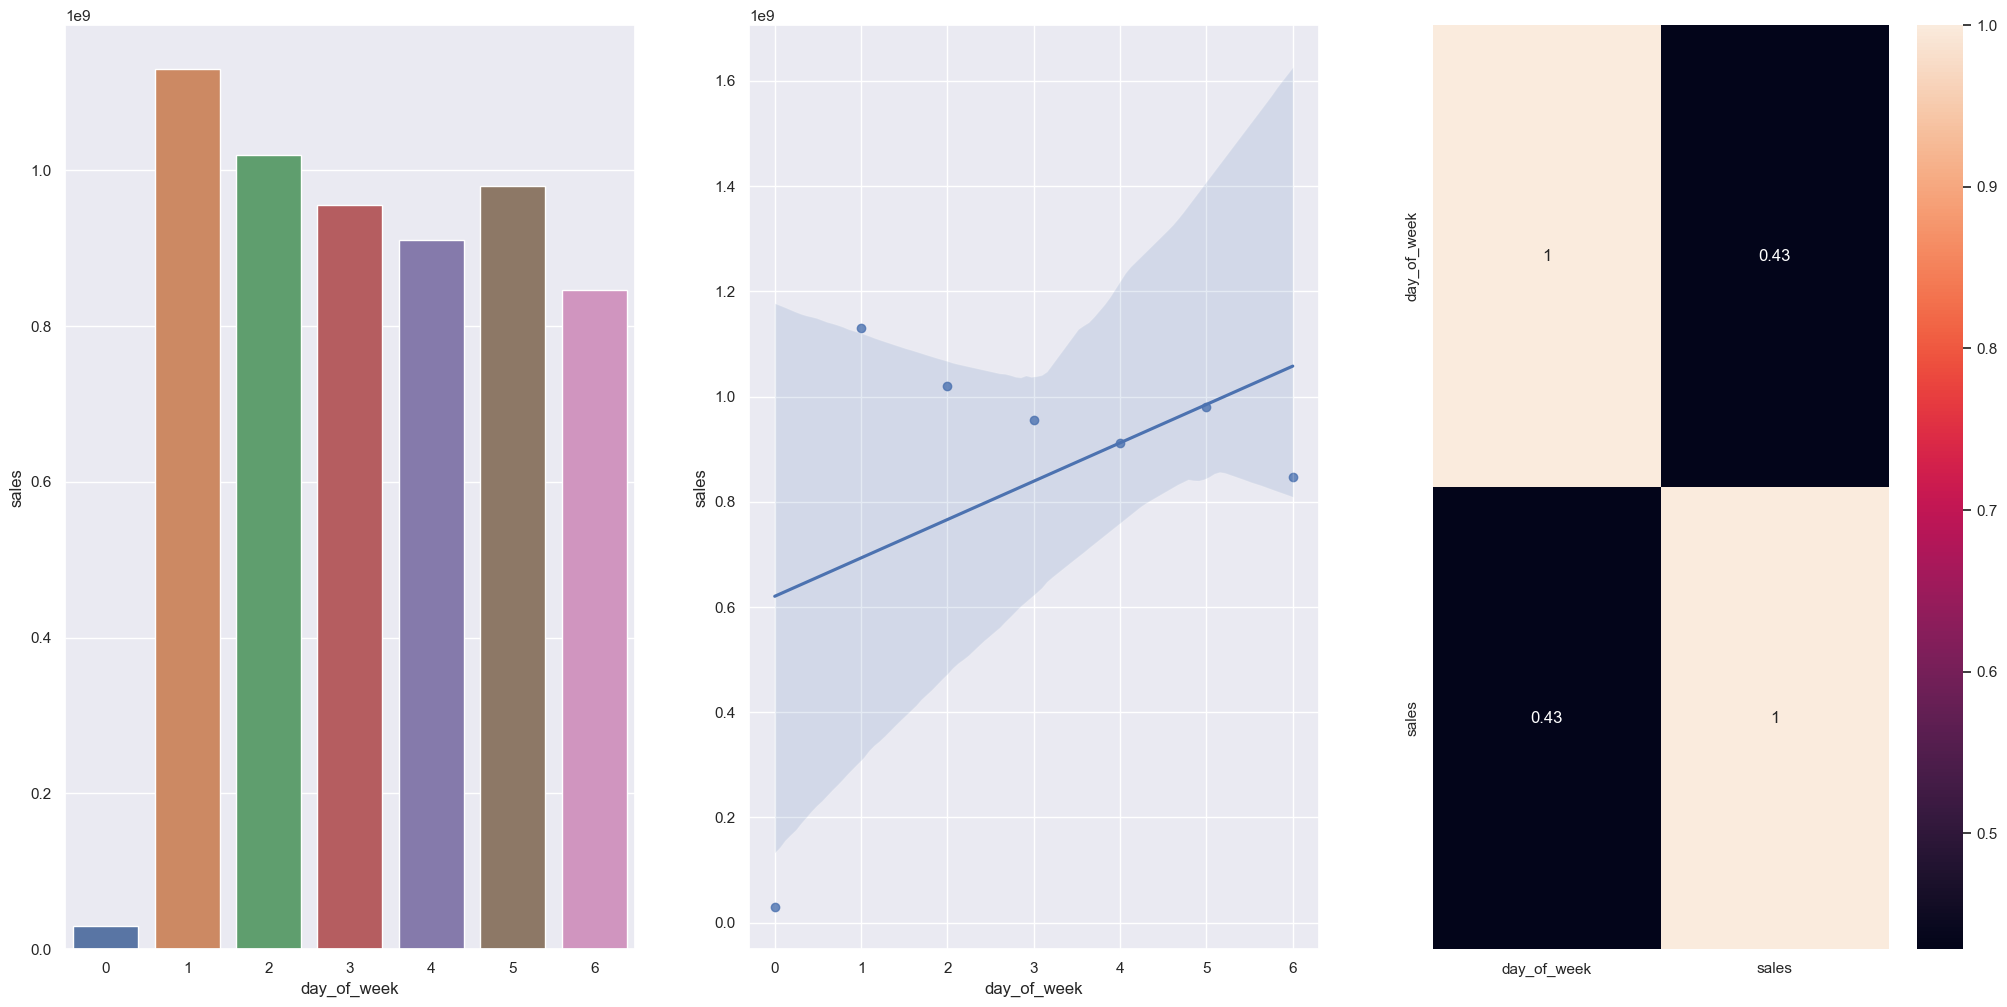

In [67]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira* Lojas vendem menos durante os feriados escolares, excluindo julho e agosto.

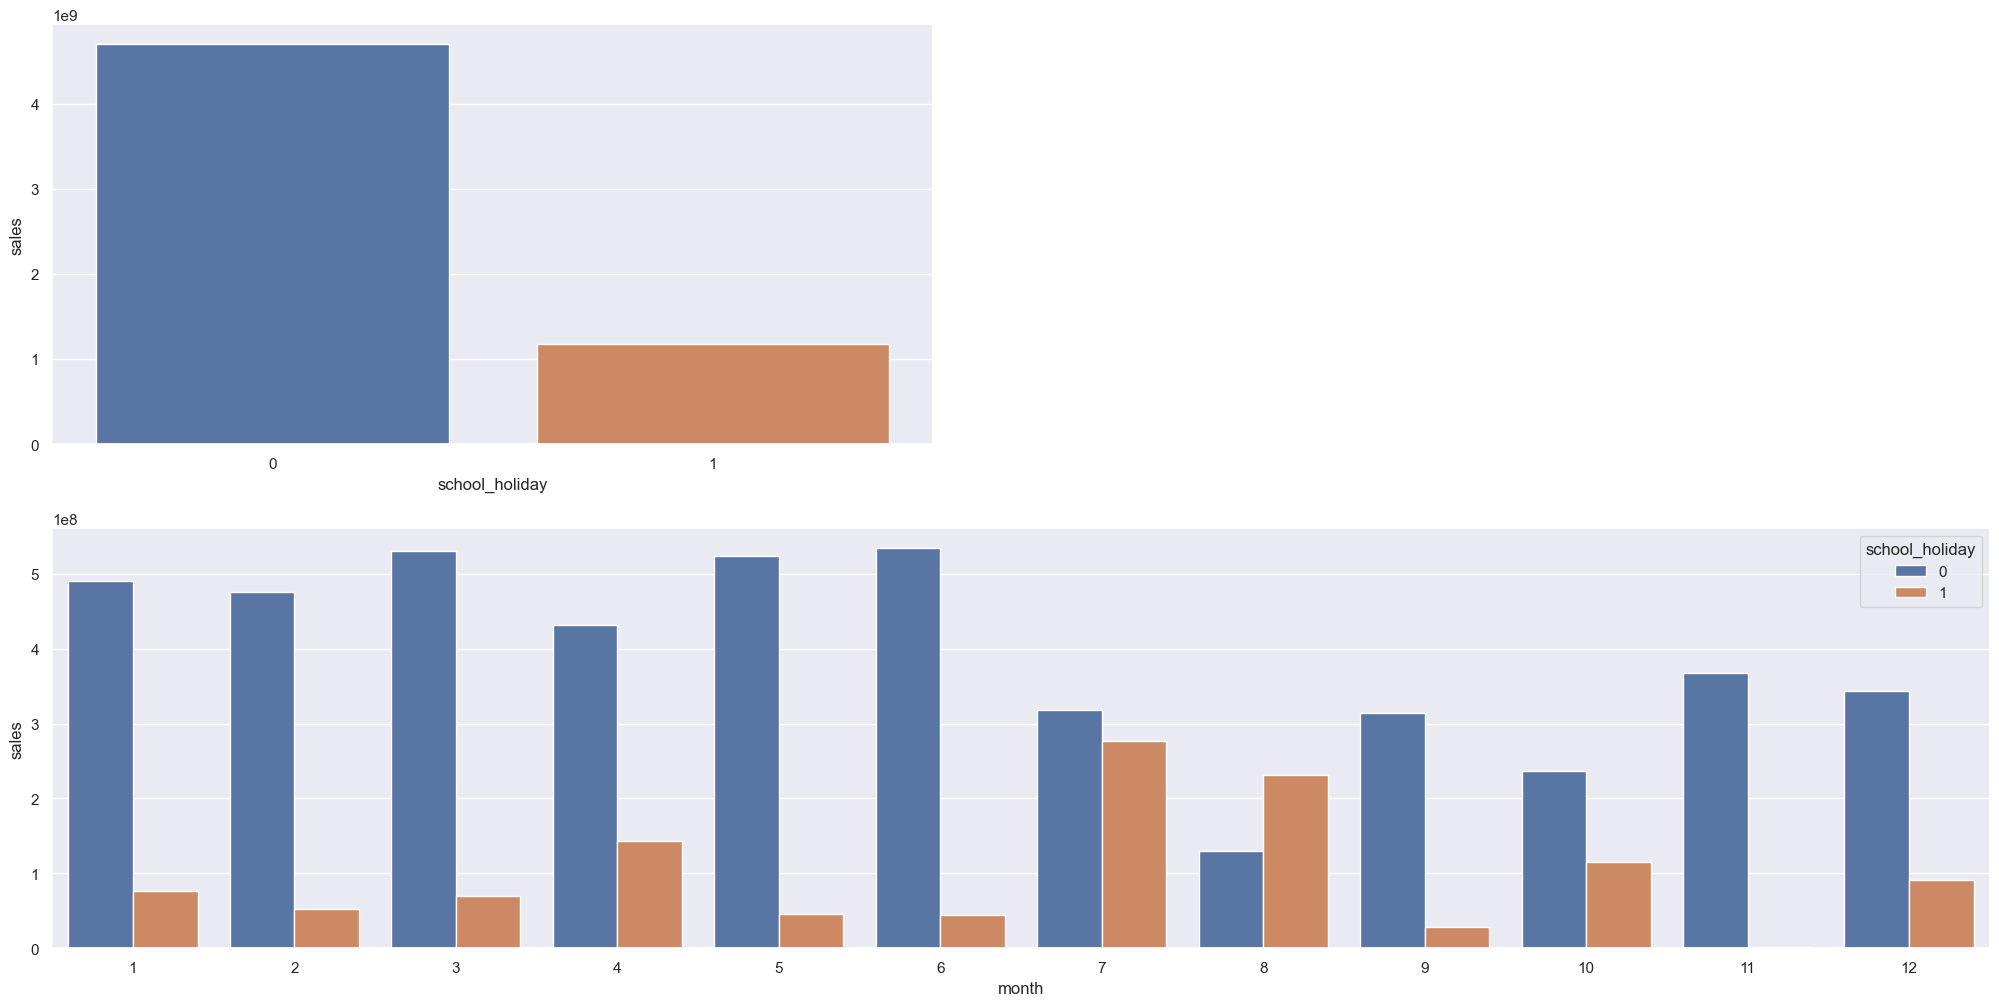

In [69]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

# 4.3 Multivariate Analysis

## 4.3.1 Numerical Attributes

<AxesSubplot:>

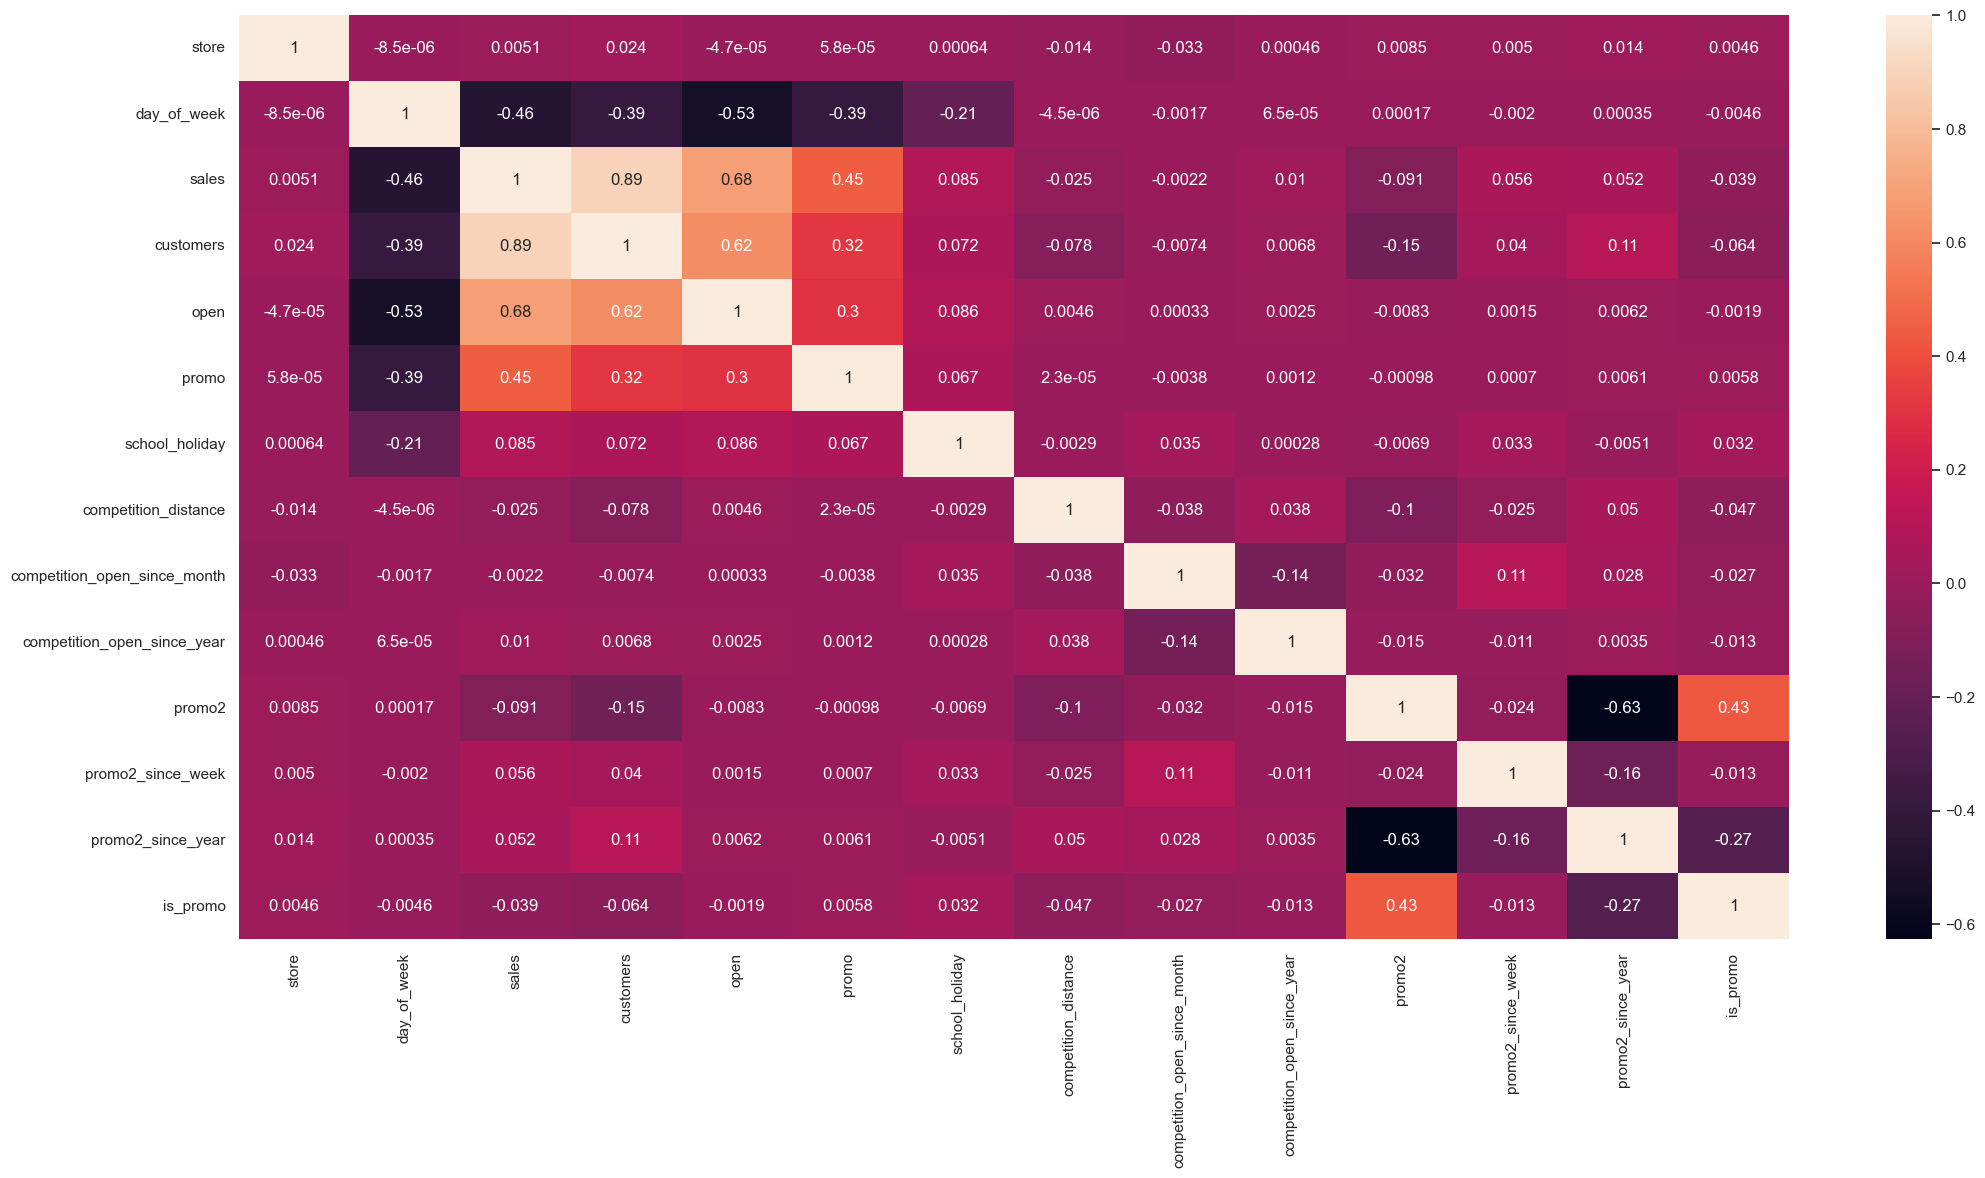

In [77]:
# pearson [-1, 1], numeric attributes correlation
# look at impacts correlation at sales; (promo, open); although customers indicated high correlation; we can't predict the number of customers on next 6 six weeks   

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

## 4.3.2 Categorical Attributes

In [107]:
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extendend,2015-30
4,regular_day,a,basic,2015-30


In [113]:
# cm = pd.crosstab( a['state_holiday'],a['store_type'] ).values

In [114]:
# chi2 = ss.chi2_contingency( cm )[0]

# n = cm.sum()

# r, k = cm.shape

In [115]:
# chi2

12792.159524019908

In [116]:
# v = np.sqrt( ( chi2/n )/( min(k-1,r-1 ) ) )

In [117]:
#v

0.07106457093267678

In [136]:
def cramer_v (x,y):
    cm = pd.crosstab( x,y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/( n-1 ) )
    
    kcorr = k -(k-1)**2/(n-1)
    rcorr = r -((r-1)**2/(n-1))
    
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1,rcorr-1 ) ) )

In [137]:
cramer_v( a['state_holiday'], a['store_type'] )

0.07106469715258833

In [138]:
a.dtypes

state_holiday    object
store_type       object
assortment       object
year_week        object
dtype: object

In [149]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
                                
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
                                  
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
                                  
d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
               'store_type': [a4,a5,a6],
               'assortment': [a7,a8,a9] })

d = d.set_index( d.columns )

<AxesSubplot:>

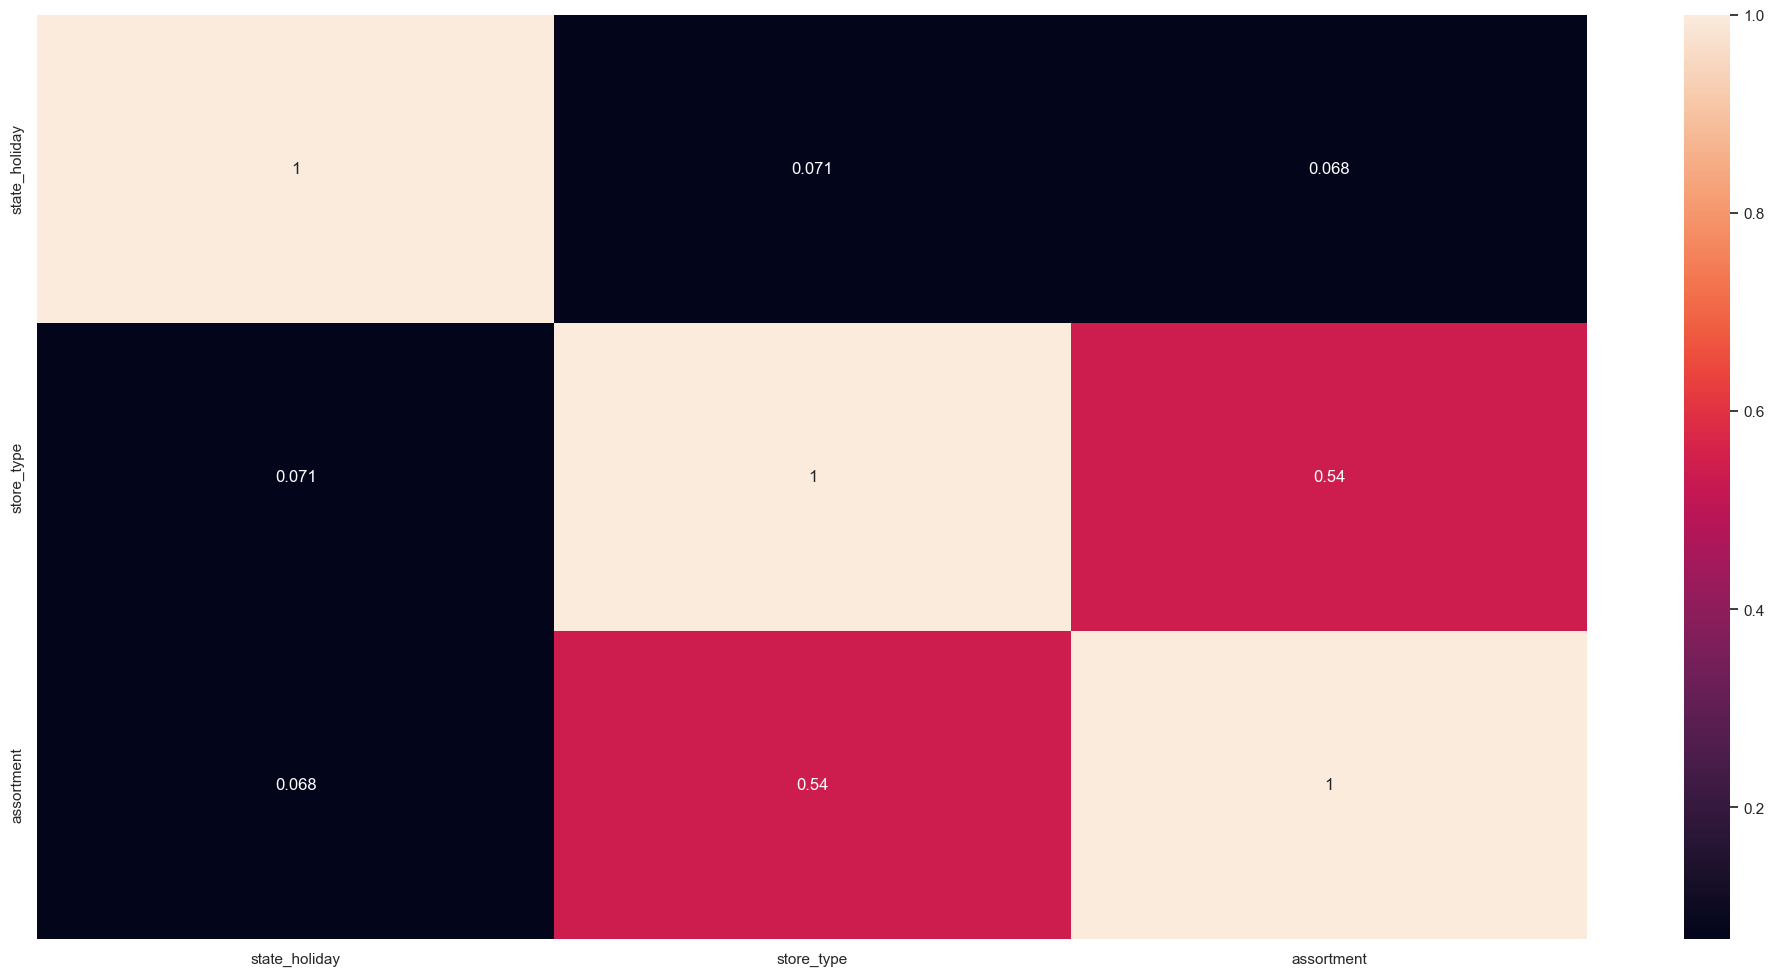

In [151]:
sns.heatmap( d, annot=True)

# state_holiday is low correlated with (store_type, assortment) 
# store_type is high correlated with (assortment)